# Preparing RS-fMRI data for SBM analysis

This Python-notebook is the first step in the analysis of RS-fMRI data with hierarchical stochastic block models. It is part of the analyses underlying the dissertation "Topic modelling for the stratification of neurological patients" written by W. Van Echelpoel (WVE) under supervision of prof. D. Marinazzo (DM) (Ghent University). The data has been provided by DM and consisted of a folder structure that included the results of a 268 parcellation of RS-fMRI data (see further). 

The notebook has been developed to work with this specific data structure, but changes can be made to load different data sets (e.g., a 278 parcellation). Whenever the original data is not available, one can directly start with the (partially) pre-processed data (correlations between ROI-pairs). Visualisation of the conventional analyses is provided to get an insight, yet final graphs have been developed in R. For this, different scripts are available ('S03_SupervisedClustering.R').

## Prepare environment with modules

In [1]:
import os
import scipy
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [6]:
# Identify working directory for data
# os.getcwd() # To check working directory
os.chdir(os.path.dirname(os.getcwd())) # Move out of 'Scripts'-folder
os.chdir ('Data') # Move into 'Data'-folder

## Data of 268 parcellation
This section is only relevant if the original raw data is available. If this is not the case, one should move directly to the first subsection (contrasting means).

As a first step, the data of the 268 parcellation is looked at. In this folder, there are 259 subfolders with data from participants (note that this number differs from the 'demo.csv' file, which mentions 260). Data is provided in individual matlab-files that have to be opened individually.

For each participant, 152 measurements are provided for each of the 268 ROIs (although the length is 278, but the last 10 columns are empty). From this data, the Pearson coefficient between time series of different ROIs are calculated (thus increasing the number of columns).

In [8]:
# Start with analysis of ROI of 268 parcellation (278: see further)
os.chdir ('01 Raw Data') # Move into folder with raw data
os.chdir ('ts268')
os.chdir ('processed') # Only for ts268 data

In [9]:
# List all participant folders
folder_list = [f for f in os.listdir(os.getcwd()) if os.path.isdir(f)]

In [10]:
# Create list to save all vectors, SD and correlations
roiSTD = []
corrList = []

In [11]:
# Loop over all folders
for folder in folder_list:
    # Go deeper in folder list
    os.chdir(folder)
    os.chdir('fmri_rest')
    
    # Read in data + remove last 10 columns ('na')    
    data_roi = scipy.io.loadmat(file_name = 'data_ROI_268')
    data = [row[:268] for row in data_roi['data_ROI']]
    
    # Extract standard deviation of time series
    roiSTD.append(list(pd.DataFrame(data).std()))
    
    # Pearson product-moment correlation coefficients
    mx_correl = np.corrcoef(np.transpose(data))
    
    # Extract coefficients off-diagonal (here upper triangular part)
    v_correl = mx_correl[np.triu_indices(len(mx_correl), k = 1)]
    
    # Append to list
    corrList.append(v_correl)
    
    # Move up two folders to allow loop to continue
    os.chdir(os.path.dirname(os.getcwd()))
    os.chdir(os.path.dirname(os.getcwd()))

# Move three folders up to exit folder with raw data
os.chdir(os.path.dirname(os.getcwd()))
os.chdir(os.path.dirname(os.getcwd()))
os.chdir(os.path.dirname(os.getcwd())) # Move out of 'Scripts'-folder

C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [12]:
# Create reference list for ROI-pairs
df_roiRef, n_pair = [], 0
for i in range(len(mx_correl)):
    for j in range(i + 1, len(mx_correl)):
        df_roiRef.append([i, j, 'Pair' + str(n_pair+1)])
        n_pair += 1

In [13]:
df_roiRef = pd.DataFrame(df_roiRef, columns = ['Region 1', 'Region 2', 'Pair'])

In [14]:
# Turn correlation list into dataframe with indices
corrList = pd.DataFrame(corrList, columns = ['Pair' + str(i+1) for i in range(len(corrList[0]))])
corrList.index = folder_list

# Turn STD list into dataframe with indices
roiSTD = pd.DataFrame(roiSTD, columns = ['Pair' + str(i+1) for i in range(len(roiSTD[0]))])
roiSTD.index = folder_list

In [15]:
# Identify columns (ROI-pairs) with missing data and exclude from data
v_exclude = corrList.isnull().sum()[corrList.isnull().sum() > 0].index.tolist()
corrList_NoNa = corrList.loc[:, ~corrList.columns.isin(v_exclude)]

In [16]:
# Number of ROI-pairs to exclude to obtain a complete matrix
len(v_exclude)

4653

In [20]:
# Save data frames
df_roiRef.to_csv('./02 Cleaned data/D_ROIReferenceList.txt', sep = ';')
corrList.to_csv('./02 Cleaned data/D_PearsonCoefficient.txt', sep = ';')
corrList_NoNa.to_csv('./02 Cleaned data/D_PearsonCoefficient_NoNa.txt', sep = ';')

Aside from storing the data for subsequent analysis, it might be interesting to have a look at the data itself. For this, the main focus is directed at the Pearson coefficients (as per initial idea of the study). Attention is given to (1) contrast of the category means for all ROI-pairs, (2) PCA of the Pearson coefficient data, and (3) hierarchical clustering.

The visualisation included in this notebook is meant to give an insight in the data and the results of the more conventional clustering techniques. The results of the category means are directly used by R for creating figures for the report, while PCA and hierarchical clustering are done anew in R (and the associated visual representations are used for the report). These steps are taken in the R-script 'S03_SupervisedClustering.R'. Hence, visualisations in this notebook are merely included for being a more stand-alone analysis notebook.

### Contrasting category means

In [2]:
# Read in data (if necessary), else update name
corrDF = pd.read_csv('./02 Cleaned data/D_PearsonCoefficient_NoNa.txt', sep = ";", index_col = 0)
# corrDF = pd.DataFrame(corrList_NoNa)

# Add column name with Group info
corrDF = corrDF.assign(Category = [1]*120 + [2]*50 + [3]*49 + [4]*40)
corrDF.iloc[:2,:]

In [4]:
# Calculate mean Pearson coefficient per pair per category
corrMeans = corrDF.groupby(['Category']).mean()
corrMeans

,Pair1,Pair2,Pair3,Pair4,Pair5,Pair6,Pair7,Pair8,Pair9,Pair10,...,Pair35764,Pair35765,Pair35767,Pair35768,Pair35769,Pair35771,Pair35772,Pair35774,Pair35775,Pair35778
Category,,,,,,,,,,,,,,,,,,,,,
1,0.335078,0.493718,0.487307,0.445221,0.601687,0.527438,0.417103,0.306589,0.412212,0.333179,...,0.518461,0.416074,0.279794,0.207817,0.169372,0.114940,0.101765,0.380585,0.322307,0.638515
2,0.274764,0.478637,0.497623,0.402370,0.568957,0.551896,0.451471,0.315869,0.327784,0.247628,...,0.518789,0.443195,0.284829,0.265142,0.206638,0.186091,0.158771,0.395798,0.400108,0.602956
3,0.236217,0.470620,0.382842,0.453772,0.562522,0.503802,0.369590,0.271178,0.398081,0.331358,...,0.481123,0.417247,0.244294,0.111876,0.234086,0.159396,0.093181,0.359162,0.333614,0.569075
4,0.346632,0.459524,0.487215,0.407095,0.562533,0.563336,0.485045,0.332246,0.388728,0.321873,...,0.476945,0.444534,0.343118,0.250951,0.181958,0.090640,0.091981,0.335966,0.226188,0.598695


<AxesSubplot:>

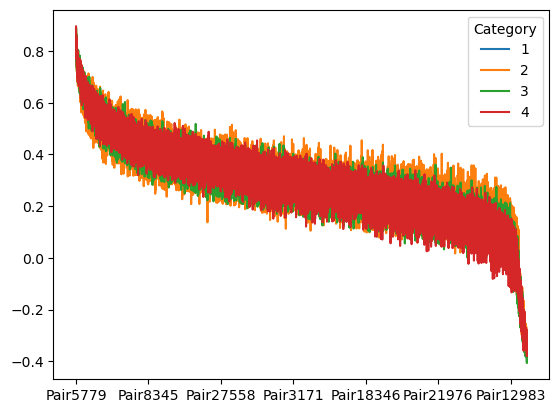

In [5]:
# Plot Pearson coefficient, from highest to lowest for category 1
corrMeans.transpose().sort_values(by = 1,ascending = False).plot()

<AxesSubplot:xlabel='3', ylabel='4'>

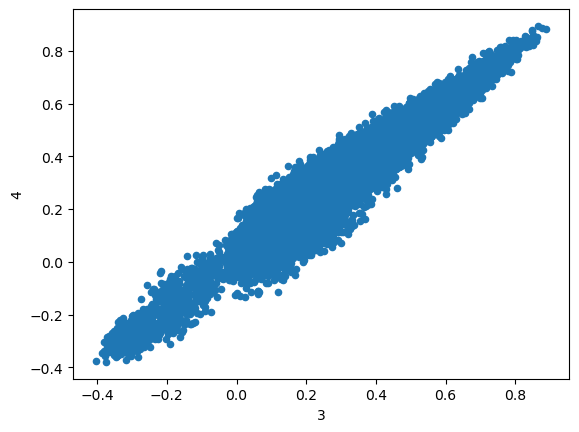

In [6]:
# Plot mean Pearson coefficients, as contrast between two groups (x and y can be changed)
corrMeans.transpose().plot.scatter(x = 3, y = 4)

In [7]:
# Save the data (e.g., for in R)
corrMeans.to_csv('./02 Cleaned data/D_MeanPerCategory.txt', sep = ';')

### PCA

In [24]:
# Read in data (if necessary), else update name
# corrDF = pd.read_csv('./02 Cleaned data/D_PearsonCoefficient_NoNa.txt', sep = ";", index_col = 0)
corrDF = pd.DataFrame(corrList_NoNa)

In [8]:
# Perform PCA with 2 components
pca_corr = PCA(n_components = 2)
pcCorr = pca_corr.fit_transform(corrDF)
pcCorr_Df = pd.DataFrame(data = pcCorr
                         , columns = ['principal component 1', 'principal component 2'])

<Figure size 640x480 with 0 Axes>

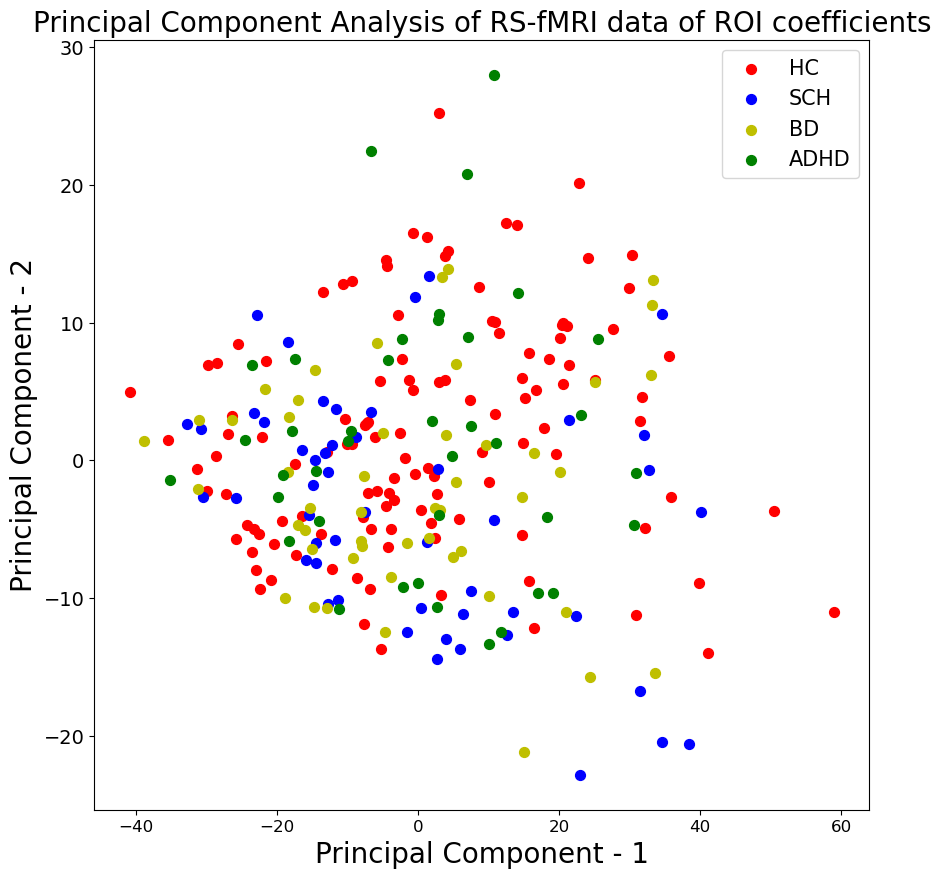

In [9]:
# Plot PCA
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of RS-fMRI data of ROI coefficients",fontsize=20)
targets = ['HC', 'SCH', 'BD', 'ADHD']
colors = ['r', 'g', 'y', 'b']
plt.scatter(pcCorr_Df.loc[:120, 'principal component 1']
                , pcCorr_Df.loc[:120, 'principal component 2'], c = 'r', s = 50)
plt.scatter(pcCorr_Df.loc[121:170, 'principal component 1']
                , pcCorr_Df.loc[121:170, 'principal component 2'], c = 'b', s = 50)
plt.scatter(pcCorr_Df.loc[171:219, 'principal component 1']
                , pcCorr_Df.loc[171:219, 'principal component 2'], c = 'y', s = 50)
plt.scatter(pcCorr_Df.loc[220:, 'principal component 1']
                , pcCorr_Df.loc[220:, 'principal component 2'], c = 'g', s = 50)
    

plt.legend(targets,prop={'size': 15})

### Hierarchical clustering

In [27]:
# Read in data (if necessary), else update name
# corrDF = pd.read_csv('./02 Cleaned data/D_PearsonCoefficient_NoNa.txt', sep = ";", index_col = 0)
corrDF = pd.DataFrame(corrList_NoNa)

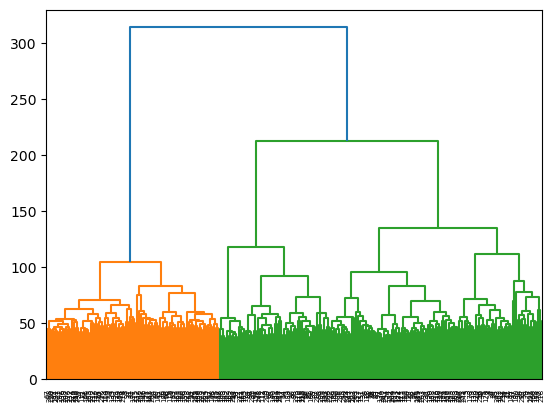

In [10]:
# Calculate linkage with Euclidean distance
linkage_data = linkage(corrDF, method='ward', metric='euclidean')
dendrogram(linkage_data)

# plt.rcParams['figure.dpi'] = 400 # To upgrade output graph
plt.show()

In [11]:
# Determine cluster membership, building on graph (3 clusters)
v_cluster = fcluster(linkage_data, 3, criterion = 'maxclust')

# Add information to dataframe
corrDF = corrDF.assign(Category = [1]*120 + [2]*50 + [3]*49 + [4]*40, Cluster = v_cluster)

In [12]:
# Construct crosstable to derive clustering
pd.crosstab(index=corrDF['Category'], columns=corrDF['Cluster'])

Cluster,1,2,3
Category,,,
1,37,32,51
2,20,9,21
3,21,11,17
4,12,6,22


In [13]:
# Save the data (e.g., for in R)
corrDF.to_csv('./02 Cleaned data/D_HierarchicalClustering.txt', sep = ';')

### Selection of ROI-pairs based on correlation

The original number of variables (i.e. ROI-pairs) is high and might affect subsequent parameter inference and overall interpretability. Hence, a reduction of the ROI-pairs is considered through a correlation analysis. Due to the long calculation time of a complete correlation matrix, an alternative approach was used. More specifically, correlated ROI-pairs with the first ROI-pair were identified and stored for later removal. Then, the same was done for the second ROI-pair (if it was not yet identified as having a correlation with the first ROI-pair) and so on. It is conceivable that a reorganisation of the ROI-pairs will result in a different selection of ROI-pairs to be removed, yet this has not been checked in the framework of this study.

In [9]:
# Read in data (if necessary), else update name
# corrDF = pd.read_csv('./02 Cleaned data/D_PearsonCoefficient.txt', sep = ";", index_col = 0)
# corrDF_NoNa = pd.read_csv('./02 Cleaned data/D_PearsonCoefficient_NoNa.txt', sep = ";", index_col = 0)
corrDF = pd.DataFrame(corrList)
corrDF_NoNa = pd.DataFrame(corrList_NoNa)

In [10]:
# Define threshold (MANUALLY!) and set for pairs to be eliminated
n_lmt = [0.5, 0.75][1]

In [40]:
# Use column-wise approach to exclude pairs
red = set()
for p1 in range(corrDF.shape[1]):
  print('--Column ' + str(p1 + 1) + ' of ' + str(corrDF.shape[1]) + '--')
  for p2 in range(p1 + 1, corrDF.shape[1]):
    if corrDF.columns[p1] not in red and corrDF.columns[p2] not in red:
      n_corr = corrDF.iloc[:,p1].corr(corrDF.iloc[:,p2])
      # print(corrDF.columns[p1] + ' & ' + corrDF.columns[p2] + ': ' + str(n_corr))
      if abs(n_corr) > n_lmt:
        red.add(corrDF.columns[p2])

--Column 1 of 35778--
--Column 2 of 35778--
--Column 3 of 35778--
--Column 4 of 35778--
--Column 5 of 35778--
--Column 6 of 35778--
--Column 7 of 35778--
--Column 8 of 35778--
--Column 9 of 35778--
--Column 10 of 35778--
--Column 11 of 35778--
--Column 12 of 35778--
--Column 13 of 35778--
--Column 14 of 35778--
--Column 15 of 35778--
--Column 16 of 35778--
--Column 17 of 35778--
--Column 18 of 35778--
--Column 19 of 35778--
--Column 20 of 35778--
--Column 21 of 35778--
--Column 22 of 35778--
--Column 23 of 35778--
--Column 24 of 35778--
--Column 25 of 35778--
--Column 26 of 35778--
--Column 27 of 35778--
--Column 28 of 35778--
--Column 29 of 35778--
--Column 30 of 35778--
--Column 31 of 35778--
--Column 32 of 35778--
--Column 33 of 35778--
--Column 34 of 35778--
--Column 35 of 35778--
--Column 36 of 35778--
--Column 37 of 35778--
--Column 38 of 35778--
--Column 39 of 35778--
--Column 40 of 35778--
--Column 41 of 35778--
--Column 42 of 35778--
--Column 43 of 35778--
--Column 44 of 35778

--Column 349 of 35778--
--Column 350 of 35778--
--Column 351 of 35778--
--Column 352 of 35778--
--Column 353 of 35778--
--Column 354 of 35778--
--Column 355 of 35778--
--Column 356 of 35778--
--Column 357 of 35778--
--Column 358 of 35778--
--Column 359 of 35778--
--Column 360 of 35778--
--Column 361 of 35778--
--Column 362 of 35778--
--Column 363 of 35778--
--Column 364 of 35778--
--Column 365 of 35778--
--Column 366 of 35778--
--Column 367 of 35778--
--Column 368 of 35778--
--Column 369 of 35778--
--Column 370 of 35778--
--Column 371 of 35778--
--Column 372 of 35778--
--Column 373 of 35778--
--Column 374 of 35778--
--Column 375 of 35778--
--Column 376 of 35778--
--Column 377 of 35778--
--Column 378 of 35778--
--Column 379 of 35778--
--Column 380 of 35778--
--Column 381 of 35778--
--Column 382 of 35778--
--Column 383 of 35778--
--Column 384 of 35778--
--Column 385 of 35778--
--Column 386 of 35778--
--Column 387 of 35778--
--Column 388 of 35778--
--Column 389 of 35778--
--Column 390 of 

--Column 695 of 35778--
--Column 696 of 35778--
--Column 697 of 35778--
--Column 698 of 35778--
--Column 699 of 35778--
--Column 700 of 35778--
--Column 701 of 35778--
--Column 702 of 35778--
--Column 703 of 35778--
--Column 704 of 35778--
--Column 705 of 35778--
--Column 706 of 35778--
--Column 707 of 35778--
--Column 708 of 35778--
--Column 709 of 35778--
--Column 710 of 35778--
--Column 711 of 35778--
--Column 712 of 35778--
--Column 713 of 35778--
--Column 714 of 35778--
--Column 715 of 35778--
--Column 716 of 35778--
--Column 717 of 35778--
--Column 718 of 35778--
--Column 719 of 35778--
--Column 720 of 35778--
--Column 721 of 35778--
--Column 722 of 35778--
--Column 723 of 35778--
--Column 724 of 35778--
--Column 725 of 35778--
--Column 726 of 35778--
--Column 727 of 35778--
--Column 728 of 35778--
--Column 729 of 35778--
--Column 730 of 35778--
--Column 731 of 35778--
--Column 732 of 35778--
--Column 733 of 35778--
--Column 734 of 35778--
--Column 735 of 35778--
--Column 736 of 

--Column 1035 of 35778--
--Column 1036 of 35778--
--Column 1037 of 35778--
--Column 1038 of 35778--
--Column 1039 of 35778--
--Column 1040 of 35778--
--Column 1041 of 35778--
--Column 1042 of 35778--
--Column 1043 of 35778--
--Column 1044 of 35778--
--Column 1045 of 35778--
--Column 1046 of 35778--
--Column 1047 of 35778--
--Column 1048 of 35778--
--Column 1049 of 35778--
--Column 1050 of 35778--
--Column 1051 of 35778--
--Column 1052 of 35778--
--Column 1053 of 35778--
--Column 1054 of 35778--
--Column 1055 of 35778--
--Column 1056 of 35778--
--Column 1057 of 35778--
--Column 1058 of 35778--
--Column 1059 of 35778--
--Column 1060 of 35778--
--Column 1061 of 35778--
--Column 1062 of 35778--
--Column 1063 of 35778--
--Column 1064 of 35778--
--Column 1065 of 35778--
--Column 1066 of 35778--
--Column 1067 of 35778--
--Column 1068 of 35778--
--Column 1069 of 35778--
--Column 1070 of 35778--
--Column 1071 of 35778--
--Column 1072 of 35778--
--Column 1073 of 35778--
--Column 1074 of 35778--


--Column 1363 of 35778--
--Column 1364 of 35778--
--Column 1365 of 35778--
--Column 1366 of 35778--
--Column 1367 of 35778--
--Column 1368 of 35778--
--Column 1369 of 35778--
--Column 1370 of 35778--
--Column 1371 of 35778--
--Column 1372 of 35778--
--Column 1373 of 35778--
--Column 1374 of 35778--
--Column 1375 of 35778--
--Column 1376 of 35778--
--Column 1377 of 35778--
--Column 1378 of 35778--
--Column 1379 of 35778--
--Column 1380 of 35778--
--Column 1381 of 35778--
--Column 1382 of 35778--
--Column 1383 of 35778--
--Column 1384 of 35778--
--Column 1385 of 35778--
--Column 1386 of 35778--
--Column 1387 of 35778--
--Column 1388 of 35778--
--Column 1389 of 35778--
--Column 1390 of 35778--
--Column 1391 of 35778--
--Column 1392 of 35778--
--Column 1393 of 35778--
--Column 1394 of 35778--
--Column 1395 of 35778--
--Column 1396 of 35778--
--Column 1397 of 35778--
--Column 1398 of 35778--
--Column 1399 of 35778--
--Column 1400 of 35778--
--Column 1401 of 35778--
--Column 1402 of 35778--


--Column 1691 of 35778--
--Column 1692 of 35778--
--Column 1693 of 35778--
--Column 1694 of 35778--
--Column 1695 of 35778--
--Column 1696 of 35778--
--Column 1697 of 35778--
--Column 1698 of 35778--
--Column 1699 of 35778--
--Column 1700 of 35778--
--Column 1701 of 35778--
--Column 1702 of 35778--
--Column 1703 of 35778--
--Column 1704 of 35778--
--Column 1705 of 35778--
--Column 1706 of 35778--
--Column 1707 of 35778--
--Column 1708 of 35778--
--Column 1709 of 35778--
--Column 1710 of 35778--
--Column 1711 of 35778--
--Column 1712 of 35778--
--Column 1713 of 35778--
--Column 1714 of 35778--
--Column 1715 of 35778--
--Column 1716 of 35778--
--Column 1717 of 35778--
--Column 1718 of 35778--
--Column 1719 of 35778--
--Column 1720 of 35778--
--Column 1721 of 35778--
--Column 1722 of 35778--
--Column 1723 of 35778--
--Column 1724 of 35778--
--Column 1725 of 35778--
--Column 1726 of 35778--
--Column 1727 of 35778--
--Column 1728 of 35778--
--Column 1729 of 35778--
--Column 1730 of 35778--


--Column 2023 of 35778--
--Column 2024 of 35778--
--Column 2025 of 35778--
--Column 2026 of 35778--
--Column 2027 of 35778--
--Column 2028 of 35778--
--Column 2029 of 35778--
--Column 2030 of 35778--
--Column 2031 of 35778--
--Column 2032 of 35778--
--Column 2033 of 35778--
--Column 2034 of 35778--
--Column 2035 of 35778--
--Column 2036 of 35778--
--Column 2037 of 35778--
--Column 2038 of 35778--
--Column 2039 of 35778--
--Column 2040 of 35778--
--Column 2041 of 35778--
--Column 2042 of 35778--
--Column 2043 of 35778--
--Column 2044 of 35778--
--Column 2045 of 35778--
--Column 2046 of 35778--
--Column 2047 of 35778--
--Column 2048 of 35778--
--Column 2049 of 35778--
--Column 2050 of 35778--
--Column 2051 of 35778--
--Column 2052 of 35778--
--Column 2053 of 35778--
--Column 2054 of 35778--
--Column 2055 of 35778--
--Column 2056 of 35778--
--Column 2057 of 35778--
--Column 2058 of 35778--
--Column 2059 of 35778--
--Column 2060 of 35778--
--Column 2061 of 35778--
--Column 2062 of 35778--


--Column 2352 of 35778--
--Column 2353 of 35778--
--Column 2354 of 35778--
--Column 2355 of 35778--
--Column 2356 of 35778--
--Column 2357 of 35778--
--Column 2358 of 35778--
--Column 2359 of 35778--
--Column 2360 of 35778--
--Column 2361 of 35778--
--Column 2362 of 35778--
--Column 2363 of 35778--
--Column 2364 of 35778--
--Column 2365 of 35778--
--Column 2366 of 35778--
--Column 2367 of 35778--
--Column 2368 of 35778--
--Column 2369 of 35778--
--Column 2370 of 35778--
--Column 2371 of 35778--
--Column 2372 of 35778--
--Column 2373 of 35778--
--Column 2374 of 35778--
--Column 2375 of 35778--
--Column 2376 of 35778--
--Column 2377 of 35778--
--Column 2378 of 35778--
--Column 2379 of 35778--
--Column 2380 of 35778--
--Column 2381 of 35778--
--Column 2382 of 35778--
--Column 2383 of 35778--
--Column 2384 of 35778--
--Column 2385 of 35778--
--Column 2386 of 35778--
--Column 2387 of 35778--
--Column 2388 of 35778--
--Column 2389 of 35778--
--Column 2390 of 35778--
--Column 2391 of 35778--


--Column 2681 of 35778--
--Column 2682 of 35778--
--Column 2683 of 35778--
--Column 2684 of 35778--
--Column 2685 of 35778--
--Column 2686 of 35778--
--Column 2687 of 35778--
--Column 2688 of 35778--
--Column 2689 of 35778--
--Column 2690 of 35778--
--Column 2691 of 35778--
--Column 2692 of 35778--
--Column 2693 of 35778--
--Column 2694 of 35778--
--Column 2695 of 35778--
--Column 2696 of 35778--
--Column 2697 of 35778--
--Column 2698 of 35778--
--Column 2699 of 35778--
--Column 2700 of 35778--
--Column 2701 of 35778--
--Column 2702 of 35778--
--Column 2703 of 35778--
--Column 2704 of 35778--
--Column 2705 of 35778--
--Column 2706 of 35778--
--Column 2707 of 35778--
--Column 2708 of 35778--
--Column 2709 of 35778--
--Column 2710 of 35778--
--Column 2711 of 35778--
--Column 2712 of 35778--
--Column 2713 of 35778--
--Column 2714 of 35778--
--Column 2715 of 35778--
--Column 2716 of 35778--
--Column 2717 of 35778--
--Column 2718 of 35778--
--Column 2719 of 35778--
--Column 2720 of 35778--


--Column 3011 of 35778--
--Column 3012 of 35778--
--Column 3013 of 35778--
--Column 3014 of 35778--
--Column 3015 of 35778--
--Column 3016 of 35778--
--Column 3017 of 35778--
--Column 3018 of 35778--
--Column 3019 of 35778--
--Column 3020 of 35778--
--Column 3021 of 35778--
--Column 3022 of 35778--
--Column 3023 of 35778--
--Column 3024 of 35778--
--Column 3025 of 35778--
--Column 3026 of 35778--
--Column 3027 of 35778--
--Column 3028 of 35778--
--Column 3029 of 35778--
--Column 3030 of 35778--
--Column 3031 of 35778--
--Column 3032 of 35778--
--Column 3033 of 35778--
--Column 3034 of 35778--
--Column 3035 of 35778--
--Column 3036 of 35778--
--Column 3037 of 35778--
--Column 3038 of 35778--
--Column 3039 of 35778--
--Column 3040 of 35778--
--Column 3041 of 35778--
--Column 3042 of 35778--
--Column 3043 of 35778--
--Column 3044 of 35778--
--Column 3045 of 35778--
--Column 3046 of 35778--
--Column 3047 of 35778--
--Column 3048 of 35778--
--Column 3049 of 35778--
--Column 3050 of 35778--


--Column 3340 of 35778--
--Column 3341 of 35778--
--Column 3342 of 35778--
--Column 3343 of 35778--
--Column 3344 of 35778--
--Column 3345 of 35778--
--Column 3346 of 35778--
--Column 3347 of 35778--
--Column 3348 of 35778--
--Column 3349 of 35778--
--Column 3350 of 35778--
--Column 3351 of 35778--
--Column 3352 of 35778--
--Column 3353 of 35778--
--Column 3354 of 35778--
--Column 3355 of 35778--
--Column 3356 of 35778--
--Column 3357 of 35778--
--Column 3358 of 35778--
--Column 3359 of 35778--
--Column 3360 of 35778--
--Column 3361 of 35778--
--Column 3362 of 35778--
--Column 3363 of 35778--
--Column 3364 of 35778--
--Column 3365 of 35778--
--Column 3366 of 35778--
--Column 3367 of 35778--
--Column 3368 of 35778--
--Column 3369 of 35778--
--Column 3370 of 35778--
--Column 3371 of 35778--
--Column 3372 of 35778--
--Column 3373 of 35778--
--Column 3374 of 35778--
--Column 3375 of 35778--
--Column 3376 of 35778--
--Column 3377 of 35778--
--Column 3378 of 35778--
--Column 3379 of 35778--


--Column 3668 of 35778--
--Column 3669 of 35778--
--Column 3670 of 35778--
--Column 3671 of 35778--
--Column 3672 of 35778--
--Column 3673 of 35778--
--Column 3674 of 35778--
--Column 3675 of 35778--
--Column 3676 of 35778--
--Column 3677 of 35778--
--Column 3678 of 35778--
--Column 3679 of 35778--
--Column 3680 of 35778--
--Column 3681 of 35778--
--Column 3682 of 35778--
--Column 3683 of 35778--
--Column 3684 of 35778--
--Column 3685 of 35778--
--Column 3686 of 35778--
--Column 3687 of 35778--
--Column 3688 of 35778--
--Column 3689 of 35778--
--Column 3690 of 35778--
--Column 3691 of 35778--
--Column 3692 of 35778--
--Column 3693 of 35778--
--Column 3694 of 35778--
--Column 3695 of 35778--
--Column 3696 of 35778--
--Column 3697 of 35778--
--Column 3698 of 35778--
--Column 3699 of 35778--
--Column 3700 of 35778--
--Column 3701 of 35778--
--Column 3702 of 35778--
--Column 3703 of 35778--
--Column 3704 of 35778--
--Column 3705 of 35778--
--Column 3706 of 35778--
--Column 3707 of 35778--


--Column 3997 of 35778--
--Column 3998 of 35778--
--Column 3999 of 35778--
--Column 4000 of 35778--
--Column 4001 of 35778--
--Column 4002 of 35778--
--Column 4003 of 35778--
--Column 4004 of 35778--
--Column 4005 of 35778--
--Column 4006 of 35778--
--Column 4007 of 35778--
--Column 4008 of 35778--
--Column 4009 of 35778--
--Column 4010 of 35778--
--Column 4011 of 35778--
--Column 4012 of 35778--
--Column 4013 of 35778--
--Column 4014 of 35778--
--Column 4015 of 35778--
--Column 4016 of 35778--
--Column 4017 of 35778--
--Column 4018 of 35778--
--Column 4019 of 35778--
--Column 4020 of 35778--
--Column 4021 of 35778--
--Column 4022 of 35778--
--Column 4023 of 35778--
--Column 4024 of 35778--
--Column 4025 of 35778--
--Column 4026 of 35778--
--Column 4027 of 35778--
--Column 4028 of 35778--
--Column 4029 of 35778--
--Column 4030 of 35778--
--Column 4031 of 35778--
--Column 4032 of 35778--
--Column 4033 of 35778--
--Column 4034 of 35778--
--Column 4035 of 35778--
--Column 4036 of 35778--


--Column 4325 of 35778--
--Column 4326 of 35778--
--Column 4327 of 35778--
--Column 4328 of 35778--
--Column 4329 of 35778--
--Column 4330 of 35778--
--Column 4331 of 35778--
--Column 4332 of 35778--
--Column 4333 of 35778--
--Column 4334 of 35778--
--Column 4335 of 35778--
--Column 4336 of 35778--
--Column 4337 of 35778--
--Column 4338 of 35778--
--Column 4339 of 35778--
--Column 4340 of 35778--
--Column 4341 of 35778--
--Column 4342 of 35778--
--Column 4343 of 35778--
--Column 4344 of 35778--
--Column 4345 of 35778--
--Column 4346 of 35778--
--Column 4347 of 35778--
--Column 4348 of 35778--
--Column 4349 of 35778--
--Column 4350 of 35778--
--Column 4351 of 35778--
--Column 4352 of 35778--
--Column 4353 of 35778--
--Column 4354 of 35778--
--Column 4355 of 35778--
--Column 4356 of 35778--
--Column 4357 of 35778--
--Column 4358 of 35778--
--Column 4359 of 35778--
--Column 4360 of 35778--
--Column 4361 of 35778--
--Column 4362 of 35778--
--Column 4363 of 35778--
--Column 4364 of 35778--


--Column 4655 of 35778--
--Column 4656 of 35778--
--Column 4657 of 35778--
--Column 4658 of 35778--
--Column 4659 of 35778--
--Column 4660 of 35778--
--Column 4661 of 35778--
--Column 4662 of 35778--
--Column 4663 of 35778--
--Column 4664 of 35778--
--Column 4665 of 35778--
--Column 4666 of 35778--
--Column 4667 of 35778--
--Column 4668 of 35778--
--Column 4669 of 35778--
--Column 4670 of 35778--
--Column 4671 of 35778--
--Column 4672 of 35778--
--Column 4673 of 35778--
--Column 4674 of 35778--
--Column 4675 of 35778--
--Column 4676 of 35778--
--Column 4677 of 35778--
--Column 4678 of 35778--
--Column 4679 of 35778--
--Column 4680 of 35778--
--Column 4681 of 35778--
--Column 4682 of 35778--
--Column 4683 of 35778--
--Column 4684 of 35778--
--Column 4685 of 35778--
--Column 4686 of 35778--
--Column 4687 of 35778--
--Column 4688 of 35778--
--Column 4689 of 35778--
--Column 4690 of 35778--
--Column 4691 of 35778--
--Column 4692 of 35778--
--Column 4693 of 35778--
--Column 4694 of 35778--


--Column 4983 of 35778--
--Column 4984 of 35778--
--Column 4985 of 35778--
--Column 4986 of 35778--
--Column 4987 of 35778--
--Column 4988 of 35778--
--Column 4989 of 35778--
--Column 4990 of 35778--
--Column 4991 of 35778--
--Column 4992 of 35778--
--Column 4993 of 35778--
--Column 4994 of 35778--
--Column 4995 of 35778--
--Column 4996 of 35778--
--Column 4997 of 35778--
--Column 4998 of 35778--
--Column 4999 of 35778--
--Column 5000 of 35778--
--Column 5001 of 35778--
--Column 5002 of 35778--
--Column 5003 of 35778--
--Column 5004 of 35778--
--Column 5005 of 35778--
--Column 5006 of 35778--
--Column 5007 of 35778--
--Column 5008 of 35778--
--Column 5009 of 35778--
--Column 5010 of 35778--
--Column 5011 of 35778--
--Column 5012 of 35778--
--Column 5013 of 35778--
--Column 5014 of 35778--
--Column 5015 of 35778--
--Column 5016 of 35778--
--Column 5017 of 35778--
--Column 5018 of 35778--
--Column 5019 of 35778--
--Column 5020 of 35778--
--Column 5021 of 35778--
--Column 5022 of 35778--


--Column 5311 of 35778--
--Column 5312 of 35778--
--Column 5313 of 35778--
--Column 5314 of 35778--
--Column 5315 of 35778--
--Column 5316 of 35778--
--Column 5317 of 35778--
--Column 5318 of 35778--
--Column 5319 of 35778--
--Column 5320 of 35778--
--Column 5321 of 35778--
--Column 5322 of 35778--
--Column 5323 of 35778--
--Column 5324 of 35778--
--Column 5325 of 35778--
--Column 5326 of 35778--
--Column 5327 of 35778--
--Column 5328 of 35778--
--Column 5329 of 35778--
--Column 5330 of 35778--
--Column 5331 of 35778--
--Column 5332 of 35778--
--Column 5333 of 35778--
--Column 5334 of 35778--
--Column 5335 of 35778--
--Column 5336 of 35778--
--Column 5337 of 35778--
--Column 5338 of 35778--
--Column 5339 of 35778--
--Column 5340 of 35778--
--Column 5341 of 35778--
--Column 5342 of 35778--
--Column 5343 of 35778--
--Column 5344 of 35778--
--Column 5345 of 35778--
--Column 5346 of 35778--
--Column 5347 of 35778--
--Column 5348 of 35778--
--Column 5349 of 35778--
--Column 5350 of 35778--


--Column 5639 of 35778--
--Column 5640 of 35778--
--Column 5641 of 35778--
--Column 5642 of 35778--
--Column 5643 of 35778--
--Column 5644 of 35778--
--Column 5645 of 35778--
--Column 5646 of 35778--
--Column 5647 of 35778--
--Column 5648 of 35778--
--Column 5649 of 35778--
--Column 5650 of 35778--
--Column 5651 of 35778--
--Column 5652 of 35778--
--Column 5653 of 35778--
--Column 5654 of 35778--
--Column 5655 of 35778--
--Column 5656 of 35778--
--Column 5657 of 35778--
--Column 5658 of 35778--
--Column 5659 of 35778--
--Column 5660 of 35778--
--Column 5661 of 35778--
--Column 5662 of 35778--
--Column 5663 of 35778--
--Column 5664 of 35778--
--Column 5665 of 35778--
--Column 5666 of 35778--
--Column 5667 of 35778--
--Column 5668 of 35778--
--Column 5669 of 35778--
--Column 5670 of 35778--
--Column 5671 of 35778--
--Column 5672 of 35778--
--Column 5673 of 35778--
--Column 5674 of 35778--
--Column 5675 of 35778--
--Column 5676 of 35778--
--Column 5677 of 35778--
--Column 5678 of 35778--


--Column 5967 of 35778--
--Column 5968 of 35778--
--Column 5969 of 35778--
--Column 5970 of 35778--
--Column 5971 of 35778--
--Column 5972 of 35778--
--Column 5973 of 35778--
--Column 5974 of 35778--
--Column 5975 of 35778--
--Column 5976 of 35778--
--Column 5977 of 35778--
--Column 5978 of 35778--
--Column 5979 of 35778--
--Column 5980 of 35778--
--Column 5981 of 35778--
--Column 5982 of 35778--
--Column 5983 of 35778--
--Column 5984 of 35778--
--Column 5985 of 35778--
--Column 5986 of 35778--
--Column 5987 of 35778--
--Column 5988 of 35778--
--Column 5989 of 35778--
--Column 5990 of 35778--
--Column 5991 of 35778--
--Column 5992 of 35778--
--Column 5993 of 35778--
--Column 5994 of 35778--
--Column 5995 of 35778--
--Column 5996 of 35778--
--Column 5997 of 35778--
--Column 5998 of 35778--
--Column 5999 of 35778--
--Column 6000 of 35778--
--Column 6001 of 35778--
--Column 6002 of 35778--
--Column 6003 of 35778--
--Column 6004 of 35778--
--Column 6005 of 35778--
--Column 6006 of 35778--


--Column 6295 of 35778--
--Column 6296 of 35778--
--Column 6297 of 35778--
--Column 6298 of 35778--
--Column 6299 of 35778--
--Column 6300 of 35778--
--Column 6301 of 35778--
--Column 6302 of 35778--
--Column 6303 of 35778--
--Column 6304 of 35778--
--Column 6305 of 35778--
--Column 6306 of 35778--
--Column 6307 of 35778--
--Column 6308 of 35778--
--Column 6309 of 35778--
--Column 6310 of 35778--
--Column 6311 of 35778--
--Column 6312 of 35778--
--Column 6313 of 35778--
--Column 6314 of 35778--
--Column 6315 of 35778--
--Column 6316 of 35778--
--Column 6317 of 35778--
--Column 6318 of 35778--
--Column 6319 of 35778--
--Column 6320 of 35778--
--Column 6321 of 35778--
--Column 6322 of 35778--
--Column 6323 of 35778--
--Column 6324 of 35778--
--Column 6325 of 35778--
--Column 6326 of 35778--
--Column 6327 of 35778--
--Column 6328 of 35778--
--Column 6329 of 35778--
--Column 6330 of 35778--
--Column 6331 of 35778--
--Column 6332 of 35778--
--Column 6333 of 35778--
--Column 6334 of 35778--


--Column 6623 of 35778--
--Column 6624 of 35778--
--Column 6625 of 35778--
--Column 6626 of 35778--
--Column 6627 of 35778--
--Column 6628 of 35778--
--Column 6629 of 35778--
--Column 6630 of 35778--
--Column 6631 of 35778--
--Column 6632 of 35778--
--Column 6633 of 35778--
--Column 6634 of 35778--
--Column 6635 of 35778--
--Column 6636 of 35778--
--Column 6637 of 35778--
--Column 6638 of 35778--
--Column 6639 of 35778--
--Column 6640 of 35778--
--Column 6641 of 35778--
--Column 6642 of 35778--
--Column 6643 of 35778--
--Column 6644 of 35778--
--Column 6645 of 35778--
--Column 6646 of 35778--
--Column 6647 of 35778--
--Column 6648 of 35778--
--Column 6649 of 35778--
--Column 6650 of 35778--
--Column 6651 of 35778--
--Column 6652 of 35778--
--Column 6653 of 35778--
--Column 6654 of 35778--
--Column 6655 of 35778--
--Column 6656 of 35778--
--Column 6657 of 35778--
--Column 6658 of 35778--
--Column 6659 of 35778--
--Column 6660 of 35778--
--Column 6661 of 35778--
--Column 6662 of 35778--


--Column 6951 of 35778--
--Column 6952 of 35778--
--Column 6953 of 35778--
--Column 6954 of 35778--
--Column 6955 of 35778--
--Column 6956 of 35778--
--Column 6957 of 35778--
--Column 6958 of 35778--
--Column 6959 of 35778--
--Column 6960 of 35778--
--Column 6961 of 35778--
--Column 6962 of 35778--
--Column 6963 of 35778--
--Column 6964 of 35778--
--Column 6965 of 35778--
--Column 6966 of 35778--
--Column 6967 of 35778--
--Column 6968 of 35778--
--Column 6969 of 35778--
--Column 6970 of 35778--
--Column 6971 of 35778--
--Column 6972 of 35778--
--Column 6973 of 35778--
--Column 6974 of 35778--
--Column 6975 of 35778--
--Column 6976 of 35778--
--Column 6977 of 35778--
--Column 6978 of 35778--
--Column 6979 of 35778--
--Column 6980 of 35778--
--Column 6981 of 35778--
--Column 6982 of 35778--
--Column 6983 of 35778--
--Column 6984 of 35778--
--Column 6985 of 35778--
--Column 6986 of 35778--
--Column 6987 of 35778--
--Column 6988 of 35778--
--Column 6989 of 35778--
--Column 6990 of 35778--


--Column 7279 of 35778--
--Column 7280 of 35778--
--Column 7281 of 35778--
--Column 7282 of 35778--
--Column 7283 of 35778--
--Column 7284 of 35778--
--Column 7285 of 35778--
--Column 7286 of 35778--
--Column 7287 of 35778--
--Column 7288 of 35778--
--Column 7289 of 35778--
--Column 7290 of 35778--
--Column 7291 of 35778--
--Column 7292 of 35778--
--Column 7293 of 35778--
--Column 7294 of 35778--
--Column 7295 of 35778--
--Column 7296 of 35778--
--Column 7297 of 35778--
--Column 7298 of 35778--
--Column 7299 of 35778--
--Column 7300 of 35778--
--Column 7301 of 35778--
--Column 7302 of 35778--
--Column 7303 of 35778--
--Column 7304 of 35778--
--Column 7305 of 35778--
--Column 7306 of 35778--
--Column 7307 of 35778--
--Column 7308 of 35778--
--Column 7309 of 35778--
--Column 7310 of 35778--
--Column 7311 of 35778--
--Column 7312 of 35778--
--Column 7313 of 35778--
--Column 7314 of 35778--
--Column 7315 of 35778--
--Column 7316 of 35778--
--Column 7317 of 35778--
--Column 7318 of 35778--


--Column 7609 of 35778--
--Column 7610 of 35778--
--Column 7611 of 35778--
--Column 7612 of 35778--
--Column 7613 of 35778--
--Column 7614 of 35778--
--Column 7615 of 35778--
--Column 7616 of 35778--
--Column 7617 of 35778--
--Column 7618 of 35778--
--Column 7619 of 35778--
--Column 7620 of 35778--
--Column 7621 of 35778--
--Column 7622 of 35778--
--Column 7623 of 35778--
--Column 7624 of 35778--
--Column 7625 of 35778--
--Column 7626 of 35778--
--Column 7627 of 35778--
--Column 7628 of 35778--
--Column 7629 of 35778--
--Column 7630 of 35778--
--Column 7631 of 35778--
--Column 7632 of 35778--
--Column 7633 of 35778--
--Column 7634 of 35778--
--Column 7635 of 35778--
--Column 7636 of 35778--
--Column 7637 of 35778--
--Column 7638 of 35778--
--Column 7639 of 35778--
--Column 7640 of 35778--
--Column 7641 of 35778--
--Column 7642 of 35778--
--Column 7643 of 35778--
--Column 7644 of 35778--
--Column 7645 of 35778--
--Column 7646 of 35778--
--Column 7647 of 35778--
--Column 7648 of 35778--


--Column 7943 of 35778--
--Column 7944 of 35778--
--Column 7945 of 35778--
--Column 7946 of 35778--
--Column 7947 of 35778--
--Column 7948 of 35778--
--Column 7949 of 35778--
--Column 7950 of 35778--
--Column 7951 of 35778--
--Column 7952 of 35778--
--Column 7953 of 35778--
--Column 7954 of 35778--
--Column 7955 of 35778--
--Column 7956 of 35778--
--Column 7957 of 35778--
--Column 7958 of 35778--
--Column 7959 of 35778--
--Column 7960 of 35778--
--Column 7961 of 35778--
--Column 7962 of 35778--
--Column 7963 of 35778--
--Column 7964 of 35778--
--Column 7965 of 35778--
--Column 7966 of 35778--
--Column 7967 of 35778--
--Column 7968 of 35778--
--Column 7969 of 35778--
--Column 7970 of 35778--
--Column 7971 of 35778--
--Column 7972 of 35778--
--Column 7973 of 35778--
--Column 7974 of 35778--
--Column 7975 of 35778--
--Column 7976 of 35778--
--Column 7977 of 35778--
--Column 7978 of 35778--
--Column 7979 of 35778--
--Column 7980 of 35778--
--Column 7981 of 35778--
--Column 7982 of 35778--


--Column 8273 of 35778--
--Column 8274 of 35778--
--Column 8275 of 35778--
--Column 8276 of 35778--
--Column 8277 of 35778--
--Column 8278 of 35778--
--Column 8279 of 35778--
--Column 8280 of 35778--
--Column 8281 of 35778--
--Column 8282 of 35778--
--Column 8283 of 35778--
--Column 8284 of 35778--
--Column 8285 of 35778--
--Column 8286 of 35778--
--Column 8287 of 35778--
--Column 8288 of 35778--
--Column 8289 of 35778--
--Column 8290 of 35778--
--Column 8291 of 35778--
--Column 8292 of 35778--
--Column 8293 of 35778--
--Column 8294 of 35778--
--Column 8295 of 35778--
--Column 8296 of 35778--
--Column 8297 of 35778--
--Column 8298 of 35778--
--Column 8299 of 35778--
--Column 8300 of 35778--
--Column 8301 of 35778--
--Column 8302 of 35778--
--Column 8303 of 35778--
--Column 8304 of 35778--
--Column 8305 of 35778--
--Column 8306 of 35778--
--Column 8307 of 35778--
--Column 8308 of 35778--
--Column 8309 of 35778--
--Column 8310 of 35778--
--Column 8311 of 35778--
--Column 8312 of 35778--


--Column 8613 of 35778--
--Column 8614 of 35778--
--Column 8615 of 35778--
--Column 8616 of 35778--
--Column 8617 of 35778--
--Column 8618 of 35778--
--Column 8619 of 35778--
--Column 8620 of 35778--
--Column 8621 of 35778--
--Column 8622 of 35778--
--Column 8623 of 35778--
--Column 8624 of 35778--
--Column 8625 of 35778--
--Column 8626 of 35778--
--Column 8627 of 35778--
--Column 8628 of 35778--
--Column 8629 of 35778--
--Column 8630 of 35778--
--Column 8631 of 35778--
--Column 8632 of 35778--
--Column 8633 of 35778--
--Column 8634 of 35778--
--Column 8635 of 35778--
--Column 8636 of 35778--
--Column 8637 of 35778--
--Column 8638 of 35778--
--Column 8639 of 35778--
--Column 8640 of 35778--
--Column 8641 of 35778--
--Column 8642 of 35778--
--Column 8643 of 35778--
--Column 8644 of 35778--
--Column 8645 of 35778--
--Column 8646 of 35778--
--Column 8647 of 35778--
--Column 8648 of 35778--
--Column 8649 of 35778--
--Column 8650 of 35778--
--Column 8651 of 35778--
--Column 8652 of 35778--


--Column 8943 of 35778--
--Column 8944 of 35778--
--Column 8945 of 35778--
--Column 8946 of 35778--
--Column 8947 of 35778--
--Column 8948 of 35778--
--Column 8949 of 35778--
--Column 8950 of 35778--
--Column 8951 of 35778--
--Column 8952 of 35778--
--Column 8953 of 35778--
--Column 8954 of 35778--
--Column 8955 of 35778--
--Column 8956 of 35778--
--Column 8957 of 35778--
--Column 8958 of 35778--
--Column 8959 of 35778--
--Column 8960 of 35778--
--Column 8961 of 35778--
--Column 8962 of 35778--
--Column 8963 of 35778--
--Column 8964 of 35778--
--Column 8965 of 35778--
--Column 8966 of 35778--
--Column 8967 of 35778--
--Column 8968 of 35778--
--Column 8969 of 35778--
--Column 8970 of 35778--
--Column 8971 of 35778--
--Column 8972 of 35778--
--Column 8973 of 35778--
--Column 8974 of 35778--
--Column 8975 of 35778--
--Column 8976 of 35778--
--Column 8977 of 35778--
--Column 8978 of 35778--
--Column 8979 of 35778--
--Column 8980 of 35778--
--Column 8981 of 35778--
--Column 8982 of 35778--


--Column 9276 of 35778--
--Column 9277 of 35778--
--Column 9278 of 35778--
--Column 9279 of 35778--
--Column 9280 of 35778--
--Column 9281 of 35778--
--Column 9282 of 35778--
--Column 9283 of 35778--
--Column 9284 of 35778--
--Column 9285 of 35778--
--Column 9286 of 35778--
--Column 9287 of 35778--
--Column 9288 of 35778--
--Column 9289 of 35778--
--Column 9290 of 35778--
--Column 9291 of 35778--
--Column 9292 of 35778--
--Column 9293 of 35778--
--Column 9294 of 35778--
--Column 9295 of 35778--
--Column 9296 of 35778--
--Column 9297 of 35778--
--Column 9298 of 35778--
--Column 9299 of 35778--
--Column 9300 of 35778--
--Column 9301 of 35778--
--Column 9302 of 35778--
--Column 9303 of 35778--
--Column 9304 of 35778--
--Column 9305 of 35778--
--Column 9306 of 35778--
--Column 9307 of 35778--
--Column 9308 of 35778--
--Column 9309 of 35778--
--Column 9310 of 35778--
--Column 9311 of 35778--
--Column 9312 of 35778--
--Column 9313 of 35778--
--Column 9314 of 35778--
--Column 9315 of 35778--


--Column 9610 of 35778--
--Column 9611 of 35778--
--Column 9612 of 35778--
--Column 9613 of 35778--
--Column 9614 of 35778--
--Column 9615 of 35778--
--Column 9616 of 35778--
--Column 9617 of 35778--
--Column 9618 of 35778--
--Column 9619 of 35778--
--Column 9620 of 35778--
--Column 9621 of 35778--
--Column 9622 of 35778--
--Column 9623 of 35778--
--Column 9624 of 35778--
--Column 9625 of 35778--
--Column 9626 of 35778--
--Column 9627 of 35778--
--Column 9628 of 35778--
--Column 9629 of 35778--
--Column 9630 of 35778--
--Column 9631 of 35778--
--Column 9632 of 35778--
--Column 9633 of 35778--
--Column 9634 of 35778--
--Column 9635 of 35778--
--Column 9636 of 35778--
--Column 9637 of 35778--
--Column 9638 of 35778--
--Column 9639 of 35778--
--Column 9640 of 35778--
--Column 9641 of 35778--
--Column 9642 of 35778--
--Column 9643 of 35778--
--Column 9644 of 35778--
--Column 9645 of 35778--
--Column 9646 of 35778--
--Column 9647 of 35778--
--Column 9648 of 35778--
--Column 9649 of 35778--


--Column 9940 of 35778--
--Column 9941 of 35778--
--Column 9942 of 35778--
--Column 9943 of 35778--
--Column 9944 of 35778--
--Column 9945 of 35778--
--Column 9946 of 35778--
--Column 9947 of 35778--
--Column 9948 of 35778--
--Column 9949 of 35778--
--Column 9950 of 35778--
--Column 9951 of 35778--
--Column 9952 of 35778--
--Column 9953 of 35778--
--Column 9954 of 35778--
--Column 9955 of 35778--
--Column 9956 of 35778--
--Column 9957 of 35778--
--Column 9958 of 35778--
--Column 9959 of 35778--
--Column 9960 of 35778--
--Column 9961 of 35778--
--Column 9962 of 35778--
--Column 9963 of 35778--
--Column 9964 of 35778--
--Column 9965 of 35778--
--Column 9966 of 35778--
--Column 9967 of 35778--
--Column 9968 of 35778--
--Column 9969 of 35778--
--Column 9970 of 35778--
--Column 9971 of 35778--
--Column 9972 of 35778--
--Column 9973 of 35778--
--Column 9974 of 35778--
--Column 9975 of 35778--
--Column 9976 of 35778--
--Column 9977 of 35778--
--Column 9978 of 35778--
--Column 9979 of 35778--


--Column 10262 of 35778--
--Column 10263 of 35778--
--Column 10264 of 35778--
--Column 10265 of 35778--
--Column 10266 of 35778--
--Column 10267 of 35778--
--Column 10268 of 35778--
--Column 10269 of 35778--
--Column 10270 of 35778--
--Column 10271 of 35778--
--Column 10272 of 35778--
--Column 10273 of 35778--
--Column 10274 of 35778--
--Column 10275 of 35778--
--Column 10276 of 35778--
--Column 10277 of 35778--
--Column 10278 of 35778--
--Column 10279 of 35778--
--Column 10280 of 35778--
--Column 10281 of 35778--
--Column 10282 of 35778--
--Column 10283 of 35778--
--Column 10284 of 35778--
--Column 10285 of 35778--
--Column 10286 of 35778--
--Column 10287 of 35778--
--Column 10288 of 35778--
--Column 10289 of 35778--
--Column 10290 of 35778--
--Column 10291 of 35778--
--Column 10292 of 35778--
--Column 10293 of 35778--
--Column 10294 of 35778--
--Column 10295 of 35778--
--Column 10296 of 35778--
--Column 10297 of 35778--
--Column 10298 of 35778--
--Column 10299 of 35778--
--Column 103

--Column 10579 of 35778--
--Column 10580 of 35778--
--Column 10581 of 35778--
--Column 10582 of 35778--
--Column 10583 of 35778--
--Column 10584 of 35778--
--Column 10585 of 35778--
--Column 10586 of 35778--
--Column 10587 of 35778--
--Column 10588 of 35778--
--Column 10589 of 35778--
--Column 10590 of 35778--
--Column 10591 of 35778--
--Column 10592 of 35778--
--Column 10593 of 35778--
--Column 10594 of 35778--
--Column 10595 of 35778--
--Column 10596 of 35778--
--Column 10597 of 35778--
--Column 10598 of 35778--
--Column 10599 of 35778--
--Column 10600 of 35778--
--Column 10601 of 35778--
--Column 10602 of 35778--
--Column 10603 of 35778--
--Column 10604 of 35778--
--Column 10605 of 35778--
--Column 10606 of 35778--
--Column 10607 of 35778--
--Column 10608 of 35778--
--Column 10609 of 35778--
--Column 10610 of 35778--
--Column 10611 of 35778--
--Column 10612 of 35778--
--Column 10613 of 35778--
--Column 10614 of 35778--
--Column 10615 of 35778--
--Column 10616 of 35778--
--Column 106

--Column 10896 of 35778--
--Column 10897 of 35778--
--Column 10898 of 35778--
--Column 10899 of 35778--
--Column 10900 of 35778--
--Column 10901 of 35778--
--Column 10902 of 35778--
--Column 10903 of 35778--
--Column 10904 of 35778--
--Column 10905 of 35778--
--Column 10906 of 35778--
--Column 10907 of 35778--
--Column 10908 of 35778--
--Column 10909 of 35778--
--Column 10910 of 35778--
--Column 10911 of 35778--
--Column 10912 of 35778--
--Column 10913 of 35778--
--Column 10914 of 35778--
--Column 10915 of 35778--
--Column 10916 of 35778--
--Column 10917 of 35778--
--Column 10918 of 35778--
--Column 10919 of 35778--
--Column 10920 of 35778--
--Column 10921 of 35778--
--Column 10922 of 35778--
--Column 10923 of 35778--
--Column 10924 of 35778--
--Column 10925 of 35778--
--Column 10926 of 35778--
--Column 10927 of 35778--
--Column 10928 of 35778--
--Column 10929 of 35778--
--Column 10930 of 35778--
--Column 10931 of 35778--
--Column 10932 of 35778--
--Column 10933 of 35778--
--Column 109

--Column 11215 of 35778--
--Column 11216 of 35778--
--Column 11217 of 35778--
--Column 11218 of 35778--
--Column 11219 of 35778--
--Column 11220 of 35778--
--Column 11221 of 35778--
--Column 11222 of 35778--
--Column 11223 of 35778--
--Column 11224 of 35778--
--Column 11225 of 35778--
--Column 11226 of 35778--
--Column 11227 of 35778--
--Column 11228 of 35778--
--Column 11229 of 35778--
--Column 11230 of 35778--
--Column 11231 of 35778--
--Column 11232 of 35778--
--Column 11233 of 35778--
--Column 11234 of 35778--
--Column 11235 of 35778--
--Column 11236 of 35778--
--Column 11237 of 35778--
--Column 11238 of 35778--
--Column 11239 of 35778--
--Column 11240 of 35778--
--Column 11241 of 35778--
--Column 11242 of 35778--
--Column 11243 of 35778--
--Column 11244 of 35778--
--Column 11245 of 35778--
--Column 11246 of 35778--
--Column 11247 of 35778--
--Column 11248 of 35778--
--Column 11249 of 35778--
--Column 11250 of 35778--
--Column 11251 of 35778--
--Column 11252 of 35778--
--Column 112

--Column 11533 of 35778--
--Column 11534 of 35778--
--Column 11535 of 35778--
--Column 11536 of 35778--
--Column 11537 of 35778--
--Column 11538 of 35778--
--Column 11539 of 35778--
--Column 11540 of 35778--
--Column 11541 of 35778--
--Column 11542 of 35778--
--Column 11543 of 35778--
--Column 11544 of 35778--
--Column 11545 of 35778--
--Column 11546 of 35778--
--Column 11547 of 35778--
--Column 11548 of 35778--
--Column 11549 of 35778--
--Column 11550 of 35778--
--Column 11551 of 35778--
--Column 11552 of 35778--
--Column 11553 of 35778--
--Column 11554 of 35778--
--Column 11555 of 35778--
--Column 11556 of 35778--
--Column 11557 of 35778--
--Column 11558 of 35778--
--Column 11559 of 35778--
--Column 11560 of 35778--
--Column 11561 of 35778--
--Column 11562 of 35778--
--Column 11563 of 35778--
--Column 11564 of 35778--
--Column 11565 of 35778--
--Column 11566 of 35778--
--Column 11567 of 35778--
--Column 11568 of 35778--
--Column 11569 of 35778--
--Column 11570 of 35778--
--Column 115

--Column 11849 of 35778--
--Column 11850 of 35778--
--Column 11851 of 35778--
--Column 11852 of 35778--
--Column 11853 of 35778--
--Column 11854 of 35778--
--Column 11855 of 35778--
--Column 11856 of 35778--
--Column 11857 of 35778--
--Column 11858 of 35778--
--Column 11859 of 35778--
--Column 11860 of 35778--
--Column 11861 of 35778--
--Column 11862 of 35778--
--Column 11863 of 35778--
--Column 11864 of 35778--
--Column 11865 of 35778--
--Column 11866 of 35778--
--Column 11867 of 35778--
--Column 11868 of 35778--
--Column 11869 of 35778--
--Column 11870 of 35778--
--Column 11871 of 35778--
--Column 11872 of 35778--
--Column 11873 of 35778--
--Column 11874 of 35778--
--Column 11875 of 35778--
--Column 11876 of 35778--
--Column 11877 of 35778--
--Column 11878 of 35778--
--Column 11879 of 35778--
--Column 11880 of 35778--
--Column 11881 of 35778--
--Column 11882 of 35778--
--Column 11883 of 35778--
--Column 11884 of 35778--
--Column 11885 of 35778--
--Column 11886 of 35778--
--Column 118

--Column 12167 of 35778--
--Column 12168 of 35778--
--Column 12169 of 35778--
--Column 12170 of 35778--
--Column 12171 of 35778--
--Column 12172 of 35778--
--Column 12173 of 35778--
--Column 12174 of 35778--
--Column 12175 of 35778--
--Column 12176 of 35778--
--Column 12177 of 35778--
--Column 12178 of 35778--
--Column 12179 of 35778--
--Column 12180 of 35778--
--Column 12181 of 35778--
--Column 12182 of 35778--
--Column 12183 of 35778--
--Column 12184 of 35778--
--Column 12185 of 35778--
--Column 12186 of 35778--
--Column 12187 of 35778--
--Column 12188 of 35778--
--Column 12189 of 35778--
--Column 12190 of 35778--
--Column 12191 of 35778--
--Column 12192 of 35778--
--Column 12193 of 35778--
--Column 12194 of 35778--
--Column 12195 of 35778--
--Column 12196 of 35778--
--Column 12197 of 35778--
--Column 12198 of 35778--
--Column 12199 of 35778--
--Column 12200 of 35778--
--Column 12201 of 35778--
--Column 12202 of 35778--
--Column 12203 of 35778--
--Column 12204 of 35778--
--Column 122

--Column 12484 of 35778--
--Column 12485 of 35778--
--Column 12486 of 35778--
--Column 12487 of 35778--
--Column 12488 of 35778--
--Column 12489 of 35778--
--Column 12490 of 35778--
--Column 12491 of 35778--
--Column 12492 of 35778--
--Column 12493 of 35778--
--Column 12494 of 35778--
--Column 12495 of 35778--
--Column 12496 of 35778--
--Column 12497 of 35778--
--Column 12498 of 35778--
--Column 12499 of 35778--
--Column 12500 of 35778--
--Column 12501 of 35778--
--Column 12502 of 35778--
--Column 12503 of 35778--
--Column 12504 of 35778--
--Column 12505 of 35778--
--Column 12506 of 35778--
--Column 12507 of 35778--
--Column 12508 of 35778--
--Column 12509 of 35778--
--Column 12510 of 35778--
--Column 12511 of 35778--
--Column 12512 of 35778--
--Column 12513 of 35778--
--Column 12514 of 35778--
--Column 12515 of 35778--
--Column 12516 of 35778--
--Column 12517 of 35778--
--Column 12518 of 35778--
--Column 12519 of 35778--
--Column 12520 of 35778--
--Column 12521 of 35778--
--Column 125

--Column 12803 of 35778--
--Column 12804 of 35778--
--Column 12805 of 35778--
--Column 12806 of 35778--
--Column 12807 of 35778--
--Column 12808 of 35778--
--Column 12809 of 35778--
--Column 12810 of 35778--
--Column 12811 of 35778--
--Column 12812 of 35778--
--Column 12813 of 35778--
--Column 12814 of 35778--
--Column 12815 of 35778--
--Column 12816 of 35778--
--Column 12817 of 35778--
--Column 12818 of 35778--
--Column 12819 of 35778--
--Column 12820 of 35778--
--Column 12821 of 35778--
--Column 12822 of 35778--
--Column 12823 of 35778--
--Column 12824 of 35778--
--Column 12825 of 35778--
--Column 12826 of 35778--
--Column 12827 of 35778--
--Column 12828 of 35778--
--Column 12829 of 35778--
--Column 12830 of 35778--
--Column 12831 of 35778--
--Column 12832 of 35778--
--Column 12833 of 35778--
--Column 12834 of 35778--
--Column 12835 of 35778--
--Column 12836 of 35778--
--Column 12837 of 35778--
--Column 12838 of 35778--
--Column 12839 of 35778--
--Column 12840 of 35778--
--Column 128

--Column 13119 of 35778--
--Column 13120 of 35778--
--Column 13121 of 35778--
--Column 13122 of 35778--
--Column 13123 of 35778--
--Column 13124 of 35778--
--Column 13125 of 35778--
--Column 13126 of 35778--
--Column 13127 of 35778--
--Column 13128 of 35778--
--Column 13129 of 35778--
--Column 13130 of 35778--
--Column 13131 of 35778--
--Column 13132 of 35778--
--Column 13133 of 35778--
--Column 13134 of 35778--
--Column 13135 of 35778--
--Column 13136 of 35778--
--Column 13137 of 35778--
--Column 13138 of 35778--
--Column 13139 of 35778--
--Column 13140 of 35778--
--Column 13141 of 35778--
--Column 13142 of 35778--
--Column 13143 of 35778--
--Column 13144 of 35778--
--Column 13145 of 35778--
--Column 13146 of 35778--
--Column 13147 of 35778--
--Column 13148 of 35778--
--Column 13149 of 35778--
--Column 13150 of 35778--
--Column 13151 of 35778--
--Column 13152 of 35778--
--Column 13153 of 35778--
--Column 13154 of 35778--
--Column 13155 of 35778--
--Column 13156 of 35778--
--Column 131

--Column 13439 of 35778--
--Column 13440 of 35778--
--Column 13441 of 35778--
--Column 13442 of 35778--
--Column 13443 of 35778--
--Column 13444 of 35778--
--Column 13445 of 35778--
--Column 13446 of 35778--
--Column 13447 of 35778--
--Column 13448 of 35778--
--Column 13449 of 35778--
--Column 13450 of 35778--
--Column 13451 of 35778--
--Column 13452 of 35778--
--Column 13453 of 35778--
--Column 13454 of 35778--
--Column 13455 of 35778--
--Column 13456 of 35778--
--Column 13457 of 35778--
--Column 13458 of 35778--
--Column 13459 of 35778--
--Column 13460 of 35778--
--Column 13461 of 35778--
--Column 13462 of 35778--
--Column 13463 of 35778--
--Column 13464 of 35778--
--Column 13465 of 35778--
--Column 13466 of 35778--
--Column 13467 of 35778--
--Column 13468 of 35778--
--Column 13469 of 35778--
--Column 13470 of 35778--
--Column 13471 of 35778--
--Column 13472 of 35778--
--Column 13473 of 35778--
--Column 13474 of 35778--
--Column 13475 of 35778--
--Column 13476 of 35778--
--Column 134

--Column 13755 of 35778--
--Column 13756 of 35778--
--Column 13757 of 35778--
--Column 13758 of 35778--
--Column 13759 of 35778--
--Column 13760 of 35778--
--Column 13761 of 35778--
--Column 13762 of 35778--
--Column 13763 of 35778--
--Column 13764 of 35778--
--Column 13765 of 35778--
--Column 13766 of 35778--
--Column 13767 of 35778--
--Column 13768 of 35778--
--Column 13769 of 35778--
--Column 13770 of 35778--
--Column 13771 of 35778--
--Column 13772 of 35778--
--Column 13773 of 35778--
--Column 13774 of 35778--
--Column 13775 of 35778--
--Column 13776 of 35778--
--Column 13777 of 35778--
--Column 13778 of 35778--
--Column 13779 of 35778--
--Column 13780 of 35778--
--Column 13781 of 35778--
--Column 13782 of 35778--
--Column 13783 of 35778--
--Column 13784 of 35778--
--Column 13785 of 35778--
--Column 13786 of 35778--
--Column 13787 of 35778--
--Column 13788 of 35778--
--Column 13789 of 35778--
--Column 13790 of 35778--
--Column 13791 of 35778--
--Column 13792 of 35778--
--Column 137

--Column 14071 of 35778--
--Column 14072 of 35778--
--Column 14073 of 35778--
--Column 14074 of 35778--
--Column 14075 of 35778--
--Column 14076 of 35778--
--Column 14077 of 35778--
--Column 14078 of 35778--
--Column 14079 of 35778--
--Column 14080 of 35778--
--Column 14081 of 35778--
--Column 14082 of 35778--
--Column 14083 of 35778--
--Column 14084 of 35778--
--Column 14085 of 35778--
--Column 14086 of 35778--
--Column 14087 of 35778--
--Column 14088 of 35778--
--Column 14089 of 35778--
--Column 14090 of 35778--
--Column 14091 of 35778--
--Column 14092 of 35778--
--Column 14093 of 35778--
--Column 14094 of 35778--
--Column 14095 of 35778--
--Column 14096 of 35778--
--Column 14097 of 35778--
--Column 14098 of 35778--
--Column 14099 of 35778--
--Column 14100 of 35778--
--Column 14101 of 35778--
--Column 14102 of 35778--
--Column 14103 of 35778--
--Column 14104 of 35778--
--Column 14105 of 35778--
--Column 14106 of 35778--
--Column 14107 of 35778--
--Column 14108 of 35778--
--Column 141

--Column 14392 of 35778--
--Column 14393 of 35778--
--Column 14394 of 35778--
--Column 14395 of 35778--
--Column 14396 of 35778--
--Column 14397 of 35778--
--Column 14398 of 35778--
--Column 14399 of 35778--
--Column 14400 of 35778--
--Column 14401 of 35778--
--Column 14402 of 35778--
--Column 14403 of 35778--
--Column 14404 of 35778--
--Column 14405 of 35778--
--Column 14406 of 35778--
--Column 14407 of 35778--
--Column 14408 of 35778--
--Column 14409 of 35778--
--Column 14410 of 35778--
--Column 14411 of 35778--
--Column 14412 of 35778--
--Column 14413 of 35778--
--Column 14414 of 35778--
--Column 14415 of 35778--
--Column 14416 of 35778--
--Column 14417 of 35778--
--Column 14418 of 35778--
--Column 14419 of 35778--
--Column 14420 of 35778--
--Column 14421 of 35778--
--Column 14422 of 35778--
--Column 14423 of 35778--
--Column 14424 of 35778--
--Column 14425 of 35778--
--Column 14426 of 35778--
--Column 14427 of 35778--
--Column 14428 of 35778--
--Column 14429 of 35778--
--Column 144

--Column 14713 of 35778--
--Column 14714 of 35778--
--Column 14715 of 35778--
--Column 14716 of 35778--
--Column 14717 of 35778--
--Column 14718 of 35778--
--Column 14719 of 35778--
--Column 14720 of 35778--
--Column 14721 of 35778--
--Column 14722 of 35778--
--Column 14723 of 35778--
--Column 14724 of 35778--
--Column 14725 of 35778--
--Column 14726 of 35778--
--Column 14727 of 35778--
--Column 14728 of 35778--
--Column 14729 of 35778--
--Column 14730 of 35778--
--Column 14731 of 35778--
--Column 14732 of 35778--
--Column 14733 of 35778--
--Column 14734 of 35778--
--Column 14735 of 35778--
--Column 14736 of 35778--
--Column 14737 of 35778--
--Column 14738 of 35778--
--Column 14739 of 35778--
--Column 14740 of 35778--
--Column 14741 of 35778--
--Column 14742 of 35778--
--Column 14743 of 35778--
--Column 14744 of 35778--
--Column 14745 of 35778--
--Column 14746 of 35778--
--Column 14747 of 35778--
--Column 14748 of 35778--
--Column 14749 of 35778--
--Column 14750 of 35778--
--Column 147

--Column 15033 of 35778--
--Column 15034 of 35778--
--Column 15035 of 35778--
--Column 15036 of 35778--
--Column 15037 of 35778--
--Column 15038 of 35778--
--Column 15039 of 35778--
--Column 15040 of 35778--
--Column 15041 of 35778--
--Column 15042 of 35778--
--Column 15043 of 35778--
--Column 15044 of 35778--
--Column 15045 of 35778--
--Column 15046 of 35778--
--Column 15047 of 35778--
--Column 15048 of 35778--
--Column 15049 of 35778--
--Column 15050 of 35778--
--Column 15051 of 35778--
--Column 15052 of 35778--
--Column 15053 of 35778--
--Column 15054 of 35778--
--Column 15055 of 35778--
--Column 15056 of 35778--
--Column 15057 of 35778--
--Column 15058 of 35778--
--Column 15059 of 35778--
--Column 15060 of 35778--
--Column 15061 of 35778--
--Column 15062 of 35778--
--Column 15063 of 35778--
--Column 15064 of 35778--
--Column 15065 of 35778--
--Column 15066 of 35778--
--Column 15067 of 35778--
--Column 15068 of 35778--
--Column 15069 of 35778--
--Column 15070 of 35778--
--Column 150

--Column 15349 of 35778--
--Column 15350 of 35778--
--Column 15351 of 35778--
--Column 15352 of 35778--
--Column 15353 of 35778--
--Column 15354 of 35778--
--Column 15355 of 35778--
--Column 15356 of 35778--
--Column 15357 of 35778--
--Column 15358 of 35778--
--Column 15359 of 35778--
--Column 15360 of 35778--
--Column 15361 of 35778--
--Column 15362 of 35778--
--Column 15363 of 35778--
--Column 15364 of 35778--
--Column 15365 of 35778--
--Column 15366 of 35778--
--Column 15367 of 35778--
--Column 15368 of 35778--
--Column 15369 of 35778--
--Column 15370 of 35778--
--Column 15371 of 35778--
--Column 15372 of 35778--
--Column 15373 of 35778--
--Column 15374 of 35778--
--Column 15375 of 35778--
--Column 15376 of 35778--
--Column 15377 of 35778--
--Column 15378 of 35778--
--Column 15379 of 35778--
--Column 15380 of 35778--
--Column 15381 of 35778--
--Column 15382 of 35778--
--Column 15383 of 35778--
--Column 15384 of 35778--
--Column 15385 of 35778--
--Column 15386 of 35778--
--Column 153

--Column 15667 of 35778--
--Column 15668 of 35778--
--Column 15669 of 35778--
--Column 15670 of 35778--
--Column 15671 of 35778--
--Column 15672 of 35778--
--Column 15673 of 35778--
--Column 15674 of 35778--
--Column 15675 of 35778--
--Column 15676 of 35778--
--Column 15677 of 35778--
--Column 15678 of 35778--
--Column 15679 of 35778--
--Column 15680 of 35778--
--Column 15681 of 35778--
--Column 15682 of 35778--
--Column 15683 of 35778--
--Column 15684 of 35778--
--Column 15685 of 35778--
--Column 15686 of 35778--
--Column 15687 of 35778--
--Column 15688 of 35778--
--Column 15689 of 35778--
--Column 15690 of 35778--
--Column 15691 of 35778--
--Column 15692 of 35778--
--Column 15693 of 35778--
--Column 15694 of 35778--
--Column 15695 of 35778--
--Column 15696 of 35778--
--Column 15697 of 35778--
--Column 15698 of 35778--
--Column 15699 of 35778--
--Column 15700 of 35778--
--Column 15701 of 35778--
--Column 15702 of 35778--
--Column 15703 of 35778--
--Column 15704 of 35778--
--Column 157

--Column 15985 of 35778--
--Column 15986 of 35778--
--Column 15987 of 35778--
--Column 15988 of 35778--
--Column 15989 of 35778--
--Column 15990 of 35778--
--Column 15991 of 35778--
--Column 15992 of 35778--
--Column 15993 of 35778--
--Column 15994 of 35778--
--Column 15995 of 35778--
--Column 15996 of 35778--
--Column 15997 of 35778--
--Column 15998 of 35778--
--Column 15999 of 35778--
--Column 16000 of 35778--
--Column 16001 of 35778--
--Column 16002 of 35778--
--Column 16003 of 35778--
--Column 16004 of 35778--
--Column 16005 of 35778--
--Column 16006 of 35778--
--Column 16007 of 35778--
--Column 16008 of 35778--
--Column 16009 of 35778--
--Column 16010 of 35778--
--Column 16011 of 35778--
--Column 16012 of 35778--
--Column 16013 of 35778--
--Column 16014 of 35778--
--Column 16015 of 35778--
--Column 16016 of 35778--
--Column 16017 of 35778--
--Column 16018 of 35778--
--Column 16019 of 35778--
--Column 16020 of 35778--
--Column 16021 of 35778--
--Column 16022 of 35778--
--Column 160

--Column 16304 of 35778--
--Column 16305 of 35778--
--Column 16306 of 35778--
--Column 16307 of 35778--
--Column 16308 of 35778--
--Column 16309 of 35778--
--Column 16310 of 35778--
--Column 16311 of 35778--
--Column 16312 of 35778--
--Column 16313 of 35778--
--Column 16314 of 35778--
--Column 16315 of 35778--
--Column 16316 of 35778--
--Column 16317 of 35778--
--Column 16318 of 35778--
--Column 16319 of 35778--
--Column 16320 of 35778--
--Column 16321 of 35778--
--Column 16322 of 35778--
--Column 16323 of 35778--
--Column 16324 of 35778--
--Column 16325 of 35778--
--Column 16326 of 35778--
--Column 16327 of 35778--
--Column 16328 of 35778--
--Column 16329 of 35778--
--Column 16330 of 35778--
--Column 16331 of 35778--
--Column 16332 of 35778--
--Column 16333 of 35778--
--Column 16334 of 35778--
--Column 16335 of 35778--
--Column 16336 of 35778--
--Column 16337 of 35778--
--Column 16338 of 35778--
--Column 16339 of 35778--
--Column 16340 of 35778--
--Column 16341 of 35778--
--Column 163

--Column 16629 of 35778--
--Column 16630 of 35778--
--Column 16631 of 35778--
--Column 16632 of 35778--
--Column 16633 of 35778--
--Column 16634 of 35778--
--Column 16635 of 35778--
--Column 16636 of 35778--
--Column 16637 of 35778--
--Column 16638 of 35778--
--Column 16639 of 35778--
--Column 16640 of 35778--
--Column 16641 of 35778--
--Column 16642 of 35778--
--Column 16643 of 35778--
--Column 16644 of 35778--
--Column 16645 of 35778--
--Column 16646 of 35778--
--Column 16647 of 35778--
--Column 16648 of 35778--
--Column 16649 of 35778--
--Column 16650 of 35778--
--Column 16651 of 35778--
--Column 16652 of 35778--
--Column 16653 of 35778--
--Column 16654 of 35778--
--Column 16655 of 35778--
--Column 16656 of 35778--
--Column 16657 of 35778--
--Column 16658 of 35778--
--Column 16659 of 35778--
--Column 16660 of 35778--
--Column 16661 of 35778--
--Column 16662 of 35778--
--Column 16663 of 35778--
--Column 16664 of 35778--
--Column 16665 of 35778--
--Column 16666 of 35778--
--Column 166

--Column 16945 of 35778--
--Column 16946 of 35778--
--Column 16947 of 35778--
--Column 16948 of 35778--
--Column 16949 of 35778--
--Column 16950 of 35778--
--Column 16951 of 35778--
--Column 16952 of 35778--
--Column 16953 of 35778--
--Column 16954 of 35778--
--Column 16955 of 35778--
--Column 16956 of 35778--
--Column 16957 of 35778--
--Column 16958 of 35778--
--Column 16959 of 35778--
--Column 16960 of 35778--
--Column 16961 of 35778--
--Column 16962 of 35778--
--Column 16963 of 35778--
--Column 16964 of 35778--
--Column 16965 of 35778--
--Column 16966 of 35778--
--Column 16967 of 35778--
--Column 16968 of 35778--
--Column 16969 of 35778--
--Column 16970 of 35778--
--Column 16971 of 35778--
--Column 16972 of 35778--
--Column 16973 of 35778--
--Column 16974 of 35778--
--Column 16975 of 35778--
--Column 16976 of 35778--
--Column 16977 of 35778--
--Column 16978 of 35778--
--Column 16979 of 35778--
--Column 16980 of 35778--
--Column 16981 of 35778--
--Column 16982 of 35778--
--Column 169

--Column 17261 of 35778--
--Column 17262 of 35778--
--Column 17263 of 35778--
--Column 17264 of 35778--
--Column 17265 of 35778--
--Column 17266 of 35778--
--Column 17267 of 35778--
--Column 17268 of 35778--
--Column 17269 of 35778--
--Column 17270 of 35778--
--Column 17271 of 35778--
--Column 17272 of 35778--
--Column 17273 of 35778--
--Column 17274 of 35778--
--Column 17275 of 35778--
--Column 17276 of 35778--
--Column 17277 of 35778--
--Column 17278 of 35778--
--Column 17279 of 35778--
--Column 17280 of 35778--
--Column 17281 of 35778--
--Column 17282 of 35778--
--Column 17283 of 35778--
--Column 17284 of 35778--
--Column 17285 of 35778--
--Column 17286 of 35778--
--Column 17287 of 35778--
--Column 17288 of 35778--
--Column 17289 of 35778--
--Column 17290 of 35778--
--Column 17291 of 35778--
--Column 17292 of 35778--
--Column 17293 of 35778--
--Column 17294 of 35778--
--Column 17295 of 35778--
--Column 17296 of 35778--
--Column 17297 of 35778--
--Column 17298 of 35778--
--Column 172

--Column 17578 of 35778--
--Column 17579 of 35778--
--Column 17580 of 35778--
--Column 17581 of 35778--
--Column 17582 of 35778--
--Column 17583 of 35778--
--Column 17584 of 35778--
--Column 17585 of 35778--
--Column 17586 of 35778--
--Column 17587 of 35778--
--Column 17588 of 35778--
--Column 17589 of 35778--
--Column 17590 of 35778--
--Column 17591 of 35778--
--Column 17592 of 35778--
--Column 17593 of 35778--
--Column 17594 of 35778--
--Column 17595 of 35778--
--Column 17596 of 35778--
--Column 17597 of 35778--
--Column 17598 of 35778--
--Column 17599 of 35778--
--Column 17600 of 35778--
--Column 17601 of 35778--
--Column 17602 of 35778--
--Column 17603 of 35778--
--Column 17604 of 35778--
--Column 17605 of 35778--
--Column 17606 of 35778--
--Column 17607 of 35778--
--Column 17608 of 35778--
--Column 17609 of 35778--
--Column 17610 of 35778--
--Column 17611 of 35778--
--Column 17612 of 35778--
--Column 17613 of 35778--
--Column 17614 of 35778--
--Column 17615 of 35778--
--Column 176

--Column 17896 of 35778--
--Column 17897 of 35778--
--Column 17898 of 35778--
--Column 17899 of 35778--
--Column 17900 of 35778--
--Column 17901 of 35778--
--Column 17902 of 35778--
--Column 17903 of 35778--
--Column 17904 of 35778--
--Column 17905 of 35778--
--Column 17906 of 35778--
--Column 17907 of 35778--
--Column 17908 of 35778--
--Column 17909 of 35778--
--Column 17910 of 35778--
--Column 17911 of 35778--
--Column 17912 of 35778--
--Column 17913 of 35778--
--Column 17914 of 35778--
--Column 17915 of 35778--
--Column 17916 of 35778--
--Column 17917 of 35778--
--Column 17918 of 35778--
--Column 17919 of 35778--
--Column 17920 of 35778--
--Column 17921 of 35778--
--Column 17922 of 35778--
--Column 17923 of 35778--
--Column 17924 of 35778--
--Column 17925 of 35778--
--Column 17926 of 35778--
--Column 17927 of 35778--
--Column 17928 of 35778--
--Column 17929 of 35778--
--Column 17930 of 35778--
--Column 17931 of 35778--
--Column 17932 of 35778--
--Column 17933 of 35778--
--Column 179

--Column 18217 of 35778--
--Column 18218 of 35778--
--Column 18219 of 35778--
--Column 18220 of 35778--
--Column 18221 of 35778--
--Column 18222 of 35778--
--Column 18223 of 35778--
--Column 18224 of 35778--
--Column 18225 of 35778--
--Column 18226 of 35778--
--Column 18227 of 35778--
--Column 18228 of 35778--
--Column 18229 of 35778--
--Column 18230 of 35778--
--Column 18231 of 35778--
--Column 18232 of 35778--
--Column 18233 of 35778--
--Column 18234 of 35778--
--Column 18235 of 35778--
--Column 18236 of 35778--
--Column 18237 of 35778--
--Column 18238 of 35778--
--Column 18239 of 35778--
--Column 18240 of 35778--
--Column 18241 of 35778--
--Column 18242 of 35778--
--Column 18243 of 35778--
--Column 18244 of 35778--
--Column 18245 of 35778--
--Column 18246 of 35778--
--Column 18247 of 35778--
--Column 18248 of 35778--
--Column 18249 of 35778--
--Column 18250 of 35778--
--Column 18251 of 35778--
--Column 18252 of 35778--
--Column 18253 of 35778--
--Column 18254 of 35778--
--Column 182

--Column 18533 of 35778--
--Column 18534 of 35778--
--Column 18535 of 35778--
--Column 18536 of 35778--
--Column 18537 of 35778--
--Column 18538 of 35778--
--Column 18539 of 35778--
--Column 18540 of 35778--
--Column 18541 of 35778--
--Column 18542 of 35778--
--Column 18543 of 35778--
--Column 18544 of 35778--
--Column 18545 of 35778--
--Column 18546 of 35778--
--Column 18547 of 35778--
--Column 18548 of 35778--
--Column 18549 of 35778--
--Column 18550 of 35778--
--Column 18551 of 35778--
--Column 18552 of 35778--
--Column 18553 of 35778--
--Column 18554 of 35778--
--Column 18555 of 35778--
--Column 18556 of 35778--
--Column 18557 of 35778--
--Column 18558 of 35778--
--Column 18559 of 35778--
--Column 18560 of 35778--
--Column 18561 of 35778--
--Column 18562 of 35778--
--Column 18563 of 35778--
--Column 18564 of 35778--
--Column 18565 of 35778--
--Column 18566 of 35778--
--Column 18567 of 35778--
--Column 18568 of 35778--
--Column 18569 of 35778--
--Column 18570 of 35778--
--Column 185

--Column 18859 of 35778--
--Column 18860 of 35778--
--Column 18861 of 35778--
--Column 18862 of 35778--
--Column 18863 of 35778--
--Column 18864 of 35778--
--Column 18865 of 35778--
--Column 18866 of 35778--
--Column 18867 of 35778--
--Column 18868 of 35778--
--Column 18869 of 35778--
--Column 18870 of 35778--
--Column 18871 of 35778--
--Column 18872 of 35778--
--Column 18873 of 35778--
--Column 18874 of 35778--
--Column 18875 of 35778--
--Column 18876 of 35778--
--Column 18877 of 35778--
--Column 18878 of 35778--
--Column 18879 of 35778--
--Column 18880 of 35778--
--Column 18881 of 35778--
--Column 18882 of 35778--
--Column 18883 of 35778--
--Column 18884 of 35778--
--Column 18885 of 35778--
--Column 18886 of 35778--
--Column 18887 of 35778--
--Column 18888 of 35778--
--Column 18889 of 35778--
--Column 18890 of 35778--
--Column 18891 of 35778--
--Column 18892 of 35778--
--Column 18893 of 35778--
--Column 18894 of 35778--
--Column 18895 of 35778--
--Column 18896 of 35778--
--Column 188

--Column 19175 of 35778--
--Column 19176 of 35778--
--Column 19177 of 35778--
--Column 19178 of 35778--
--Column 19179 of 35778--
--Column 19180 of 35778--
--Column 19181 of 35778--
--Column 19182 of 35778--
--Column 19183 of 35778--
--Column 19184 of 35778--
--Column 19185 of 35778--
--Column 19186 of 35778--
--Column 19187 of 35778--
--Column 19188 of 35778--
--Column 19189 of 35778--
--Column 19190 of 35778--
--Column 19191 of 35778--
--Column 19192 of 35778--
--Column 19193 of 35778--
--Column 19194 of 35778--
--Column 19195 of 35778--
--Column 19196 of 35778--
--Column 19197 of 35778--
--Column 19198 of 35778--
--Column 19199 of 35778--
--Column 19200 of 35778--
--Column 19201 of 35778--
--Column 19202 of 35778--
--Column 19203 of 35778--
--Column 19204 of 35778--
--Column 19205 of 35778--
--Column 19206 of 35778--
--Column 19207 of 35778--
--Column 19208 of 35778--
--Column 19209 of 35778--
--Column 19210 of 35778--
--Column 19211 of 35778--
--Column 19212 of 35778--
--Column 192

--Column 19491 of 35778--
--Column 19492 of 35778--
--Column 19493 of 35778--
--Column 19494 of 35778--
--Column 19495 of 35778--
--Column 19496 of 35778--
--Column 19497 of 35778--
--Column 19498 of 35778--
--Column 19499 of 35778--
--Column 19500 of 35778--
--Column 19501 of 35778--
--Column 19502 of 35778--
--Column 19503 of 35778--
--Column 19504 of 35778--
--Column 19505 of 35778--
--Column 19506 of 35778--
--Column 19507 of 35778--
--Column 19508 of 35778--
--Column 19509 of 35778--
--Column 19510 of 35778--
--Column 19511 of 35778--
--Column 19512 of 35778--
--Column 19513 of 35778--
--Column 19514 of 35778--
--Column 19515 of 35778--
--Column 19516 of 35778--
--Column 19517 of 35778--
--Column 19518 of 35778--
--Column 19519 of 35778--
--Column 19520 of 35778--
--Column 19521 of 35778--
--Column 19522 of 35778--
--Column 19523 of 35778--
--Column 19524 of 35778--
--Column 19525 of 35778--
--Column 19526 of 35778--
--Column 19527 of 35778--
--Column 19528 of 35778--
--Column 195

--Column 19810 of 35778--
--Column 19811 of 35778--
--Column 19812 of 35778--
--Column 19813 of 35778--
--Column 19814 of 35778--
--Column 19815 of 35778--
--Column 19816 of 35778--
--Column 19817 of 35778--
--Column 19818 of 35778--
--Column 19819 of 35778--
--Column 19820 of 35778--
--Column 19821 of 35778--
--Column 19822 of 35778--
--Column 19823 of 35778--
--Column 19824 of 35778--
--Column 19825 of 35778--
--Column 19826 of 35778--
--Column 19827 of 35778--
--Column 19828 of 35778--
--Column 19829 of 35778--
--Column 19830 of 35778--
--Column 19831 of 35778--
--Column 19832 of 35778--
--Column 19833 of 35778--
--Column 19834 of 35778--
--Column 19835 of 35778--
--Column 19836 of 35778--
--Column 19837 of 35778--
--Column 19838 of 35778--
--Column 19839 of 35778--
--Column 19840 of 35778--
--Column 19841 of 35778--
--Column 19842 of 35778--
--Column 19843 of 35778--
--Column 19844 of 35778--
--Column 19845 of 35778--
--Column 19846 of 35778--
--Column 19847 of 35778--
--Column 198

--Column 20128 of 35778--
--Column 20129 of 35778--
--Column 20130 of 35778--
--Column 20131 of 35778--
--Column 20132 of 35778--
--Column 20133 of 35778--
--Column 20134 of 35778--
--Column 20135 of 35778--
--Column 20136 of 35778--
--Column 20137 of 35778--
--Column 20138 of 35778--
--Column 20139 of 35778--
--Column 20140 of 35778--
--Column 20141 of 35778--
--Column 20142 of 35778--
--Column 20143 of 35778--
--Column 20144 of 35778--
--Column 20145 of 35778--
--Column 20146 of 35778--
--Column 20147 of 35778--
--Column 20148 of 35778--
--Column 20149 of 35778--
--Column 20150 of 35778--
--Column 20151 of 35778--
--Column 20152 of 35778--
--Column 20153 of 35778--
--Column 20154 of 35778--
--Column 20155 of 35778--
--Column 20156 of 35778--
--Column 20157 of 35778--
--Column 20158 of 35778--
--Column 20159 of 35778--
--Column 20160 of 35778--
--Column 20161 of 35778--
--Column 20162 of 35778--
--Column 20163 of 35778--
--Column 20164 of 35778--
--Column 20165 of 35778--
--Column 201

--Column 20450 of 35778--
--Column 20451 of 35778--
--Column 20452 of 35778--
--Column 20453 of 35778--
--Column 20454 of 35778--
--Column 20455 of 35778--
--Column 20456 of 35778--
--Column 20457 of 35778--
--Column 20458 of 35778--
--Column 20459 of 35778--
--Column 20460 of 35778--
--Column 20461 of 35778--
--Column 20462 of 35778--
--Column 20463 of 35778--
--Column 20464 of 35778--
--Column 20465 of 35778--
--Column 20466 of 35778--
--Column 20467 of 35778--
--Column 20468 of 35778--
--Column 20469 of 35778--
--Column 20470 of 35778--
--Column 20471 of 35778--
--Column 20472 of 35778--
--Column 20473 of 35778--
--Column 20474 of 35778--
--Column 20475 of 35778--
--Column 20476 of 35778--
--Column 20477 of 35778--
--Column 20478 of 35778--
--Column 20479 of 35778--
--Column 20480 of 35778--
--Column 20481 of 35778--
--Column 20482 of 35778--
--Column 20483 of 35778--
--Column 20484 of 35778--
--Column 20485 of 35778--
--Column 20486 of 35778--
--Column 20487 of 35778--
--Column 204

--Column 20766 of 35778--
--Column 20767 of 35778--
--Column 20768 of 35778--
--Column 20769 of 35778--
--Column 20770 of 35778--
--Column 20771 of 35778--
--Column 20772 of 35778--
--Column 20773 of 35778--
--Column 20774 of 35778--
--Column 20775 of 35778--
--Column 20776 of 35778--
--Column 20777 of 35778--
--Column 20778 of 35778--
--Column 20779 of 35778--
--Column 20780 of 35778--
--Column 20781 of 35778--
--Column 20782 of 35778--
--Column 20783 of 35778--
--Column 20784 of 35778--
--Column 20785 of 35778--
--Column 20786 of 35778--
--Column 20787 of 35778--
--Column 20788 of 35778--
--Column 20789 of 35778--
--Column 20790 of 35778--
--Column 20791 of 35778--
--Column 20792 of 35778--
--Column 20793 of 35778--
--Column 20794 of 35778--
--Column 20795 of 35778--
--Column 20796 of 35778--
--Column 20797 of 35778--
--Column 20798 of 35778--
--Column 20799 of 35778--
--Column 20800 of 35778--
--Column 20801 of 35778--
--Column 20802 of 35778--
--Column 20803 of 35778--
--Column 208

--Column 21087 of 35778--
--Column 21088 of 35778--
--Column 21089 of 35778--
--Column 21090 of 35778--
--Column 21091 of 35778--
--Column 21092 of 35778--
--Column 21093 of 35778--
--Column 21094 of 35778--
--Column 21095 of 35778--
--Column 21096 of 35778--
--Column 21097 of 35778--
--Column 21098 of 35778--
--Column 21099 of 35778--
--Column 21100 of 35778--
--Column 21101 of 35778--
--Column 21102 of 35778--
--Column 21103 of 35778--
--Column 21104 of 35778--
--Column 21105 of 35778--
--Column 21106 of 35778--
--Column 21107 of 35778--
--Column 21108 of 35778--
--Column 21109 of 35778--
--Column 21110 of 35778--
--Column 21111 of 35778--
--Column 21112 of 35778--
--Column 21113 of 35778--
--Column 21114 of 35778--
--Column 21115 of 35778--
--Column 21116 of 35778--
--Column 21117 of 35778--
--Column 21118 of 35778--
--Column 21119 of 35778--
--Column 21120 of 35778--
--Column 21121 of 35778--
--Column 21122 of 35778--
--Column 21123 of 35778--
--Column 21124 of 35778--
--Column 211

--Column 21403 of 35778--
--Column 21404 of 35778--
--Column 21405 of 35778--
--Column 21406 of 35778--
--Column 21407 of 35778--
--Column 21408 of 35778--
--Column 21409 of 35778--
--Column 21410 of 35778--
--Column 21411 of 35778--
--Column 21412 of 35778--
--Column 21413 of 35778--
--Column 21414 of 35778--
--Column 21415 of 35778--
--Column 21416 of 35778--
--Column 21417 of 35778--
--Column 21418 of 35778--
--Column 21419 of 35778--
--Column 21420 of 35778--
--Column 21421 of 35778--
--Column 21422 of 35778--
--Column 21423 of 35778--
--Column 21424 of 35778--
--Column 21425 of 35778--
--Column 21426 of 35778--
--Column 21427 of 35778--
--Column 21428 of 35778--
--Column 21429 of 35778--
--Column 21430 of 35778--
--Column 21431 of 35778--
--Column 21432 of 35778--
--Column 21433 of 35778--
--Column 21434 of 35778--
--Column 21435 of 35778--
--Column 21436 of 35778--
--Column 21437 of 35778--
--Column 21438 of 35778--
--Column 21439 of 35778--
--Column 21440 of 35778--
--Column 214

--Column 21720 of 35778--
--Column 21721 of 35778--
--Column 21722 of 35778--
--Column 21723 of 35778--
--Column 21724 of 35778--
--Column 21725 of 35778--
--Column 21726 of 35778--
--Column 21727 of 35778--
--Column 21728 of 35778--
--Column 21729 of 35778--
--Column 21730 of 35778--
--Column 21731 of 35778--
--Column 21732 of 35778--
--Column 21733 of 35778--
--Column 21734 of 35778--
--Column 21735 of 35778--
--Column 21736 of 35778--
--Column 21737 of 35778--
--Column 21738 of 35778--
--Column 21739 of 35778--
--Column 21740 of 35778--
--Column 21741 of 35778--
--Column 21742 of 35778--
--Column 21743 of 35778--
--Column 21744 of 35778--
--Column 21745 of 35778--
--Column 21746 of 35778--
--Column 21747 of 35778--
--Column 21748 of 35778--
--Column 21749 of 35778--
--Column 21750 of 35778--
--Column 21751 of 35778--
--Column 21752 of 35778--
--Column 21753 of 35778--
--Column 21754 of 35778--
--Column 21755 of 35778--
--Column 21756 of 35778--
--Column 21757 of 35778--
--Column 217

--Column 22040 of 35778--
--Column 22041 of 35778--
--Column 22042 of 35778--
--Column 22043 of 35778--
--Column 22044 of 35778--
--Column 22045 of 35778--
--Column 22046 of 35778--
--Column 22047 of 35778--
--Column 22048 of 35778--
--Column 22049 of 35778--
--Column 22050 of 35778--
--Column 22051 of 35778--
--Column 22052 of 35778--
--Column 22053 of 35778--
--Column 22054 of 35778--
--Column 22055 of 35778--
--Column 22056 of 35778--
--Column 22057 of 35778--
--Column 22058 of 35778--
--Column 22059 of 35778--
--Column 22060 of 35778--
--Column 22061 of 35778--
--Column 22062 of 35778--
--Column 22063 of 35778--
--Column 22064 of 35778--
--Column 22065 of 35778--
--Column 22066 of 35778--
--Column 22067 of 35778--
--Column 22068 of 35778--
--Column 22069 of 35778--
--Column 22070 of 35778--
--Column 22071 of 35778--
--Column 22072 of 35778--
--Column 22073 of 35778--
--Column 22074 of 35778--
--Column 22075 of 35778--
--Column 22076 of 35778--
--Column 22077 of 35778--
--Column 220

--Column 22359 of 35778--
--Column 22360 of 35778--
--Column 22361 of 35778--
--Column 22362 of 35778--
--Column 22363 of 35778--
--Column 22364 of 35778--
--Column 22365 of 35778--
--Column 22366 of 35778--
--Column 22367 of 35778--
--Column 22368 of 35778--
--Column 22369 of 35778--
--Column 22370 of 35778--
--Column 22371 of 35778--
--Column 22372 of 35778--
--Column 22373 of 35778--
--Column 22374 of 35778--
--Column 22375 of 35778--
--Column 22376 of 35778--
--Column 22377 of 35778--
--Column 22378 of 35778--
--Column 22379 of 35778--
--Column 22380 of 35778--
--Column 22381 of 35778--
--Column 22382 of 35778--
--Column 22383 of 35778--
--Column 22384 of 35778--
--Column 22385 of 35778--
--Column 22386 of 35778--
--Column 22387 of 35778--
--Column 22388 of 35778--
--Column 22389 of 35778--
--Column 22390 of 35778--
--Column 22391 of 35778--
--Column 22392 of 35778--
--Column 22393 of 35778--
--Column 22394 of 35778--
--Column 22395 of 35778--
--Column 22396 of 35778--
--Column 223

--Column 22675 of 35778--
--Column 22676 of 35778--
--Column 22677 of 35778--
--Column 22678 of 35778--
--Column 22679 of 35778--
--Column 22680 of 35778--
--Column 22681 of 35778--
--Column 22682 of 35778--
--Column 22683 of 35778--
--Column 22684 of 35778--
--Column 22685 of 35778--
--Column 22686 of 35778--
--Column 22687 of 35778--
--Column 22688 of 35778--
--Column 22689 of 35778--
--Column 22690 of 35778--
--Column 22691 of 35778--
--Column 22692 of 35778--
--Column 22693 of 35778--
--Column 22694 of 35778--
--Column 22695 of 35778--
--Column 22696 of 35778--
--Column 22697 of 35778--
--Column 22698 of 35778--
--Column 22699 of 35778--
--Column 22700 of 35778--
--Column 22701 of 35778--
--Column 22702 of 35778--
--Column 22703 of 35778--
--Column 22704 of 35778--
--Column 22705 of 35778--
--Column 22706 of 35778--
--Column 22707 of 35778--
--Column 22708 of 35778--
--Column 22709 of 35778--
--Column 22710 of 35778--
--Column 22711 of 35778--
--Column 22712 of 35778--
--Column 227

--Column 22991 of 35778--
--Column 22992 of 35778--
--Column 22993 of 35778--
--Column 22994 of 35778--
--Column 22995 of 35778--
--Column 22996 of 35778--
--Column 22997 of 35778--
--Column 22998 of 35778--
--Column 22999 of 35778--
--Column 23000 of 35778--
--Column 23001 of 35778--
--Column 23002 of 35778--
--Column 23003 of 35778--
--Column 23004 of 35778--
--Column 23005 of 35778--
--Column 23006 of 35778--
--Column 23007 of 35778--
--Column 23008 of 35778--
--Column 23009 of 35778--
--Column 23010 of 35778--
--Column 23011 of 35778--
--Column 23012 of 35778--
--Column 23013 of 35778--
--Column 23014 of 35778--
--Column 23015 of 35778--
--Column 23016 of 35778--
--Column 23017 of 35778--
--Column 23018 of 35778--
--Column 23019 of 35778--
--Column 23020 of 35778--
--Column 23021 of 35778--
--Column 23022 of 35778--
--Column 23023 of 35778--
--Column 23024 of 35778--
--Column 23025 of 35778--
--Column 23026 of 35778--
--Column 23027 of 35778--
--Column 23028 of 35778--
--Column 230

--Column 23307 of 35778--
--Column 23308 of 35778--
--Column 23309 of 35778--
--Column 23310 of 35778--
--Column 23311 of 35778--
--Column 23312 of 35778--
--Column 23313 of 35778--
--Column 23314 of 35778--
--Column 23315 of 35778--
--Column 23316 of 35778--
--Column 23317 of 35778--
--Column 23318 of 35778--
--Column 23319 of 35778--
--Column 23320 of 35778--
--Column 23321 of 35778--
--Column 23322 of 35778--
--Column 23323 of 35778--
--Column 23324 of 35778--
--Column 23325 of 35778--
--Column 23326 of 35778--
--Column 23327 of 35778--
--Column 23328 of 35778--
--Column 23329 of 35778--
--Column 23330 of 35778--
--Column 23331 of 35778--
--Column 23332 of 35778--
--Column 23333 of 35778--
--Column 23334 of 35778--
--Column 23335 of 35778--
--Column 23336 of 35778--
--Column 23337 of 35778--
--Column 23338 of 35778--
--Column 23339 of 35778--
--Column 23340 of 35778--
--Column 23341 of 35778--
--Column 23342 of 35778--
--Column 23343 of 35778--
--Column 23344 of 35778--
--Column 233

--Column 23624 of 35778--
--Column 23625 of 35778--
--Column 23626 of 35778--
--Column 23627 of 35778--
--Column 23628 of 35778--
--Column 23629 of 35778--
--Column 23630 of 35778--
--Column 23631 of 35778--
--Column 23632 of 35778--
--Column 23633 of 35778--
--Column 23634 of 35778--
--Column 23635 of 35778--
--Column 23636 of 35778--
--Column 23637 of 35778--
--Column 23638 of 35778--
--Column 23639 of 35778--
--Column 23640 of 35778--
--Column 23641 of 35778--
--Column 23642 of 35778--
--Column 23643 of 35778--
--Column 23644 of 35778--
--Column 23645 of 35778--
--Column 23646 of 35778--
--Column 23647 of 35778--
--Column 23648 of 35778--
--Column 23649 of 35778--
--Column 23650 of 35778--
--Column 23651 of 35778--
--Column 23652 of 35778--
--Column 23653 of 35778--
--Column 23654 of 35778--
--Column 23655 of 35778--
--Column 23656 of 35778--
--Column 23657 of 35778--
--Column 23658 of 35778--
--Column 23659 of 35778--
--Column 23660 of 35778--
--Column 23661 of 35778--
--Column 236

--Column 23942 of 35778--
--Column 23943 of 35778--
--Column 23944 of 35778--
--Column 23945 of 35778--
--Column 23946 of 35778--
--Column 23947 of 35778--
--Column 23948 of 35778--
--Column 23949 of 35778--
--Column 23950 of 35778--
--Column 23951 of 35778--
--Column 23952 of 35778--
--Column 23953 of 35778--
--Column 23954 of 35778--
--Column 23955 of 35778--
--Column 23956 of 35778--
--Column 23957 of 35778--
--Column 23958 of 35778--
--Column 23959 of 35778--
--Column 23960 of 35778--
--Column 23961 of 35778--
--Column 23962 of 35778--
--Column 23963 of 35778--
--Column 23964 of 35778--
--Column 23965 of 35778--
--Column 23966 of 35778--
--Column 23967 of 35778--
--Column 23968 of 35778--
--Column 23969 of 35778--
--Column 23970 of 35778--
--Column 23971 of 35778--
--Column 23972 of 35778--
--Column 23973 of 35778--
--Column 23974 of 35778--
--Column 23975 of 35778--
--Column 23976 of 35778--
--Column 23977 of 35778--
--Column 23978 of 35778--
--Column 23979 of 35778--
--Column 239

--Column 24259 of 35778--
--Column 24260 of 35778--
--Column 24261 of 35778--
--Column 24262 of 35778--
--Column 24263 of 35778--
--Column 24264 of 35778--
--Column 24265 of 35778--
--Column 24266 of 35778--
--Column 24267 of 35778--
--Column 24268 of 35778--
--Column 24269 of 35778--
--Column 24270 of 35778--
--Column 24271 of 35778--
--Column 24272 of 35778--
--Column 24273 of 35778--
--Column 24274 of 35778--
--Column 24275 of 35778--
--Column 24276 of 35778--
--Column 24277 of 35778--
--Column 24278 of 35778--
--Column 24279 of 35778--
--Column 24280 of 35778--
--Column 24281 of 35778--
--Column 24282 of 35778--
--Column 24283 of 35778--
--Column 24284 of 35778--
--Column 24285 of 35778--
--Column 24286 of 35778--
--Column 24287 of 35778--
--Column 24288 of 35778--
--Column 24289 of 35778--
--Column 24290 of 35778--
--Column 24291 of 35778--
--Column 24292 of 35778--
--Column 24293 of 35778--
--Column 24294 of 35778--
--Column 24295 of 35778--
--Column 24296 of 35778--
--Column 242

--Column 24575 of 35778--
--Column 24576 of 35778--
--Column 24577 of 35778--
--Column 24578 of 35778--
--Column 24579 of 35778--
--Column 24580 of 35778--
--Column 24581 of 35778--
--Column 24582 of 35778--
--Column 24583 of 35778--
--Column 24584 of 35778--
--Column 24585 of 35778--
--Column 24586 of 35778--
--Column 24587 of 35778--
--Column 24588 of 35778--
--Column 24589 of 35778--
--Column 24590 of 35778--
--Column 24591 of 35778--
--Column 24592 of 35778--
--Column 24593 of 35778--
--Column 24594 of 35778--
--Column 24595 of 35778--
--Column 24596 of 35778--
--Column 24597 of 35778--
--Column 24598 of 35778--
--Column 24599 of 35778--
--Column 24600 of 35778--
--Column 24601 of 35778--
--Column 24602 of 35778--
--Column 24603 of 35778--
--Column 24604 of 35778--
--Column 24605 of 35778--
--Column 24606 of 35778--
--Column 24607 of 35778--
--Column 24608 of 35778--
--Column 24609 of 35778--
--Column 24610 of 35778--
--Column 24611 of 35778--
--Column 24612 of 35778--
--Column 246

--Column 24892 of 35778--
--Column 24893 of 35778--
--Column 24894 of 35778--
--Column 24895 of 35778--
--Column 24896 of 35778--
--Column 24897 of 35778--
--Column 24898 of 35778--
--Column 24899 of 35778--
--Column 24900 of 35778--
--Column 24901 of 35778--
--Column 24902 of 35778--
--Column 24903 of 35778--
--Column 24904 of 35778--
--Column 24905 of 35778--
--Column 24906 of 35778--
--Column 24907 of 35778--
--Column 24908 of 35778--
--Column 24909 of 35778--
--Column 24910 of 35778--
--Column 24911 of 35778--
--Column 24912 of 35778--
--Column 24913 of 35778--
--Column 24914 of 35778--
--Column 24915 of 35778--
--Column 24916 of 35778--
--Column 24917 of 35778--
--Column 24918 of 35778--
--Column 24919 of 35778--
--Column 24920 of 35778--
--Column 24921 of 35778--
--Column 24922 of 35778--
--Column 24923 of 35778--
--Column 24924 of 35778--
--Column 24925 of 35778--
--Column 24926 of 35778--
--Column 24927 of 35778--
--Column 24928 of 35778--
--Column 24929 of 35778--
--Column 249

--Column 25210 of 35778--
--Column 25211 of 35778--
--Column 25212 of 35778--
--Column 25213 of 35778--
--Column 25214 of 35778--
--Column 25215 of 35778--
--Column 25216 of 35778--
--Column 25217 of 35778--
--Column 25218 of 35778--
--Column 25219 of 35778--
--Column 25220 of 35778--
--Column 25221 of 35778--
--Column 25222 of 35778--
--Column 25223 of 35778--
--Column 25224 of 35778--
--Column 25225 of 35778--
--Column 25226 of 35778--
--Column 25227 of 35778--
--Column 25228 of 35778--
--Column 25229 of 35778--
--Column 25230 of 35778--
--Column 25231 of 35778--
--Column 25232 of 35778--
--Column 25233 of 35778--
--Column 25234 of 35778--
--Column 25235 of 35778--
--Column 25236 of 35778--
--Column 25237 of 35778--
--Column 25238 of 35778--
--Column 25239 of 35778--
--Column 25240 of 35778--
--Column 25241 of 35778--
--Column 25242 of 35778--
--Column 25243 of 35778--
--Column 25244 of 35778--
--Column 25245 of 35778--
--Column 25246 of 35778--
--Column 25247 of 35778--
--Column 252

--Column 25526 of 35778--
--Column 25527 of 35778--
--Column 25528 of 35778--
--Column 25529 of 35778--
--Column 25530 of 35778--
--Column 25531 of 35778--
--Column 25532 of 35778--
--Column 25533 of 35778--
--Column 25534 of 35778--
--Column 25535 of 35778--
--Column 25536 of 35778--
--Column 25537 of 35778--
--Column 25538 of 35778--
--Column 25539 of 35778--
--Column 25540 of 35778--
--Column 25541 of 35778--
--Column 25542 of 35778--
--Column 25543 of 35778--
--Column 25544 of 35778--
--Column 25545 of 35778--
--Column 25546 of 35778--
--Column 25547 of 35778--
--Column 25548 of 35778--
--Column 25549 of 35778--
--Column 25550 of 35778--
--Column 25551 of 35778--
--Column 25552 of 35778--
--Column 25553 of 35778--
--Column 25554 of 35778--
--Column 25555 of 35778--
--Column 25556 of 35778--
--Column 25557 of 35778--
--Column 25558 of 35778--
--Column 25559 of 35778--
--Column 25560 of 35778--
--Column 25561 of 35778--
--Column 25562 of 35778--
--Column 25563 of 35778--
--Column 255

--Column 25842 of 35778--
--Column 25843 of 35778--
--Column 25844 of 35778--
--Column 25845 of 35778--
--Column 25846 of 35778--
--Column 25847 of 35778--
--Column 25848 of 35778--
--Column 25849 of 35778--
--Column 25850 of 35778--
--Column 25851 of 35778--
--Column 25852 of 35778--
--Column 25853 of 35778--
--Column 25854 of 35778--
--Column 25855 of 35778--
--Column 25856 of 35778--
--Column 25857 of 35778--
--Column 25858 of 35778--
--Column 25859 of 35778--
--Column 25860 of 35778--
--Column 25861 of 35778--
--Column 25862 of 35778--
--Column 25863 of 35778--
--Column 25864 of 35778--
--Column 25865 of 35778--
--Column 25866 of 35778--
--Column 25867 of 35778--
--Column 25868 of 35778--
--Column 25869 of 35778--
--Column 25870 of 35778--
--Column 25871 of 35778--
--Column 25872 of 35778--
--Column 25873 of 35778--
--Column 25874 of 35778--
--Column 25875 of 35778--
--Column 25876 of 35778--
--Column 25877 of 35778--
--Column 25878 of 35778--
--Column 25879 of 35778--
--Column 258

--Column 26158 of 35778--
--Column 26159 of 35778--
--Column 26160 of 35778--
--Column 26161 of 35778--
--Column 26162 of 35778--
--Column 26163 of 35778--
--Column 26164 of 35778--
--Column 26165 of 35778--
--Column 26166 of 35778--
--Column 26167 of 35778--
--Column 26168 of 35778--
--Column 26169 of 35778--
--Column 26170 of 35778--
--Column 26171 of 35778--
--Column 26172 of 35778--
--Column 26173 of 35778--
--Column 26174 of 35778--
--Column 26175 of 35778--
--Column 26176 of 35778--
--Column 26177 of 35778--
--Column 26178 of 35778--
--Column 26179 of 35778--
--Column 26180 of 35778--
--Column 26181 of 35778--
--Column 26182 of 35778--
--Column 26183 of 35778--
--Column 26184 of 35778--
--Column 26185 of 35778--
--Column 26186 of 35778--
--Column 26187 of 35778--
--Column 26188 of 35778--
--Column 26189 of 35778--
--Column 26190 of 35778--
--Column 26191 of 35778--
--Column 26192 of 35778--
--Column 26193 of 35778--
--Column 26194 of 35778--
--Column 26195 of 35778--
--Column 261

--Column 26474 of 35778--
--Column 26475 of 35778--
--Column 26476 of 35778--
--Column 26477 of 35778--
--Column 26478 of 35778--
--Column 26479 of 35778--
--Column 26480 of 35778--
--Column 26481 of 35778--
--Column 26482 of 35778--
--Column 26483 of 35778--
--Column 26484 of 35778--
--Column 26485 of 35778--
--Column 26486 of 35778--
--Column 26487 of 35778--
--Column 26488 of 35778--
--Column 26489 of 35778--
--Column 26490 of 35778--
--Column 26491 of 35778--
--Column 26492 of 35778--
--Column 26493 of 35778--
--Column 26494 of 35778--
--Column 26495 of 35778--
--Column 26496 of 35778--
--Column 26497 of 35778--
--Column 26498 of 35778--
--Column 26499 of 35778--
--Column 26500 of 35778--
--Column 26501 of 35778--
--Column 26502 of 35778--
--Column 26503 of 35778--
--Column 26504 of 35778--
--Column 26505 of 35778--
--Column 26506 of 35778--
--Column 26507 of 35778--
--Column 26508 of 35778--
--Column 26509 of 35778--
--Column 26510 of 35778--
--Column 26511 of 35778--
--Column 265

--Column 26792 of 35778--
--Column 26793 of 35778--
--Column 26794 of 35778--
--Column 26795 of 35778--
--Column 26796 of 35778--
--Column 26797 of 35778--
--Column 26798 of 35778--
--Column 26799 of 35778--
--Column 26800 of 35778--
--Column 26801 of 35778--
--Column 26802 of 35778--
--Column 26803 of 35778--
--Column 26804 of 35778--
--Column 26805 of 35778--
--Column 26806 of 35778--
--Column 26807 of 35778--
--Column 26808 of 35778--
--Column 26809 of 35778--
--Column 26810 of 35778--
--Column 26811 of 35778--
--Column 26812 of 35778--
--Column 26813 of 35778--
--Column 26814 of 35778--
--Column 26815 of 35778--
--Column 26816 of 35778--
--Column 26817 of 35778--
--Column 26818 of 35778--
--Column 26819 of 35778--
--Column 26820 of 35778--
--Column 26821 of 35778--
--Column 26822 of 35778--
--Column 26823 of 35778--
--Column 26824 of 35778--
--Column 26825 of 35778--
--Column 26826 of 35778--
--Column 26827 of 35778--
--Column 26828 of 35778--
--Column 26829 of 35778--
--Column 268

--Column 27108 of 35778--
--Column 27109 of 35778--
--Column 27110 of 35778--
--Column 27111 of 35778--
--Column 27112 of 35778--
--Column 27113 of 35778--
--Column 27114 of 35778--
--Column 27115 of 35778--
--Column 27116 of 35778--
--Column 27117 of 35778--
--Column 27118 of 35778--
--Column 27119 of 35778--
--Column 27120 of 35778--
--Column 27121 of 35778--
--Column 27122 of 35778--
--Column 27123 of 35778--
--Column 27124 of 35778--
--Column 27125 of 35778--
--Column 27126 of 35778--
--Column 27127 of 35778--
--Column 27128 of 35778--
--Column 27129 of 35778--
--Column 27130 of 35778--
--Column 27131 of 35778--
--Column 27132 of 35778--
--Column 27133 of 35778--
--Column 27134 of 35778--
--Column 27135 of 35778--
--Column 27136 of 35778--
--Column 27137 of 35778--
--Column 27138 of 35778--
--Column 27139 of 35778--
--Column 27140 of 35778--
--Column 27141 of 35778--
--Column 27142 of 35778--
--Column 27143 of 35778--
--Column 27144 of 35778--
--Column 27145 of 35778--
--Column 271

--Column 27426 of 35778--
--Column 27427 of 35778--
--Column 27428 of 35778--
--Column 27429 of 35778--
--Column 27430 of 35778--
--Column 27431 of 35778--
--Column 27432 of 35778--
--Column 27433 of 35778--
--Column 27434 of 35778--
--Column 27435 of 35778--
--Column 27436 of 35778--
--Column 27437 of 35778--
--Column 27438 of 35778--
--Column 27439 of 35778--
--Column 27440 of 35778--
--Column 27441 of 35778--
--Column 27442 of 35778--
--Column 27443 of 35778--
--Column 27444 of 35778--
--Column 27445 of 35778--
--Column 27446 of 35778--
--Column 27447 of 35778--
--Column 27448 of 35778--
--Column 27449 of 35778--
--Column 27450 of 35778--
--Column 27451 of 35778--
--Column 27452 of 35778--
--Column 27453 of 35778--
--Column 27454 of 35778--
--Column 27455 of 35778--
--Column 27456 of 35778--
--Column 27457 of 35778--
--Column 27458 of 35778--
--Column 27459 of 35778--
--Column 27460 of 35778--
--Column 27461 of 35778--
--Column 27462 of 35778--
--Column 27463 of 35778--
--Column 274

--Column 27742 of 35778--
--Column 27743 of 35778--
--Column 27744 of 35778--
--Column 27745 of 35778--
--Column 27746 of 35778--
--Column 27747 of 35778--
--Column 27748 of 35778--
--Column 27749 of 35778--
--Column 27750 of 35778--
--Column 27751 of 35778--
--Column 27752 of 35778--
--Column 27753 of 35778--
--Column 27754 of 35778--
--Column 27755 of 35778--
--Column 27756 of 35778--
--Column 27757 of 35778--
--Column 27758 of 35778--
--Column 27759 of 35778--
--Column 27760 of 35778--
--Column 27761 of 35778--
--Column 27762 of 35778--
--Column 27763 of 35778--
--Column 27764 of 35778--
--Column 27765 of 35778--
--Column 27766 of 35778--
--Column 27767 of 35778--
--Column 27768 of 35778--
--Column 27769 of 35778--
--Column 27770 of 35778--
--Column 27771 of 35778--
--Column 27772 of 35778--
--Column 27773 of 35778--
--Column 27774 of 35778--
--Column 27775 of 35778--
--Column 27776 of 35778--
--Column 27777 of 35778--
--Column 27778 of 35778--
--Column 27779 of 35778--
--Column 277

--Column 28058 of 35778--
--Column 28059 of 35778--
--Column 28060 of 35778--
--Column 28061 of 35778--
--Column 28062 of 35778--
--Column 28063 of 35778--
--Column 28064 of 35778--
--Column 28065 of 35778--
--Column 28066 of 35778--
--Column 28067 of 35778--
--Column 28068 of 35778--
--Column 28069 of 35778--
--Column 28070 of 35778--
--Column 28071 of 35778--
--Column 28072 of 35778--
--Column 28073 of 35778--
--Column 28074 of 35778--
--Column 28075 of 35778--
--Column 28076 of 35778--
--Column 28077 of 35778--
--Column 28078 of 35778--
--Column 28079 of 35778--
--Column 28080 of 35778--
--Column 28081 of 35778--
--Column 28082 of 35778--
--Column 28083 of 35778--
--Column 28084 of 35778--
--Column 28085 of 35778--
--Column 28086 of 35778--
--Column 28087 of 35778--
--Column 28088 of 35778--
--Column 28089 of 35778--
--Column 28090 of 35778--
--Column 28091 of 35778--
--Column 28092 of 35778--
--Column 28093 of 35778--
--Column 28094 of 35778--
--Column 28095 of 35778--
--Column 280

--Column 28375 of 35778--
--Column 28376 of 35778--
--Column 28377 of 35778--
--Column 28378 of 35778--
--Column 28379 of 35778--
--Column 28380 of 35778--
--Column 28381 of 35778--
--Column 28382 of 35778--
--Column 28383 of 35778--
--Column 28384 of 35778--
--Column 28385 of 35778--
--Column 28386 of 35778--
--Column 28387 of 35778--
--Column 28388 of 35778--
--Column 28389 of 35778--
--Column 28390 of 35778--
--Column 28391 of 35778--
--Column 28392 of 35778--
--Column 28393 of 35778--
--Column 28394 of 35778--
--Column 28395 of 35778--
--Column 28396 of 35778--
--Column 28397 of 35778--
--Column 28398 of 35778--
--Column 28399 of 35778--
--Column 28400 of 35778--
--Column 28401 of 35778--
--Column 28402 of 35778--
--Column 28403 of 35778--
--Column 28404 of 35778--
--Column 28405 of 35778--
--Column 28406 of 35778--
--Column 28407 of 35778--
--Column 28408 of 35778--
--Column 28409 of 35778--
--Column 28410 of 35778--
--Column 28411 of 35778--
--Column 28412 of 35778--
--Column 284

--Column 28691 of 35778--
--Column 28692 of 35778--
--Column 28693 of 35778--
--Column 28694 of 35778--
--Column 28695 of 35778--
--Column 28696 of 35778--
--Column 28697 of 35778--
--Column 28698 of 35778--
--Column 28699 of 35778--
--Column 28700 of 35778--
--Column 28701 of 35778--
--Column 28702 of 35778--
--Column 28703 of 35778--
--Column 28704 of 35778--
--Column 28705 of 35778--
--Column 28706 of 35778--
--Column 28707 of 35778--
--Column 28708 of 35778--
--Column 28709 of 35778--
--Column 28710 of 35778--
--Column 28711 of 35778--
--Column 28712 of 35778--
--Column 28713 of 35778--
--Column 28714 of 35778--
--Column 28715 of 35778--
--Column 28716 of 35778--
--Column 28717 of 35778--
--Column 28718 of 35778--
--Column 28719 of 35778--
--Column 28720 of 35778--
--Column 28721 of 35778--
--Column 28722 of 35778--
--Column 28723 of 35778--
--Column 28724 of 35778--
--Column 28725 of 35778--
--Column 28726 of 35778--
--Column 28727 of 35778--
--Column 28728 of 35778--
--Column 287

--Column 29007 of 35778--
--Column 29008 of 35778--
--Column 29009 of 35778--
--Column 29010 of 35778--
--Column 29011 of 35778--
--Column 29012 of 35778--
--Column 29013 of 35778--
--Column 29014 of 35778--
--Column 29015 of 35778--
--Column 29016 of 35778--
--Column 29017 of 35778--
--Column 29018 of 35778--
--Column 29019 of 35778--
--Column 29020 of 35778--
--Column 29021 of 35778--
--Column 29022 of 35778--
--Column 29023 of 35778--
--Column 29024 of 35778--
--Column 29025 of 35778--
--Column 29026 of 35778--
--Column 29027 of 35778--
--Column 29028 of 35778--
--Column 29029 of 35778--
--Column 29030 of 35778--
--Column 29031 of 35778--
--Column 29032 of 35778--
--Column 29033 of 35778--
--Column 29034 of 35778--
--Column 29035 of 35778--
--Column 29036 of 35778--
--Column 29037 of 35778--
--Column 29038 of 35778--
--Column 29039 of 35778--
--Column 29040 of 35778--
--Column 29041 of 35778--
--Column 29042 of 35778--
--Column 29043 of 35778--
--Column 29044 of 35778--
--Column 290

--Column 29323 of 35778--
--Column 29324 of 35778--
--Column 29325 of 35778--
--Column 29326 of 35778--
--Column 29327 of 35778--
--Column 29328 of 35778--
--Column 29329 of 35778--
--Column 29330 of 35778--
--Column 29331 of 35778--
--Column 29332 of 35778--
--Column 29333 of 35778--
--Column 29334 of 35778--
--Column 29335 of 35778--
--Column 29336 of 35778--
--Column 29337 of 35778--
--Column 29338 of 35778--
--Column 29339 of 35778--
--Column 29340 of 35778--
--Column 29341 of 35778--
--Column 29342 of 35778--
--Column 29343 of 35778--
--Column 29344 of 35778--
--Column 29345 of 35778--
--Column 29346 of 35778--
--Column 29347 of 35778--
--Column 29348 of 35778--
--Column 29349 of 35778--
--Column 29350 of 35778--
--Column 29351 of 35778--
--Column 29352 of 35778--
--Column 29353 of 35778--
--Column 29354 of 35778--
--Column 29355 of 35778--
--Column 29356 of 35778--
--Column 29357 of 35778--
--Column 29358 of 35778--
--Column 29359 of 35778--
--Column 29360 of 35778--
--Column 293

--Column 29639 of 35778--
--Column 29640 of 35778--
--Column 29641 of 35778--
--Column 29642 of 35778--
--Column 29643 of 35778--
--Column 29644 of 35778--
--Column 29645 of 35778--
--Column 29646 of 35778--
--Column 29647 of 35778--
--Column 29648 of 35778--
--Column 29649 of 35778--
--Column 29650 of 35778--
--Column 29651 of 35778--
--Column 29652 of 35778--
--Column 29653 of 35778--
--Column 29654 of 35778--
--Column 29655 of 35778--
--Column 29656 of 35778--
--Column 29657 of 35778--
--Column 29658 of 35778--
--Column 29659 of 35778--
--Column 29660 of 35778--
--Column 29661 of 35778--
--Column 29662 of 35778--
--Column 29663 of 35778--
--Column 29664 of 35778--
--Column 29665 of 35778--
--Column 29666 of 35778--
--Column 29667 of 35778--
--Column 29668 of 35778--
--Column 29669 of 35778--
--Column 29670 of 35778--
--Column 29671 of 35778--
--Column 29672 of 35778--
--Column 29673 of 35778--
--Column 29674 of 35778--
--Column 29675 of 35778--
--Column 29676 of 35778--
--Column 296

--Column 29961 of 35778--
--Column 29962 of 35778--
--Column 29963 of 35778--
--Column 29964 of 35778--
--Column 29965 of 35778--
--Column 29966 of 35778--
--Column 29967 of 35778--
--Column 29968 of 35778--
--Column 29969 of 35778--
--Column 29970 of 35778--
--Column 29971 of 35778--
--Column 29972 of 35778--
--Column 29973 of 35778--
--Column 29974 of 35778--
--Column 29975 of 35778--
--Column 29976 of 35778--
--Column 29977 of 35778--
--Column 29978 of 35778--
--Column 29979 of 35778--
--Column 29980 of 35778--
--Column 29981 of 35778--
--Column 29982 of 35778--
--Column 29983 of 35778--
--Column 29984 of 35778--
--Column 29985 of 35778--
--Column 29986 of 35778--
--Column 29987 of 35778--
--Column 29988 of 35778--
--Column 29989 of 35778--
--Column 29990 of 35778--
--Column 29991 of 35778--
--Column 29992 of 35778--
--Column 29993 of 35778--
--Column 29994 of 35778--
--Column 29995 of 35778--
--Column 29996 of 35778--
--Column 29997 of 35778--
--Column 29998 of 35778--
--Column 299

--Column 30293 of 35778--
--Column 30294 of 35778--
--Column 30295 of 35778--
--Column 30296 of 35778--
--Column 30297 of 35778--
--Column 30298 of 35778--
--Column 30299 of 35778--
--Column 30300 of 35778--
--Column 30301 of 35778--
--Column 30302 of 35778--
--Column 30303 of 35778--
--Column 30304 of 35778--
--Column 30305 of 35778--
--Column 30306 of 35778--
--Column 30307 of 35778--
--Column 30308 of 35778--
--Column 30309 of 35778--
--Column 30310 of 35778--
--Column 30311 of 35778--
--Column 30312 of 35778--
--Column 30313 of 35778--
--Column 30314 of 35778--
--Column 30315 of 35778--
--Column 30316 of 35778--
--Column 30317 of 35778--
--Column 30318 of 35778--
--Column 30319 of 35778--
--Column 30320 of 35778--
--Column 30321 of 35778--
--Column 30322 of 35778--
--Column 30323 of 35778--
--Column 30324 of 35778--
--Column 30325 of 35778--
--Column 30326 of 35778--
--Column 30327 of 35778--
--Column 30328 of 35778--
--Column 30329 of 35778--
--Column 30330 of 35778--
--Column 303

--Column 30609 of 35778--
--Column 30610 of 35778--
--Column 30611 of 35778--
--Column 30612 of 35778--
--Column 30613 of 35778--
--Column 30614 of 35778--
--Column 30615 of 35778--
--Column 30616 of 35778--
--Column 30617 of 35778--
--Column 30618 of 35778--
--Column 30619 of 35778--
--Column 30620 of 35778--
--Column 30621 of 35778--
--Column 30622 of 35778--
--Column 30623 of 35778--
--Column 30624 of 35778--
--Column 30625 of 35778--
--Column 30626 of 35778--
--Column 30627 of 35778--
--Column 30628 of 35778--
--Column 30629 of 35778--
--Column 30630 of 35778--
--Column 30631 of 35778--
--Column 30632 of 35778--
--Column 30633 of 35778--
--Column 30634 of 35778--
--Column 30635 of 35778--
--Column 30636 of 35778--
--Column 30637 of 35778--
--Column 30638 of 35778--
--Column 30639 of 35778--
--Column 30640 of 35778--
--Column 30641 of 35778--
--Column 30642 of 35778--
--Column 30643 of 35778--
--Column 30644 of 35778--
--Column 30645 of 35778--
--Column 30646 of 35778--
--Column 306

--Column 30927 of 35778--
--Column 30928 of 35778--
--Column 30929 of 35778--
--Column 30930 of 35778--
--Column 30931 of 35778--
--Column 30932 of 35778--
--Column 30933 of 35778--
--Column 30934 of 35778--
--Column 30935 of 35778--
--Column 30936 of 35778--
--Column 30937 of 35778--
--Column 30938 of 35778--
--Column 30939 of 35778--
--Column 30940 of 35778--
--Column 30941 of 35778--
--Column 30942 of 35778--
--Column 30943 of 35778--
--Column 30944 of 35778--
--Column 30945 of 35778--
--Column 30946 of 35778--
--Column 30947 of 35778--
--Column 30948 of 35778--
--Column 30949 of 35778--
--Column 30950 of 35778--
--Column 30951 of 35778--
--Column 30952 of 35778--
--Column 30953 of 35778--
--Column 30954 of 35778--
--Column 30955 of 35778--
--Column 30956 of 35778--
--Column 30957 of 35778--
--Column 30958 of 35778--
--Column 30959 of 35778--
--Column 30960 of 35778--
--Column 30961 of 35778--
--Column 30962 of 35778--
--Column 30963 of 35778--
--Column 30964 of 35778--
--Column 309

--Column 31261 of 35778--
--Column 31262 of 35778--
--Column 31263 of 35778--
--Column 31264 of 35778--
--Column 31265 of 35778--
--Column 31266 of 35778--
--Column 31267 of 35778--
--Column 31268 of 35778--
--Column 31269 of 35778--
--Column 31270 of 35778--
--Column 31271 of 35778--
--Column 31272 of 35778--
--Column 31273 of 35778--
--Column 31274 of 35778--
--Column 31275 of 35778--
--Column 31276 of 35778--
--Column 31277 of 35778--
--Column 31278 of 35778--
--Column 31279 of 35778--
--Column 31280 of 35778--
--Column 31281 of 35778--
--Column 31282 of 35778--
--Column 31283 of 35778--
--Column 31284 of 35778--
--Column 31285 of 35778--
--Column 31286 of 35778--
--Column 31287 of 35778--
--Column 31288 of 35778--
--Column 31289 of 35778--
--Column 31290 of 35778--
--Column 31291 of 35778--
--Column 31292 of 35778--
--Column 31293 of 35778--
--Column 31294 of 35778--
--Column 31295 of 35778--
--Column 31296 of 35778--
--Column 31297 of 35778--
--Column 31298 of 35778--
--Column 312

--Column 31594 of 35778--
--Column 31595 of 35778--
--Column 31596 of 35778--
--Column 31597 of 35778--
--Column 31598 of 35778--
--Column 31599 of 35778--
--Column 31600 of 35778--
--Column 31601 of 35778--
--Column 31602 of 35778--
--Column 31603 of 35778--
--Column 31604 of 35778--
--Column 31605 of 35778--
--Column 31606 of 35778--
--Column 31607 of 35778--
--Column 31608 of 35778--
--Column 31609 of 35778--
--Column 31610 of 35778--
--Column 31611 of 35778--
--Column 31612 of 35778--
--Column 31613 of 35778--
--Column 31614 of 35778--
--Column 31615 of 35778--
--Column 31616 of 35778--
--Column 31617 of 35778--
--Column 31618 of 35778--
--Column 31619 of 35778--
--Column 31620 of 35778--
--Column 31621 of 35778--
--Column 31622 of 35778--
--Column 31623 of 35778--
--Column 31624 of 35778--
--Column 31625 of 35778--
--Column 31626 of 35778--
--Column 31627 of 35778--
--Column 31628 of 35778--
--Column 31629 of 35778--
--Column 31630 of 35778--
--Column 31631 of 35778--
--Column 316

--Column 31921 of 35778--
--Column 31922 of 35778--
--Column 31923 of 35778--
--Column 31924 of 35778--
--Column 31925 of 35778--
--Column 31926 of 35778--
--Column 31927 of 35778--
--Column 31928 of 35778--
--Column 31929 of 35778--
--Column 31930 of 35778--
--Column 31931 of 35778--
--Column 31932 of 35778--
--Column 31933 of 35778--
--Column 31934 of 35778--
--Column 31935 of 35778--
--Column 31936 of 35778--
--Column 31937 of 35778--
--Column 31938 of 35778--
--Column 31939 of 35778--
--Column 31940 of 35778--
--Column 31941 of 35778--
--Column 31942 of 35778--
--Column 31943 of 35778--
--Column 31944 of 35778--
--Column 31945 of 35778--
--Column 31946 of 35778--
--Column 31947 of 35778--
--Column 31948 of 35778--
--Column 31949 of 35778--
--Column 31950 of 35778--
--Column 31951 of 35778--
--Column 31952 of 35778--
--Column 31953 of 35778--
--Column 31954 of 35778--
--Column 31955 of 35778--
--Column 31956 of 35778--
--Column 31957 of 35778--
--Column 31958 of 35778--
--Column 319

--Column 32238 of 35778--
--Column 32239 of 35778--
--Column 32240 of 35778--
--Column 32241 of 35778--
--Column 32242 of 35778--
--Column 32243 of 35778--
--Column 32244 of 35778--
--Column 32245 of 35778--
--Column 32246 of 35778--
--Column 32247 of 35778--
--Column 32248 of 35778--
--Column 32249 of 35778--
--Column 32250 of 35778--
--Column 32251 of 35778--
--Column 32252 of 35778--
--Column 32253 of 35778--
--Column 32254 of 35778--
--Column 32255 of 35778--
--Column 32256 of 35778--
--Column 32257 of 35778--
--Column 32258 of 35778--
--Column 32259 of 35778--
--Column 32260 of 35778--
--Column 32261 of 35778--
--Column 32262 of 35778--
--Column 32263 of 35778--
--Column 32264 of 35778--
--Column 32265 of 35778--
--Column 32266 of 35778--
--Column 32267 of 35778--
--Column 32268 of 35778--
--Column 32269 of 35778--
--Column 32270 of 35778--
--Column 32271 of 35778--
--Column 32272 of 35778--
--Column 32273 of 35778--
--Column 32274 of 35778--
--Column 32275 of 35778--
--Column 322

--Column 32563 of 35778--
--Column 32564 of 35778--
--Column 32565 of 35778--
--Column 32566 of 35778--
--Column 32567 of 35778--
--Column 32568 of 35778--
--Column 32569 of 35778--
--Column 32570 of 35778--
--Column 32571 of 35778--
--Column 32572 of 35778--
--Column 32573 of 35778--
--Column 32574 of 35778--
--Column 32575 of 35778--
--Column 32576 of 35778--
--Column 32577 of 35778--
--Column 32578 of 35778--
--Column 32579 of 35778--
--Column 32580 of 35778--
--Column 32581 of 35778--
--Column 32582 of 35778--
--Column 32583 of 35778--
--Column 32584 of 35778--
--Column 32585 of 35778--
--Column 32586 of 35778--
--Column 32587 of 35778--
--Column 32588 of 35778--
--Column 32589 of 35778--
--Column 32590 of 35778--
--Column 32591 of 35778--
--Column 32592 of 35778--
--Column 32593 of 35778--
--Column 32594 of 35778--
--Column 32595 of 35778--
--Column 32596 of 35778--
--Column 32597 of 35778--
--Column 32598 of 35778--
--Column 32599 of 35778--
--Column 32600 of 35778--
--Column 326

--Column 32886 of 35778--
--Column 32887 of 35778--
--Column 32888 of 35778--
--Column 32889 of 35778--
--Column 32890 of 35778--
--Column 32891 of 35778--
--Column 32892 of 35778--
--Column 32893 of 35778--
--Column 32894 of 35778--
--Column 32895 of 35778--
--Column 32896 of 35778--
--Column 32897 of 35778--
--Column 32898 of 35778--
--Column 32899 of 35778--
--Column 32900 of 35778--
--Column 32901 of 35778--
--Column 32902 of 35778--
--Column 32903 of 35778--
--Column 32904 of 35778--
--Column 32905 of 35778--
--Column 32906 of 35778--
--Column 32907 of 35778--
--Column 32908 of 35778--
--Column 32909 of 35778--
--Column 32910 of 35778--
--Column 32911 of 35778--
--Column 32912 of 35778--
--Column 32913 of 35778--
--Column 32914 of 35778--
--Column 32915 of 35778--
--Column 32916 of 35778--
--Column 32917 of 35778--
--Column 32918 of 35778--
--Column 32919 of 35778--
--Column 32920 of 35778--
--Column 32921 of 35778--
--Column 32922 of 35778--
--Column 32923 of 35778--
--Column 329

--Column 33205 of 35778--
--Column 33206 of 35778--
--Column 33207 of 35778--
--Column 33208 of 35778--
--Column 33209 of 35778--
--Column 33210 of 35778--
--Column 33211 of 35778--
--Column 33212 of 35778--
--Column 33213 of 35778--
--Column 33214 of 35778--
--Column 33215 of 35778--
--Column 33216 of 35778--
--Column 33217 of 35778--
--Column 33218 of 35778--
--Column 33219 of 35778--
--Column 33220 of 35778--
--Column 33221 of 35778--
--Column 33222 of 35778--
--Column 33223 of 35778--
--Column 33224 of 35778--
--Column 33225 of 35778--
--Column 33226 of 35778--
--Column 33227 of 35778--
--Column 33228 of 35778--
--Column 33229 of 35778--
--Column 33230 of 35778--
--Column 33231 of 35778--
--Column 33232 of 35778--
--Column 33233 of 35778--
--Column 33234 of 35778--
--Column 33235 of 35778--
--Column 33236 of 35778--
--Column 33237 of 35778--
--Column 33238 of 35778--
--Column 33239 of 35778--
--Column 33240 of 35778--
--Column 33241 of 35778--
--Column 33242 of 35778--
--Column 332

--Column 33525 of 35778--
--Column 33526 of 35778--
--Column 33527 of 35778--
--Column 33528 of 35778--
--Column 33529 of 35778--
--Column 33530 of 35778--
--Column 33531 of 35778--
--Column 33532 of 35778--
--Column 33533 of 35778--
--Column 33534 of 35778--
--Column 33535 of 35778--
--Column 33536 of 35778--
--Column 33537 of 35778--
--Column 33538 of 35778--
--Column 33539 of 35778--
--Column 33540 of 35778--
--Column 33541 of 35778--
--Column 33542 of 35778--
--Column 33543 of 35778--
--Column 33544 of 35778--
--Column 33545 of 35778--
--Column 33546 of 35778--
--Column 33547 of 35778--
--Column 33548 of 35778--
--Column 33549 of 35778--
--Column 33550 of 35778--
--Column 33551 of 35778--
--Column 33552 of 35778--
--Column 33553 of 35778--
--Column 33554 of 35778--
--Column 33555 of 35778--
--Column 33556 of 35778--
--Column 33557 of 35778--
--Column 33558 of 35778--
--Column 33559 of 35778--
--Column 33560 of 35778--
--Column 33561 of 35778--
--Column 33562 of 35778--
--Column 335

--Column 33856 of 35778--
--Column 33857 of 35778--
--Column 33858 of 35778--
--Column 33859 of 35778--
--Column 33860 of 35778--
--Column 33861 of 35778--
--Column 33862 of 35778--
--Column 33863 of 35778--
--Column 33864 of 35778--
--Column 33865 of 35778--
--Column 33866 of 35778--
--Column 33867 of 35778--
--Column 33868 of 35778--
--Column 33869 of 35778--
--Column 33870 of 35778--
--Column 33871 of 35778--
--Column 33872 of 35778--
--Column 33873 of 35778--
--Column 33874 of 35778--
--Column 33875 of 35778--
--Column 33876 of 35778--
--Column 33877 of 35778--
--Column 33878 of 35778--
--Column 33879 of 35778--
--Column 33880 of 35778--
--Column 33881 of 35778--
--Column 33882 of 35778--
--Column 33883 of 35778--
--Column 33884 of 35778--
--Column 33885 of 35778--
--Column 33886 of 35778--
--Column 33887 of 35778--
--Column 33888 of 35778--
--Column 33889 of 35778--
--Column 33890 of 35778--
--Column 33891 of 35778--
--Column 33892 of 35778--
--Column 33893 of 35778--
--Column 338

--Column 34182 of 35778--
--Column 34183 of 35778--
--Column 34184 of 35778--
--Column 34185 of 35778--
--Column 34186 of 35778--
--Column 34187 of 35778--
--Column 34188 of 35778--
--Column 34189 of 35778--
--Column 34190 of 35778--
--Column 34191 of 35778--
--Column 34192 of 35778--
--Column 34193 of 35778--
--Column 34194 of 35778--
--Column 34195 of 35778--
--Column 34196 of 35778--
--Column 34197 of 35778--
--Column 34198 of 35778--
--Column 34199 of 35778--
--Column 34200 of 35778--
--Column 34201 of 35778--
--Column 34202 of 35778--
--Column 34203 of 35778--
--Column 34204 of 35778--
--Column 34205 of 35778--
--Column 34206 of 35778--
--Column 34207 of 35778--
--Column 34208 of 35778--
--Column 34209 of 35778--
--Column 34210 of 35778--
--Column 34211 of 35778--
--Column 34212 of 35778--
--Column 34213 of 35778--
--Column 34214 of 35778--
--Column 34215 of 35778--
--Column 34216 of 35778--
--Column 34217 of 35778--
--Column 34218 of 35778--
--Column 34219 of 35778--
--Column 342

--Column 34509 of 35778--
--Column 34510 of 35778--
--Column 34511 of 35778--
--Column 34512 of 35778--
--Column 34513 of 35778--
--Column 34514 of 35778--
--Column 34515 of 35778--
--Column 34516 of 35778--
--Column 34517 of 35778--
--Column 34518 of 35778--
--Column 34519 of 35778--
--Column 34520 of 35778--
--Column 34521 of 35778--
--Column 34522 of 35778--
--Column 34523 of 35778--
--Column 34524 of 35778--
--Column 34525 of 35778--
--Column 34526 of 35778--
--Column 34527 of 35778--
--Column 34528 of 35778--
--Column 34529 of 35778--
--Column 34530 of 35778--
--Column 34531 of 35778--
--Column 34532 of 35778--
--Column 34533 of 35778--
--Column 34534 of 35778--
--Column 34535 of 35778--
--Column 34536 of 35778--
--Column 34537 of 35778--
--Column 34538 of 35778--
--Column 34539 of 35778--
--Column 34540 of 35778--
--Column 34541 of 35778--
--Column 34542 of 35778--
--Column 34543 of 35778--
--Column 34544 of 35778--
--Column 34545 of 35778--
--Column 34546 of 35778--
--Column 345

--Column 34827 of 35778--
--Column 34828 of 35778--
--Column 34829 of 35778--
--Column 34830 of 35778--
--Column 34831 of 35778--
--Column 34832 of 35778--
--Column 34833 of 35778--
--Column 34834 of 35778--
--Column 34835 of 35778--
--Column 34836 of 35778--
--Column 34837 of 35778--
--Column 34838 of 35778--
--Column 34839 of 35778--
--Column 34840 of 35778--
--Column 34841 of 35778--
--Column 34842 of 35778--
--Column 34843 of 35778--
--Column 34844 of 35778--
--Column 34845 of 35778--
--Column 34846 of 35778--
--Column 34847 of 35778--
--Column 34848 of 35778--
--Column 34849 of 35778--
--Column 34850 of 35778--
--Column 34851 of 35778--
--Column 34852 of 35778--
--Column 34853 of 35778--
--Column 34854 of 35778--
--Column 34855 of 35778--
--Column 34856 of 35778--
--Column 34857 of 35778--
--Column 34858 of 35778--
--Column 34859 of 35778--
--Column 34860 of 35778--
--Column 34861 of 35778--
--Column 34862 of 35778--
--Column 34863 of 35778--
--Column 34864 of 35778--
--Column 348

--Column 35162 of 35778--
--Column 35163 of 35778--
--Column 35164 of 35778--
--Column 35165 of 35778--
--Column 35166 of 35778--
--Column 35167 of 35778--
--Column 35168 of 35778--
--Column 35169 of 35778--
--Column 35170 of 35778--
--Column 35171 of 35778--
--Column 35172 of 35778--
--Column 35173 of 35778--
--Column 35174 of 35778--
--Column 35175 of 35778--
--Column 35176 of 35778--
--Column 35177 of 35778--
--Column 35178 of 35778--
--Column 35179 of 35778--
--Column 35180 of 35778--
--Column 35181 of 35778--
--Column 35182 of 35778--
--Column 35183 of 35778--
--Column 35184 of 35778--
--Column 35185 of 35778--
--Column 35186 of 35778--
--Column 35187 of 35778--
--Column 35188 of 35778--
--Column 35189 of 35778--
--Column 35190 of 35778--
--Column 35191 of 35778--
--Column 35192 of 35778--
--Column 35193 of 35778--
--Column 35194 of 35778--
--Column 35195 of 35778--
--Column 35196 of 35778--
--Column 35197 of 35778--
--Column 35198 of 35778--
--Column 35199 of 35778--
--Column 352

--Column 35507 of 35778--
--Column 35508 of 35778--
--Column 35509 of 35778--
--Column 35510 of 35778--
--Column 35511 of 35778--
--Column 35512 of 35778--
--Column 35513 of 35778--
--Column 35514 of 35778--
--Column 35515 of 35778--
--Column 35516 of 35778--
--Column 35517 of 35778--
--Column 35518 of 35778--
--Column 35519 of 35778--
--Column 35520 of 35778--
--Column 35521 of 35778--
--Column 35522 of 35778--
--Column 35523 of 35778--
--Column 35524 of 35778--
--Column 35525 of 35778--
--Column 35526 of 35778--
--Column 35527 of 35778--
--Column 35528 of 35778--
--Column 35529 of 35778--
--Column 35530 of 35778--
--Column 35531 of 35778--
--Column 35532 of 35778--
--Column 35533 of 35778--
--Column 35534 of 35778--
--Column 35535 of 35778--
--Column 35536 of 35778--
--Column 35537 of 35778--
--Column 35538 of 35778--
--Column 35539 of 35778--
--Column 35540 of 35778--
--Column 35541 of 35778--
--Column 35542 of 35778--
--Column 35543 of 35778--
--Column 35544 of 35778--
--Column 355

In [11]:
# Use column-wise approach to exclude pairs
red_NoNa = set()
for p1 in range(corrDF_NoNa.shape[1]):
  print('--Column ' + str(p1 + 1) + ' of ' + str(corrDF_NoNa.shape[1]) + '--')
  for p2 in range(p1 + 1, corrDF_NoNa.shape[1]):
    if corrDF_NoNa.columns[p1] not in red_NoNa and corrDF_NoNa.columns[p2] not in red_NoNa:
      n_corr = corrDF_NoNa.iloc[:,p1].corr(corrDF_NoNa.iloc[:,p2])
      # print(corrDF_NoNa.columns[p1] + ' & ' + corrDF_NoNa.columns[p2] + ': ' + str(n_corr))
      if abs(n_corr) > n_lmt:
        red_NoNa.add(corrDF_NoNa.columns[p2])

--Column 1 of 31125--
--Column 2 of 31125--
--Column 3 of 31125--
--Column 4 of 31125--
--Column 5 of 31125--
--Column 6 of 31125--
--Column 7 of 31125--
--Column 8 of 31125--
--Column 9 of 31125--
--Column 10 of 31125--
--Column 11 of 31125--
--Column 12 of 31125--
--Column 13 of 31125--
--Column 14 of 31125--
--Column 15 of 31125--
--Column 16 of 31125--
--Column 17 of 31125--
--Column 18 of 31125--
--Column 19 of 31125--
--Column 20 of 31125--
--Column 21 of 31125--
--Column 22 of 31125--
--Column 23 of 31125--
--Column 24 of 31125--
--Column 25 of 31125--
--Column 26 of 31125--
--Column 27 of 31125--
--Column 28 of 31125--
--Column 29 of 31125--
--Column 30 of 31125--
--Column 31 of 31125--
--Column 32 of 31125--
--Column 33 of 31125--
--Column 34 of 31125--
--Column 35 of 31125--
--Column 36 of 31125--
--Column 37 of 31125--
--Column 38 of 31125--
--Column 39 of 31125--
--Column 40 of 31125--
--Column 41 of 31125--
--Column 42 of 31125--
--Column 43 of 31125--
--Column 44 of 31125

--Column 347 of 31125--
--Column 348 of 31125--
--Column 349 of 31125--
--Column 350 of 31125--
--Column 351 of 31125--
--Column 352 of 31125--
--Column 353 of 31125--
--Column 354 of 31125--
--Column 355 of 31125--
--Column 356 of 31125--
--Column 357 of 31125--
--Column 358 of 31125--
--Column 359 of 31125--
--Column 360 of 31125--
--Column 361 of 31125--
--Column 362 of 31125--
--Column 363 of 31125--
--Column 364 of 31125--
--Column 365 of 31125--
--Column 366 of 31125--
--Column 367 of 31125--
--Column 368 of 31125--
--Column 369 of 31125--
--Column 370 of 31125--
--Column 371 of 31125--
--Column 372 of 31125--
--Column 373 of 31125--
--Column 374 of 31125--
--Column 375 of 31125--
--Column 376 of 31125--
--Column 377 of 31125--
--Column 378 of 31125--
--Column 379 of 31125--
--Column 380 of 31125--
--Column 381 of 31125--
--Column 382 of 31125--
--Column 383 of 31125--
--Column 384 of 31125--
--Column 385 of 31125--
--Column 386 of 31125--
--Column 387 of 31125--
--Column 388 of 

--Column 696 of 31125--
--Column 697 of 31125--
--Column 698 of 31125--
--Column 699 of 31125--
--Column 700 of 31125--
--Column 701 of 31125--
--Column 702 of 31125--
--Column 703 of 31125--
--Column 704 of 31125--
--Column 705 of 31125--
--Column 706 of 31125--
--Column 707 of 31125--
--Column 708 of 31125--
--Column 709 of 31125--
--Column 710 of 31125--
--Column 711 of 31125--
--Column 712 of 31125--
--Column 713 of 31125--
--Column 714 of 31125--
--Column 715 of 31125--
--Column 716 of 31125--
--Column 717 of 31125--
--Column 718 of 31125--
--Column 719 of 31125--
--Column 720 of 31125--
--Column 721 of 31125--
--Column 722 of 31125--
--Column 723 of 31125--
--Column 724 of 31125--
--Column 725 of 31125--
--Column 726 of 31125--
--Column 727 of 31125--
--Column 728 of 31125--
--Column 729 of 31125--
--Column 730 of 31125--
--Column 731 of 31125--
--Column 732 of 31125--
--Column 733 of 31125--
--Column 734 of 31125--
--Column 735 of 31125--
--Column 736 of 31125--
--Column 737 of 

--Column 1036 of 31125--
--Column 1037 of 31125--
--Column 1038 of 31125--
--Column 1039 of 31125--
--Column 1040 of 31125--
--Column 1041 of 31125--
--Column 1042 of 31125--
--Column 1043 of 31125--
--Column 1044 of 31125--
--Column 1045 of 31125--
--Column 1046 of 31125--
--Column 1047 of 31125--
--Column 1048 of 31125--
--Column 1049 of 31125--
--Column 1050 of 31125--
--Column 1051 of 31125--
--Column 1052 of 31125--
--Column 1053 of 31125--
--Column 1054 of 31125--
--Column 1055 of 31125--
--Column 1056 of 31125--
--Column 1057 of 31125--
--Column 1058 of 31125--
--Column 1059 of 31125--
--Column 1060 of 31125--
--Column 1061 of 31125--
--Column 1062 of 31125--
--Column 1063 of 31125--
--Column 1064 of 31125--
--Column 1065 of 31125--
--Column 1066 of 31125--
--Column 1067 of 31125--
--Column 1068 of 31125--
--Column 1069 of 31125--
--Column 1070 of 31125--
--Column 1071 of 31125--
--Column 1072 of 31125--
--Column 1073 of 31125--
--Column 1074 of 31125--
--Column 1075 of 31125--


--Column 1364 of 31125--
--Column 1365 of 31125--
--Column 1366 of 31125--
--Column 1367 of 31125--
--Column 1368 of 31125--
--Column 1369 of 31125--
--Column 1370 of 31125--
--Column 1371 of 31125--
--Column 1372 of 31125--
--Column 1373 of 31125--
--Column 1374 of 31125--
--Column 1375 of 31125--
--Column 1376 of 31125--
--Column 1377 of 31125--
--Column 1378 of 31125--
--Column 1379 of 31125--
--Column 1380 of 31125--
--Column 1381 of 31125--
--Column 1382 of 31125--
--Column 1383 of 31125--
--Column 1384 of 31125--
--Column 1385 of 31125--
--Column 1386 of 31125--
--Column 1387 of 31125--
--Column 1388 of 31125--
--Column 1389 of 31125--
--Column 1390 of 31125--
--Column 1391 of 31125--
--Column 1392 of 31125--
--Column 1393 of 31125--
--Column 1394 of 31125--
--Column 1395 of 31125--
--Column 1396 of 31125--
--Column 1397 of 31125--
--Column 1398 of 31125--
--Column 1399 of 31125--
--Column 1400 of 31125--
--Column 1401 of 31125--
--Column 1402 of 31125--
--Column 1403 of 31125--


--Column 1694 of 31125--
--Column 1695 of 31125--
--Column 1696 of 31125--
--Column 1697 of 31125--
--Column 1698 of 31125--
--Column 1699 of 31125--
--Column 1700 of 31125--
--Column 1701 of 31125--
--Column 1702 of 31125--
--Column 1703 of 31125--
--Column 1704 of 31125--
--Column 1705 of 31125--
--Column 1706 of 31125--
--Column 1707 of 31125--
--Column 1708 of 31125--
--Column 1709 of 31125--
--Column 1710 of 31125--
--Column 1711 of 31125--
--Column 1712 of 31125--
--Column 1713 of 31125--
--Column 1714 of 31125--
--Column 1715 of 31125--
--Column 1716 of 31125--
--Column 1717 of 31125--
--Column 1718 of 31125--
--Column 1719 of 31125--
--Column 1720 of 31125--
--Column 1721 of 31125--
--Column 1722 of 31125--
--Column 1723 of 31125--
--Column 1724 of 31125--
--Column 1725 of 31125--
--Column 1726 of 31125--
--Column 1727 of 31125--
--Column 1728 of 31125--
--Column 1729 of 31125--
--Column 1730 of 31125--
--Column 1731 of 31125--
--Column 1732 of 31125--
--Column 1733 of 31125--


--Column 2022 of 31125--
--Column 2023 of 31125--
--Column 2024 of 31125--
--Column 2025 of 31125--
--Column 2026 of 31125--
--Column 2027 of 31125--
--Column 2028 of 31125--
--Column 2029 of 31125--
--Column 2030 of 31125--
--Column 2031 of 31125--
--Column 2032 of 31125--
--Column 2033 of 31125--
--Column 2034 of 31125--
--Column 2035 of 31125--
--Column 2036 of 31125--
--Column 2037 of 31125--
--Column 2038 of 31125--
--Column 2039 of 31125--
--Column 2040 of 31125--
--Column 2041 of 31125--
--Column 2042 of 31125--
--Column 2043 of 31125--
--Column 2044 of 31125--
--Column 2045 of 31125--
--Column 2046 of 31125--
--Column 2047 of 31125--
--Column 2048 of 31125--
--Column 2049 of 31125--
--Column 2050 of 31125--
--Column 2051 of 31125--
--Column 2052 of 31125--
--Column 2053 of 31125--
--Column 2054 of 31125--
--Column 2055 of 31125--
--Column 2056 of 31125--
--Column 2057 of 31125--
--Column 2058 of 31125--
--Column 2059 of 31125--
--Column 2060 of 31125--
--Column 2061 of 31125--


--Column 2351 of 31125--
--Column 2352 of 31125--
--Column 2353 of 31125--
--Column 2354 of 31125--
--Column 2355 of 31125--
--Column 2356 of 31125--
--Column 2357 of 31125--
--Column 2358 of 31125--
--Column 2359 of 31125--
--Column 2360 of 31125--
--Column 2361 of 31125--
--Column 2362 of 31125--
--Column 2363 of 31125--
--Column 2364 of 31125--
--Column 2365 of 31125--
--Column 2366 of 31125--
--Column 2367 of 31125--
--Column 2368 of 31125--
--Column 2369 of 31125--
--Column 2370 of 31125--
--Column 2371 of 31125--
--Column 2372 of 31125--
--Column 2373 of 31125--
--Column 2374 of 31125--
--Column 2375 of 31125--
--Column 2376 of 31125--
--Column 2377 of 31125--
--Column 2378 of 31125--
--Column 2379 of 31125--
--Column 2380 of 31125--
--Column 2381 of 31125--
--Column 2382 of 31125--
--Column 2383 of 31125--
--Column 2384 of 31125--
--Column 2385 of 31125--
--Column 2386 of 31125--
--Column 2387 of 31125--
--Column 2388 of 31125--
--Column 2389 of 31125--
--Column 2390 of 31125--


--Column 2680 of 31125--
--Column 2681 of 31125--
--Column 2682 of 31125--
--Column 2683 of 31125--
--Column 2684 of 31125--
--Column 2685 of 31125--
--Column 2686 of 31125--
--Column 2687 of 31125--
--Column 2688 of 31125--
--Column 2689 of 31125--
--Column 2690 of 31125--
--Column 2691 of 31125--
--Column 2692 of 31125--
--Column 2693 of 31125--
--Column 2694 of 31125--
--Column 2695 of 31125--
--Column 2696 of 31125--
--Column 2697 of 31125--
--Column 2698 of 31125--
--Column 2699 of 31125--
--Column 2700 of 31125--
--Column 2701 of 31125--
--Column 2702 of 31125--
--Column 2703 of 31125--
--Column 2704 of 31125--
--Column 2705 of 31125--
--Column 2706 of 31125--
--Column 2707 of 31125--
--Column 2708 of 31125--
--Column 2709 of 31125--
--Column 2710 of 31125--
--Column 2711 of 31125--
--Column 2712 of 31125--
--Column 2713 of 31125--
--Column 2714 of 31125--
--Column 2715 of 31125--
--Column 2716 of 31125--
--Column 2717 of 31125--
--Column 2718 of 31125--
--Column 2719 of 31125--


--Column 3008 of 31125--
--Column 3009 of 31125--
--Column 3010 of 31125--
--Column 3011 of 31125--
--Column 3012 of 31125--
--Column 3013 of 31125--
--Column 3014 of 31125--
--Column 3015 of 31125--
--Column 3016 of 31125--
--Column 3017 of 31125--
--Column 3018 of 31125--
--Column 3019 of 31125--
--Column 3020 of 31125--
--Column 3021 of 31125--
--Column 3022 of 31125--
--Column 3023 of 31125--
--Column 3024 of 31125--
--Column 3025 of 31125--
--Column 3026 of 31125--
--Column 3027 of 31125--
--Column 3028 of 31125--
--Column 3029 of 31125--
--Column 3030 of 31125--
--Column 3031 of 31125--
--Column 3032 of 31125--
--Column 3033 of 31125--
--Column 3034 of 31125--
--Column 3035 of 31125--
--Column 3036 of 31125--
--Column 3037 of 31125--
--Column 3038 of 31125--
--Column 3039 of 31125--
--Column 3040 of 31125--
--Column 3041 of 31125--
--Column 3042 of 31125--
--Column 3043 of 31125--
--Column 3044 of 31125--
--Column 3045 of 31125--
--Column 3046 of 31125--
--Column 3047 of 31125--


--Column 3336 of 31125--
--Column 3337 of 31125--
--Column 3338 of 31125--
--Column 3339 of 31125--
--Column 3340 of 31125--
--Column 3341 of 31125--
--Column 3342 of 31125--
--Column 3343 of 31125--
--Column 3344 of 31125--
--Column 3345 of 31125--
--Column 3346 of 31125--
--Column 3347 of 31125--
--Column 3348 of 31125--
--Column 3349 of 31125--
--Column 3350 of 31125--
--Column 3351 of 31125--
--Column 3352 of 31125--
--Column 3353 of 31125--
--Column 3354 of 31125--
--Column 3355 of 31125--
--Column 3356 of 31125--
--Column 3357 of 31125--
--Column 3358 of 31125--
--Column 3359 of 31125--
--Column 3360 of 31125--
--Column 3361 of 31125--
--Column 3362 of 31125--
--Column 3363 of 31125--
--Column 3364 of 31125--
--Column 3365 of 31125--
--Column 3366 of 31125--
--Column 3367 of 31125--
--Column 3368 of 31125--
--Column 3369 of 31125--
--Column 3370 of 31125--
--Column 3371 of 31125--
--Column 3372 of 31125--
--Column 3373 of 31125--
--Column 3374 of 31125--
--Column 3375 of 31125--


--Column 3664 of 31125--
--Column 3665 of 31125--
--Column 3666 of 31125--
--Column 3667 of 31125--
--Column 3668 of 31125--
--Column 3669 of 31125--
--Column 3670 of 31125--
--Column 3671 of 31125--
--Column 3672 of 31125--
--Column 3673 of 31125--
--Column 3674 of 31125--
--Column 3675 of 31125--
--Column 3676 of 31125--
--Column 3677 of 31125--
--Column 3678 of 31125--
--Column 3679 of 31125--
--Column 3680 of 31125--
--Column 3681 of 31125--
--Column 3682 of 31125--
--Column 3683 of 31125--
--Column 3684 of 31125--
--Column 3685 of 31125--
--Column 3686 of 31125--
--Column 3687 of 31125--
--Column 3688 of 31125--
--Column 3689 of 31125--
--Column 3690 of 31125--
--Column 3691 of 31125--
--Column 3692 of 31125--
--Column 3693 of 31125--
--Column 3694 of 31125--
--Column 3695 of 31125--
--Column 3696 of 31125--
--Column 3697 of 31125--
--Column 3698 of 31125--
--Column 3699 of 31125--
--Column 3700 of 31125--
--Column 3701 of 31125--
--Column 3702 of 31125--
--Column 3703 of 31125--


--Column 3992 of 31125--
--Column 3993 of 31125--
--Column 3994 of 31125--
--Column 3995 of 31125--
--Column 3996 of 31125--
--Column 3997 of 31125--
--Column 3998 of 31125--
--Column 3999 of 31125--
--Column 4000 of 31125--
--Column 4001 of 31125--
--Column 4002 of 31125--
--Column 4003 of 31125--
--Column 4004 of 31125--
--Column 4005 of 31125--
--Column 4006 of 31125--
--Column 4007 of 31125--
--Column 4008 of 31125--
--Column 4009 of 31125--
--Column 4010 of 31125--
--Column 4011 of 31125--
--Column 4012 of 31125--
--Column 4013 of 31125--
--Column 4014 of 31125--
--Column 4015 of 31125--
--Column 4016 of 31125--
--Column 4017 of 31125--
--Column 4018 of 31125--
--Column 4019 of 31125--
--Column 4020 of 31125--
--Column 4021 of 31125--
--Column 4022 of 31125--
--Column 4023 of 31125--
--Column 4024 of 31125--
--Column 4025 of 31125--
--Column 4026 of 31125--
--Column 4027 of 31125--
--Column 4028 of 31125--
--Column 4029 of 31125--
--Column 4030 of 31125--
--Column 4031 of 31125--


--Column 4320 of 31125--
--Column 4321 of 31125--
--Column 4322 of 31125--
--Column 4323 of 31125--
--Column 4324 of 31125--
--Column 4325 of 31125--
--Column 4326 of 31125--
--Column 4327 of 31125--
--Column 4328 of 31125--
--Column 4329 of 31125--
--Column 4330 of 31125--
--Column 4331 of 31125--
--Column 4332 of 31125--
--Column 4333 of 31125--
--Column 4334 of 31125--
--Column 4335 of 31125--
--Column 4336 of 31125--
--Column 4337 of 31125--
--Column 4338 of 31125--
--Column 4339 of 31125--
--Column 4340 of 31125--
--Column 4341 of 31125--
--Column 4342 of 31125--
--Column 4343 of 31125--
--Column 4344 of 31125--
--Column 4345 of 31125--
--Column 4346 of 31125--
--Column 4347 of 31125--
--Column 4348 of 31125--
--Column 4349 of 31125--
--Column 4350 of 31125--
--Column 4351 of 31125--
--Column 4352 of 31125--
--Column 4353 of 31125--
--Column 4354 of 31125--
--Column 4355 of 31125--
--Column 4356 of 31125--
--Column 4357 of 31125--
--Column 4358 of 31125--
--Column 4359 of 31125--


--Column 4653 of 31125--
--Column 4654 of 31125--
--Column 4655 of 31125--
--Column 4656 of 31125--
--Column 4657 of 31125--
--Column 4658 of 31125--
--Column 4659 of 31125--
--Column 4660 of 31125--
--Column 4661 of 31125--
--Column 4662 of 31125--
--Column 4663 of 31125--
--Column 4664 of 31125--
--Column 4665 of 31125--
--Column 4666 of 31125--
--Column 4667 of 31125--
--Column 4668 of 31125--
--Column 4669 of 31125--
--Column 4670 of 31125--
--Column 4671 of 31125--
--Column 4672 of 31125--
--Column 4673 of 31125--
--Column 4674 of 31125--
--Column 4675 of 31125--
--Column 4676 of 31125--
--Column 4677 of 31125--
--Column 4678 of 31125--
--Column 4679 of 31125--
--Column 4680 of 31125--
--Column 4681 of 31125--
--Column 4682 of 31125--
--Column 4683 of 31125--
--Column 4684 of 31125--
--Column 4685 of 31125--
--Column 4686 of 31125--
--Column 4687 of 31125--
--Column 4688 of 31125--
--Column 4689 of 31125--
--Column 4690 of 31125--
--Column 4691 of 31125--
--Column 4692 of 31125--


--Column 4984 of 31125--
--Column 4985 of 31125--
--Column 4986 of 31125--
--Column 4987 of 31125--
--Column 4988 of 31125--
--Column 4989 of 31125--
--Column 4990 of 31125--
--Column 4991 of 31125--
--Column 4992 of 31125--
--Column 4993 of 31125--
--Column 4994 of 31125--
--Column 4995 of 31125--
--Column 4996 of 31125--
--Column 4997 of 31125--
--Column 4998 of 31125--
--Column 4999 of 31125--
--Column 5000 of 31125--
--Column 5001 of 31125--
--Column 5002 of 31125--
--Column 5003 of 31125--
--Column 5004 of 31125--
--Column 5005 of 31125--
--Column 5006 of 31125--
--Column 5007 of 31125--
--Column 5008 of 31125--
--Column 5009 of 31125--
--Column 5010 of 31125--
--Column 5011 of 31125--
--Column 5012 of 31125--
--Column 5013 of 31125--
--Column 5014 of 31125--
--Column 5015 of 31125--
--Column 5016 of 31125--
--Column 5017 of 31125--
--Column 5018 of 31125--
--Column 5019 of 31125--
--Column 5020 of 31125--
--Column 5021 of 31125--
--Column 5022 of 31125--
--Column 5023 of 31125--


--Column 5314 of 31125--
--Column 5315 of 31125--
--Column 5316 of 31125--
--Column 5317 of 31125--
--Column 5318 of 31125--
--Column 5319 of 31125--
--Column 5320 of 31125--
--Column 5321 of 31125--
--Column 5322 of 31125--
--Column 5323 of 31125--
--Column 5324 of 31125--
--Column 5325 of 31125--
--Column 5326 of 31125--
--Column 5327 of 31125--
--Column 5328 of 31125--
--Column 5329 of 31125--
--Column 5330 of 31125--
--Column 5331 of 31125--
--Column 5332 of 31125--
--Column 5333 of 31125--
--Column 5334 of 31125--
--Column 5335 of 31125--
--Column 5336 of 31125--
--Column 5337 of 31125--
--Column 5338 of 31125--
--Column 5339 of 31125--
--Column 5340 of 31125--
--Column 5341 of 31125--
--Column 5342 of 31125--
--Column 5343 of 31125--
--Column 5344 of 31125--
--Column 5345 of 31125--
--Column 5346 of 31125--
--Column 5347 of 31125--
--Column 5348 of 31125--
--Column 5349 of 31125--
--Column 5350 of 31125--
--Column 5351 of 31125--
--Column 5352 of 31125--
--Column 5353 of 31125--


--Column 5647 of 31125--
--Column 5648 of 31125--
--Column 5649 of 31125--
--Column 5650 of 31125--
--Column 5651 of 31125--
--Column 5652 of 31125--
--Column 5653 of 31125--
--Column 5654 of 31125--
--Column 5655 of 31125--
--Column 5656 of 31125--
--Column 5657 of 31125--
--Column 5658 of 31125--
--Column 5659 of 31125--
--Column 5660 of 31125--
--Column 5661 of 31125--
--Column 5662 of 31125--
--Column 5663 of 31125--
--Column 5664 of 31125--
--Column 5665 of 31125--
--Column 5666 of 31125--
--Column 5667 of 31125--
--Column 5668 of 31125--
--Column 5669 of 31125--
--Column 5670 of 31125--
--Column 5671 of 31125--
--Column 5672 of 31125--
--Column 5673 of 31125--
--Column 5674 of 31125--
--Column 5675 of 31125--
--Column 5676 of 31125--
--Column 5677 of 31125--
--Column 5678 of 31125--
--Column 5679 of 31125--
--Column 5680 of 31125--
--Column 5681 of 31125--
--Column 5682 of 31125--
--Column 5683 of 31125--
--Column 5684 of 31125--
--Column 5685 of 31125--
--Column 5686 of 31125--


--Column 5977 of 31125--
--Column 5978 of 31125--
--Column 5979 of 31125--
--Column 5980 of 31125--
--Column 5981 of 31125--
--Column 5982 of 31125--
--Column 5983 of 31125--
--Column 5984 of 31125--
--Column 5985 of 31125--
--Column 5986 of 31125--
--Column 5987 of 31125--
--Column 5988 of 31125--
--Column 5989 of 31125--
--Column 5990 of 31125--
--Column 5991 of 31125--
--Column 5992 of 31125--
--Column 5993 of 31125--
--Column 5994 of 31125--
--Column 5995 of 31125--
--Column 5996 of 31125--
--Column 5997 of 31125--
--Column 5998 of 31125--
--Column 5999 of 31125--
--Column 6000 of 31125--
--Column 6001 of 31125--
--Column 6002 of 31125--
--Column 6003 of 31125--
--Column 6004 of 31125--
--Column 6005 of 31125--
--Column 6006 of 31125--
--Column 6007 of 31125--
--Column 6008 of 31125--
--Column 6009 of 31125--
--Column 6010 of 31125--
--Column 6011 of 31125--
--Column 6012 of 31125--
--Column 6013 of 31125--
--Column 6014 of 31125--
--Column 6015 of 31125--
--Column 6016 of 31125--


--Column 6309 of 31125--
--Column 6310 of 31125--
--Column 6311 of 31125--
--Column 6312 of 31125--
--Column 6313 of 31125--
--Column 6314 of 31125--
--Column 6315 of 31125--
--Column 6316 of 31125--
--Column 6317 of 31125--
--Column 6318 of 31125--
--Column 6319 of 31125--
--Column 6320 of 31125--
--Column 6321 of 31125--
--Column 6322 of 31125--
--Column 6323 of 31125--
--Column 6324 of 31125--
--Column 6325 of 31125--
--Column 6326 of 31125--
--Column 6327 of 31125--
--Column 6328 of 31125--
--Column 6329 of 31125--
--Column 6330 of 31125--
--Column 6331 of 31125--
--Column 6332 of 31125--
--Column 6333 of 31125--
--Column 6334 of 31125--
--Column 6335 of 31125--
--Column 6336 of 31125--
--Column 6337 of 31125--
--Column 6338 of 31125--
--Column 6339 of 31125--
--Column 6340 of 31125--
--Column 6341 of 31125--
--Column 6342 of 31125--
--Column 6343 of 31125--
--Column 6344 of 31125--
--Column 6345 of 31125--
--Column 6346 of 31125--
--Column 6347 of 31125--
--Column 6348 of 31125--


--Column 6638 of 31125--
--Column 6639 of 31125--
--Column 6640 of 31125--
--Column 6641 of 31125--
--Column 6642 of 31125--
--Column 6643 of 31125--
--Column 6644 of 31125--
--Column 6645 of 31125--
--Column 6646 of 31125--
--Column 6647 of 31125--
--Column 6648 of 31125--
--Column 6649 of 31125--
--Column 6650 of 31125--
--Column 6651 of 31125--
--Column 6652 of 31125--
--Column 6653 of 31125--
--Column 6654 of 31125--
--Column 6655 of 31125--
--Column 6656 of 31125--
--Column 6657 of 31125--
--Column 6658 of 31125--
--Column 6659 of 31125--
--Column 6660 of 31125--
--Column 6661 of 31125--
--Column 6662 of 31125--
--Column 6663 of 31125--
--Column 6664 of 31125--
--Column 6665 of 31125--
--Column 6666 of 31125--
--Column 6667 of 31125--
--Column 6668 of 31125--
--Column 6669 of 31125--
--Column 6670 of 31125--
--Column 6671 of 31125--
--Column 6672 of 31125--
--Column 6673 of 31125--
--Column 6674 of 31125--
--Column 6675 of 31125--
--Column 6676 of 31125--
--Column 6677 of 31125--


--Column 6966 of 31125--
--Column 6967 of 31125--
--Column 6968 of 31125--
--Column 6969 of 31125--
--Column 6970 of 31125--
--Column 6971 of 31125--
--Column 6972 of 31125--
--Column 6973 of 31125--
--Column 6974 of 31125--
--Column 6975 of 31125--
--Column 6976 of 31125--
--Column 6977 of 31125--
--Column 6978 of 31125--
--Column 6979 of 31125--
--Column 6980 of 31125--
--Column 6981 of 31125--
--Column 6982 of 31125--
--Column 6983 of 31125--
--Column 6984 of 31125--
--Column 6985 of 31125--
--Column 6986 of 31125--
--Column 6987 of 31125--
--Column 6988 of 31125--
--Column 6989 of 31125--
--Column 6990 of 31125--
--Column 6991 of 31125--
--Column 6992 of 31125--
--Column 6993 of 31125--
--Column 6994 of 31125--
--Column 6995 of 31125--
--Column 6996 of 31125--
--Column 6997 of 31125--
--Column 6998 of 31125--
--Column 6999 of 31125--
--Column 7000 of 31125--
--Column 7001 of 31125--
--Column 7002 of 31125--
--Column 7003 of 31125--
--Column 7004 of 31125--
--Column 7005 of 31125--


--Column 7294 of 31125--
--Column 7295 of 31125--
--Column 7296 of 31125--
--Column 7297 of 31125--
--Column 7298 of 31125--
--Column 7299 of 31125--
--Column 7300 of 31125--
--Column 7301 of 31125--
--Column 7302 of 31125--
--Column 7303 of 31125--
--Column 7304 of 31125--
--Column 7305 of 31125--
--Column 7306 of 31125--
--Column 7307 of 31125--
--Column 7308 of 31125--
--Column 7309 of 31125--
--Column 7310 of 31125--
--Column 7311 of 31125--
--Column 7312 of 31125--
--Column 7313 of 31125--
--Column 7314 of 31125--
--Column 7315 of 31125--
--Column 7316 of 31125--
--Column 7317 of 31125--
--Column 7318 of 31125--
--Column 7319 of 31125--
--Column 7320 of 31125--
--Column 7321 of 31125--
--Column 7322 of 31125--
--Column 7323 of 31125--
--Column 7324 of 31125--
--Column 7325 of 31125--
--Column 7326 of 31125--
--Column 7327 of 31125--
--Column 7328 of 31125--
--Column 7329 of 31125--
--Column 7330 of 31125--
--Column 7331 of 31125--
--Column 7332 of 31125--
--Column 7333 of 31125--


--Column 7622 of 31125--
--Column 7623 of 31125--
--Column 7624 of 31125--
--Column 7625 of 31125--
--Column 7626 of 31125--
--Column 7627 of 31125--
--Column 7628 of 31125--
--Column 7629 of 31125--
--Column 7630 of 31125--
--Column 7631 of 31125--
--Column 7632 of 31125--
--Column 7633 of 31125--
--Column 7634 of 31125--
--Column 7635 of 31125--
--Column 7636 of 31125--
--Column 7637 of 31125--
--Column 7638 of 31125--
--Column 7639 of 31125--
--Column 7640 of 31125--
--Column 7641 of 31125--
--Column 7642 of 31125--
--Column 7643 of 31125--
--Column 7644 of 31125--
--Column 7645 of 31125--
--Column 7646 of 31125--
--Column 7647 of 31125--
--Column 7648 of 31125--
--Column 7649 of 31125--
--Column 7650 of 31125--
--Column 7651 of 31125--
--Column 7652 of 31125--
--Column 7653 of 31125--
--Column 7654 of 31125--
--Column 7655 of 31125--
--Column 7656 of 31125--
--Column 7657 of 31125--
--Column 7658 of 31125--
--Column 7659 of 31125--
--Column 7660 of 31125--
--Column 7661 of 31125--


--Column 7959 of 31125--
--Column 7960 of 31125--
--Column 7961 of 31125--
--Column 7962 of 31125--
--Column 7963 of 31125--
--Column 7964 of 31125--
--Column 7965 of 31125--
--Column 7966 of 31125--
--Column 7967 of 31125--
--Column 7968 of 31125--
--Column 7969 of 31125--
--Column 7970 of 31125--
--Column 7971 of 31125--
--Column 7972 of 31125--
--Column 7973 of 31125--
--Column 7974 of 31125--
--Column 7975 of 31125--
--Column 7976 of 31125--
--Column 7977 of 31125--
--Column 7978 of 31125--
--Column 7979 of 31125--
--Column 7980 of 31125--
--Column 7981 of 31125--
--Column 7982 of 31125--
--Column 7983 of 31125--
--Column 7984 of 31125--
--Column 7985 of 31125--
--Column 7986 of 31125--
--Column 7987 of 31125--
--Column 7988 of 31125--
--Column 7989 of 31125--
--Column 7990 of 31125--
--Column 7991 of 31125--
--Column 7992 of 31125--
--Column 7993 of 31125--
--Column 7994 of 31125--
--Column 7995 of 31125--
--Column 7996 of 31125--
--Column 7997 of 31125--
--Column 7998 of 31125--


--Column 8288 of 31125--
--Column 8289 of 31125--
--Column 8290 of 31125--
--Column 8291 of 31125--
--Column 8292 of 31125--
--Column 8293 of 31125--
--Column 8294 of 31125--
--Column 8295 of 31125--
--Column 8296 of 31125--
--Column 8297 of 31125--
--Column 8298 of 31125--
--Column 8299 of 31125--
--Column 8300 of 31125--
--Column 8301 of 31125--
--Column 8302 of 31125--
--Column 8303 of 31125--
--Column 8304 of 31125--
--Column 8305 of 31125--
--Column 8306 of 31125--
--Column 8307 of 31125--
--Column 8308 of 31125--
--Column 8309 of 31125--
--Column 8310 of 31125--
--Column 8311 of 31125--
--Column 8312 of 31125--
--Column 8313 of 31125--
--Column 8314 of 31125--
--Column 8315 of 31125--
--Column 8316 of 31125--
--Column 8317 of 31125--
--Column 8318 of 31125--
--Column 8319 of 31125--
--Column 8320 of 31125--
--Column 8321 of 31125--
--Column 8322 of 31125--
--Column 8323 of 31125--
--Column 8324 of 31125--
--Column 8325 of 31125--
--Column 8326 of 31125--
--Column 8327 of 31125--


--Column 8616 of 31125--
--Column 8617 of 31125--
--Column 8618 of 31125--
--Column 8619 of 31125--
--Column 8620 of 31125--
--Column 8621 of 31125--
--Column 8622 of 31125--
--Column 8623 of 31125--
--Column 8624 of 31125--
--Column 8625 of 31125--
--Column 8626 of 31125--
--Column 8627 of 31125--
--Column 8628 of 31125--
--Column 8629 of 31125--
--Column 8630 of 31125--
--Column 8631 of 31125--
--Column 8632 of 31125--
--Column 8633 of 31125--
--Column 8634 of 31125--
--Column 8635 of 31125--
--Column 8636 of 31125--
--Column 8637 of 31125--
--Column 8638 of 31125--
--Column 8639 of 31125--
--Column 8640 of 31125--
--Column 8641 of 31125--
--Column 8642 of 31125--
--Column 8643 of 31125--
--Column 8644 of 31125--
--Column 8645 of 31125--
--Column 8646 of 31125--
--Column 8647 of 31125--
--Column 8648 of 31125--
--Column 8649 of 31125--
--Column 8650 of 31125--
--Column 8651 of 31125--
--Column 8652 of 31125--
--Column 8653 of 31125--
--Column 8654 of 31125--
--Column 8655 of 31125--


--Column 8966 of 31125--
--Column 8967 of 31125--
--Column 8968 of 31125--
--Column 8969 of 31125--
--Column 8970 of 31125--
--Column 8971 of 31125--
--Column 8972 of 31125--
--Column 8973 of 31125--
--Column 8974 of 31125--
--Column 8975 of 31125--
--Column 8976 of 31125--
--Column 8977 of 31125--
--Column 8978 of 31125--
--Column 8979 of 31125--
--Column 8980 of 31125--
--Column 8981 of 31125--
--Column 8982 of 31125--
--Column 8983 of 31125--
--Column 8984 of 31125--
--Column 8985 of 31125--
--Column 8986 of 31125--
--Column 8987 of 31125--
--Column 8988 of 31125--
--Column 8989 of 31125--
--Column 8990 of 31125--
--Column 8991 of 31125--
--Column 8992 of 31125--
--Column 8993 of 31125--
--Column 8994 of 31125--
--Column 8995 of 31125--
--Column 8996 of 31125--
--Column 8997 of 31125--
--Column 8998 of 31125--
--Column 8999 of 31125--
--Column 9000 of 31125--
--Column 9001 of 31125--
--Column 9002 of 31125--
--Column 9003 of 31125--
--Column 9004 of 31125--
--Column 9005 of 31125--


--Column 9297 of 31125--
--Column 9298 of 31125--
--Column 9299 of 31125--
--Column 9300 of 31125--
--Column 9301 of 31125--
--Column 9302 of 31125--
--Column 9303 of 31125--
--Column 9304 of 31125--
--Column 9305 of 31125--
--Column 9306 of 31125--
--Column 9307 of 31125--
--Column 9308 of 31125--
--Column 9309 of 31125--
--Column 9310 of 31125--
--Column 9311 of 31125--
--Column 9312 of 31125--
--Column 9313 of 31125--
--Column 9314 of 31125--
--Column 9315 of 31125--
--Column 9316 of 31125--
--Column 9317 of 31125--
--Column 9318 of 31125--
--Column 9319 of 31125--
--Column 9320 of 31125--
--Column 9321 of 31125--
--Column 9322 of 31125--
--Column 9323 of 31125--
--Column 9324 of 31125--
--Column 9325 of 31125--
--Column 9326 of 31125--
--Column 9327 of 31125--
--Column 9328 of 31125--
--Column 9329 of 31125--
--Column 9330 of 31125--
--Column 9331 of 31125--
--Column 9332 of 31125--
--Column 9333 of 31125--
--Column 9334 of 31125--
--Column 9335 of 31125--
--Column 9336 of 31125--


--Column 9625 of 31125--
--Column 9626 of 31125--
--Column 9627 of 31125--
--Column 9628 of 31125--
--Column 9629 of 31125--
--Column 9630 of 31125--
--Column 9631 of 31125--
--Column 9632 of 31125--
--Column 9633 of 31125--
--Column 9634 of 31125--
--Column 9635 of 31125--
--Column 9636 of 31125--
--Column 9637 of 31125--
--Column 9638 of 31125--
--Column 9639 of 31125--
--Column 9640 of 31125--
--Column 9641 of 31125--
--Column 9642 of 31125--
--Column 9643 of 31125--
--Column 9644 of 31125--
--Column 9645 of 31125--
--Column 9646 of 31125--
--Column 9647 of 31125--
--Column 9648 of 31125--
--Column 9649 of 31125--
--Column 9650 of 31125--
--Column 9651 of 31125--
--Column 9652 of 31125--
--Column 9653 of 31125--
--Column 9654 of 31125--
--Column 9655 of 31125--
--Column 9656 of 31125--
--Column 9657 of 31125--
--Column 9658 of 31125--
--Column 9659 of 31125--
--Column 9660 of 31125--
--Column 9661 of 31125--
--Column 9662 of 31125--
--Column 9663 of 31125--
--Column 9664 of 31125--


--Column 9957 of 31125--
--Column 9958 of 31125--
--Column 9959 of 31125--
--Column 9960 of 31125--
--Column 9961 of 31125--
--Column 9962 of 31125--
--Column 9963 of 31125--
--Column 9964 of 31125--
--Column 9965 of 31125--
--Column 9966 of 31125--
--Column 9967 of 31125--
--Column 9968 of 31125--
--Column 9969 of 31125--
--Column 9970 of 31125--
--Column 9971 of 31125--
--Column 9972 of 31125--
--Column 9973 of 31125--
--Column 9974 of 31125--
--Column 9975 of 31125--
--Column 9976 of 31125--
--Column 9977 of 31125--
--Column 9978 of 31125--
--Column 9979 of 31125--
--Column 9980 of 31125--
--Column 9981 of 31125--
--Column 9982 of 31125--
--Column 9983 of 31125--
--Column 9984 of 31125--
--Column 9985 of 31125--
--Column 9986 of 31125--
--Column 9987 of 31125--
--Column 9988 of 31125--
--Column 9989 of 31125--
--Column 9990 of 31125--
--Column 9991 of 31125--
--Column 9992 of 31125--
--Column 9993 of 31125--
--Column 9994 of 31125--
--Column 9995 of 31125--
--Column 9996 of 31125--


--Column 10276 of 31125--
--Column 10277 of 31125--
--Column 10278 of 31125--
--Column 10279 of 31125--
--Column 10280 of 31125--
--Column 10281 of 31125--
--Column 10282 of 31125--
--Column 10283 of 31125--
--Column 10284 of 31125--
--Column 10285 of 31125--
--Column 10286 of 31125--
--Column 10287 of 31125--
--Column 10288 of 31125--
--Column 10289 of 31125--
--Column 10290 of 31125--
--Column 10291 of 31125--
--Column 10292 of 31125--
--Column 10293 of 31125--
--Column 10294 of 31125--
--Column 10295 of 31125--
--Column 10296 of 31125--
--Column 10297 of 31125--
--Column 10298 of 31125--
--Column 10299 of 31125--
--Column 10300 of 31125--
--Column 10301 of 31125--
--Column 10302 of 31125--
--Column 10303 of 31125--
--Column 10304 of 31125--
--Column 10305 of 31125--
--Column 10306 of 31125--
--Column 10307 of 31125--
--Column 10308 of 31125--
--Column 10309 of 31125--
--Column 10310 of 31125--
--Column 10311 of 31125--
--Column 10312 of 31125--
--Column 10313 of 31125--
--Column 103

--Column 10594 of 31125--
--Column 10595 of 31125--
--Column 10596 of 31125--
--Column 10597 of 31125--
--Column 10598 of 31125--
--Column 10599 of 31125--
--Column 10600 of 31125--
--Column 10601 of 31125--
--Column 10602 of 31125--
--Column 10603 of 31125--
--Column 10604 of 31125--
--Column 10605 of 31125--
--Column 10606 of 31125--
--Column 10607 of 31125--
--Column 10608 of 31125--
--Column 10609 of 31125--
--Column 10610 of 31125--
--Column 10611 of 31125--
--Column 10612 of 31125--
--Column 10613 of 31125--
--Column 10614 of 31125--
--Column 10615 of 31125--
--Column 10616 of 31125--
--Column 10617 of 31125--
--Column 10618 of 31125--
--Column 10619 of 31125--
--Column 10620 of 31125--
--Column 10621 of 31125--
--Column 10622 of 31125--
--Column 10623 of 31125--
--Column 10624 of 31125--
--Column 10625 of 31125--
--Column 10626 of 31125--
--Column 10627 of 31125--
--Column 10628 of 31125--
--Column 10629 of 31125--
--Column 10630 of 31125--
--Column 10631 of 31125--
--Column 106

--Column 10910 of 31125--
--Column 10911 of 31125--
--Column 10912 of 31125--
--Column 10913 of 31125--
--Column 10914 of 31125--
--Column 10915 of 31125--
--Column 10916 of 31125--
--Column 10917 of 31125--
--Column 10918 of 31125--
--Column 10919 of 31125--
--Column 10920 of 31125--
--Column 10921 of 31125--
--Column 10922 of 31125--
--Column 10923 of 31125--
--Column 10924 of 31125--
--Column 10925 of 31125--
--Column 10926 of 31125--
--Column 10927 of 31125--
--Column 10928 of 31125--
--Column 10929 of 31125--
--Column 10930 of 31125--
--Column 10931 of 31125--
--Column 10932 of 31125--
--Column 10933 of 31125--
--Column 10934 of 31125--
--Column 10935 of 31125--
--Column 10936 of 31125--
--Column 10937 of 31125--
--Column 10938 of 31125--
--Column 10939 of 31125--
--Column 10940 of 31125--
--Column 10941 of 31125--
--Column 10942 of 31125--
--Column 10943 of 31125--
--Column 10944 of 31125--
--Column 10945 of 31125--
--Column 10946 of 31125--
--Column 10947 of 31125--
--Column 109

--Column 11226 of 31125--
--Column 11227 of 31125--
--Column 11228 of 31125--
--Column 11229 of 31125--
--Column 11230 of 31125--
--Column 11231 of 31125--
--Column 11232 of 31125--
--Column 11233 of 31125--
--Column 11234 of 31125--
--Column 11235 of 31125--
--Column 11236 of 31125--
--Column 11237 of 31125--
--Column 11238 of 31125--
--Column 11239 of 31125--
--Column 11240 of 31125--
--Column 11241 of 31125--
--Column 11242 of 31125--
--Column 11243 of 31125--
--Column 11244 of 31125--
--Column 11245 of 31125--
--Column 11246 of 31125--
--Column 11247 of 31125--
--Column 11248 of 31125--
--Column 11249 of 31125--
--Column 11250 of 31125--
--Column 11251 of 31125--
--Column 11252 of 31125--
--Column 11253 of 31125--
--Column 11254 of 31125--
--Column 11255 of 31125--
--Column 11256 of 31125--
--Column 11257 of 31125--
--Column 11258 of 31125--
--Column 11259 of 31125--
--Column 11260 of 31125--
--Column 11261 of 31125--
--Column 11262 of 31125--
--Column 11263 of 31125--
--Column 112

--Column 11543 of 31125--
--Column 11544 of 31125--
--Column 11545 of 31125--
--Column 11546 of 31125--
--Column 11547 of 31125--
--Column 11548 of 31125--
--Column 11549 of 31125--
--Column 11550 of 31125--
--Column 11551 of 31125--
--Column 11552 of 31125--
--Column 11553 of 31125--
--Column 11554 of 31125--
--Column 11555 of 31125--
--Column 11556 of 31125--
--Column 11557 of 31125--
--Column 11558 of 31125--
--Column 11559 of 31125--
--Column 11560 of 31125--
--Column 11561 of 31125--
--Column 11562 of 31125--
--Column 11563 of 31125--
--Column 11564 of 31125--
--Column 11565 of 31125--
--Column 11566 of 31125--
--Column 11567 of 31125--
--Column 11568 of 31125--
--Column 11569 of 31125--
--Column 11570 of 31125--
--Column 11571 of 31125--
--Column 11572 of 31125--
--Column 11573 of 31125--
--Column 11574 of 31125--
--Column 11575 of 31125--
--Column 11576 of 31125--
--Column 11577 of 31125--
--Column 11578 of 31125--
--Column 11579 of 31125--
--Column 11580 of 31125--
--Column 115

--Column 11859 of 31125--
--Column 11860 of 31125--
--Column 11861 of 31125--
--Column 11862 of 31125--
--Column 11863 of 31125--
--Column 11864 of 31125--
--Column 11865 of 31125--
--Column 11866 of 31125--
--Column 11867 of 31125--
--Column 11868 of 31125--
--Column 11869 of 31125--
--Column 11870 of 31125--
--Column 11871 of 31125--
--Column 11872 of 31125--
--Column 11873 of 31125--
--Column 11874 of 31125--
--Column 11875 of 31125--
--Column 11876 of 31125--
--Column 11877 of 31125--
--Column 11878 of 31125--
--Column 11879 of 31125--
--Column 11880 of 31125--
--Column 11881 of 31125--
--Column 11882 of 31125--
--Column 11883 of 31125--
--Column 11884 of 31125--
--Column 11885 of 31125--
--Column 11886 of 31125--
--Column 11887 of 31125--
--Column 11888 of 31125--
--Column 11889 of 31125--
--Column 11890 of 31125--
--Column 11891 of 31125--
--Column 11892 of 31125--
--Column 11893 of 31125--
--Column 11894 of 31125--
--Column 11895 of 31125--
--Column 11896 of 31125--
--Column 118

--Column 12175 of 31125--
--Column 12176 of 31125--
--Column 12177 of 31125--
--Column 12178 of 31125--
--Column 12179 of 31125--
--Column 12180 of 31125--
--Column 12181 of 31125--
--Column 12182 of 31125--
--Column 12183 of 31125--
--Column 12184 of 31125--
--Column 12185 of 31125--
--Column 12186 of 31125--
--Column 12187 of 31125--
--Column 12188 of 31125--
--Column 12189 of 31125--
--Column 12190 of 31125--
--Column 12191 of 31125--
--Column 12192 of 31125--
--Column 12193 of 31125--
--Column 12194 of 31125--
--Column 12195 of 31125--
--Column 12196 of 31125--
--Column 12197 of 31125--
--Column 12198 of 31125--
--Column 12199 of 31125--
--Column 12200 of 31125--
--Column 12201 of 31125--
--Column 12202 of 31125--
--Column 12203 of 31125--
--Column 12204 of 31125--
--Column 12205 of 31125--
--Column 12206 of 31125--
--Column 12207 of 31125--
--Column 12208 of 31125--
--Column 12209 of 31125--
--Column 12210 of 31125--
--Column 12211 of 31125--
--Column 12212 of 31125--
--Column 122

--Column 12491 of 31125--
--Column 12492 of 31125--
--Column 12493 of 31125--
--Column 12494 of 31125--
--Column 12495 of 31125--
--Column 12496 of 31125--
--Column 12497 of 31125--
--Column 12498 of 31125--
--Column 12499 of 31125--
--Column 12500 of 31125--
--Column 12501 of 31125--
--Column 12502 of 31125--
--Column 12503 of 31125--
--Column 12504 of 31125--
--Column 12505 of 31125--
--Column 12506 of 31125--
--Column 12507 of 31125--
--Column 12508 of 31125--
--Column 12509 of 31125--
--Column 12510 of 31125--
--Column 12511 of 31125--
--Column 12512 of 31125--
--Column 12513 of 31125--
--Column 12514 of 31125--
--Column 12515 of 31125--
--Column 12516 of 31125--
--Column 12517 of 31125--
--Column 12518 of 31125--
--Column 12519 of 31125--
--Column 12520 of 31125--
--Column 12521 of 31125--
--Column 12522 of 31125--
--Column 12523 of 31125--
--Column 12524 of 31125--
--Column 12525 of 31125--
--Column 12526 of 31125--
--Column 12527 of 31125--
--Column 12528 of 31125--
--Column 125

--Column 12808 of 31125--
--Column 12809 of 31125--
--Column 12810 of 31125--
--Column 12811 of 31125--
--Column 12812 of 31125--
--Column 12813 of 31125--
--Column 12814 of 31125--
--Column 12815 of 31125--
--Column 12816 of 31125--
--Column 12817 of 31125--
--Column 12818 of 31125--
--Column 12819 of 31125--
--Column 12820 of 31125--
--Column 12821 of 31125--
--Column 12822 of 31125--
--Column 12823 of 31125--
--Column 12824 of 31125--
--Column 12825 of 31125--
--Column 12826 of 31125--
--Column 12827 of 31125--
--Column 12828 of 31125--
--Column 12829 of 31125--
--Column 12830 of 31125--
--Column 12831 of 31125--
--Column 12832 of 31125--
--Column 12833 of 31125--
--Column 12834 of 31125--
--Column 12835 of 31125--
--Column 12836 of 31125--
--Column 12837 of 31125--
--Column 12838 of 31125--
--Column 12839 of 31125--
--Column 12840 of 31125--
--Column 12841 of 31125--
--Column 12842 of 31125--
--Column 12843 of 31125--
--Column 12844 of 31125--
--Column 12845 of 31125--
--Column 128

--Column 13124 of 31125--
--Column 13125 of 31125--
--Column 13126 of 31125--
--Column 13127 of 31125--
--Column 13128 of 31125--
--Column 13129 of 31125--
--Column 13130 of 31125--
--Column 13131 of 31125--
--Column 13132 of 31125--
--Column 13133 of 31125--
--Column 13134 of 31125--
--Column 13135 of 31125--
--Column 13136 of 31125--
--Column 13137 of 31125--
--Column 13138 of 31125--
--Column 13139 of 31125--
--Column 13140 of 31125--
--Column 13141 of 31125--
--Column 13142 of 31125--
--Column 13143 of 31125--
--Column 13144 of 31125--
--Column 13145 of 31125--
--Column 13146 of 31125--
--Column 13147 of 31125--
--Column 13148 of 31125--
--Column 13149 of 31125--
--Column 13150 of 31125--
--Column 13151 of 31125--
--Column 13152 of 31125--
--Column 13153 of 31125--
--Column 13154 of 31125--
--Column 13155 of 31125--
--Column 13156 of 31125--
--Column 13157 of 31125--
--Column 13158 of 31125--
--Column 13159 of 31125--
--Column 13160 of 31125--
--Column 13161 of 31125--
--Column 131

--Column 13440 of 31125--
--Column 13441 of 31125--
--Column 13442 of 31125--
--Column 13443 of 31125--
--Column 13444 of 31125--
--Column 13445 of 31125--
--Column 13446 of 31125--
--Column 13447 of 31125--
--Column 13448 of 31125--
--Column 13449 of 31125--
--Column 13450 of 31125--
--Column 13451 of 31125--
--Column 13452 of 31125--
--Column 13453 of 31125--
--Column 13454 of 31125--
--Column 13455 of 31125--
--Column 13456 of 31125--
--Column 13457 of 31125--
--Column 13458 of 31125--
--Column 13459 of 31125--
--Column 13460 of 31125--
--Column 13461 of 31125--
--Column 13462 of 31125--
--Column 13463 of 31125--
--Column 13464 of 31125--
--Column 13465 of 31125--
--Column 13466 of 31125--
--Column 13467 of 31125--
--Column 13468 of 31125--
--Column 13469 of 31125--
--Column 13470 of 31125--
--Column 13471 of 31125--
--Column 13472 of 31125--
--Column 13473 of 31125--
--Column 13474 of 31125--
--Column 13475 of 31125--
--Column 13476 of 31125--
--Column 13477 of 31125--
--Column 134

--Column 13758 of 31125--
--Column 13759 of 31125--
--Column 13760 of 31125--
--Column 13761 of 31125--
--Column 13762 of 31125--
--Column 13763 of 31125--
--Column 13764 of 31125--
--Column 13765 of 31125--
--Column 13766 of 31125--
--Column 13767 of 31125--
--Column 13768 of 31125--
--Column 13769 of 31125--
--Column 13770 of 31125--
--Column 13771 of 31125--
--Column 13772 of 31125--
--Column 13773 of 31125--
--Column 13774 of 31125--
--Column 13775 of 31125--
--Column 13776 of 31125--
--Column 13777 of 31125--
--Column 13778 of 31125--
--Column 13779 of 31125--
--Column 13780 of 31125--
--Column 13781 of 31125--
--Column 13782 of 31125--
--Column 13783 of 31125--
--Column 13784 of 31125--
--Column 13785 of 31125--
--Column 13786 of 31125--
--Column 13787 of 31125--
--Column 13788 of 31125--
--Column 13789 of 31125--
--Column 13790 of 31125--
--Column 13791 of 31125--
--Column 13792 of 31125--
--Column 13793 of 31125--
--Column 13794 of 31125--
--Column 13795 of 31125--
--Column 137

--Column 14075 of 31125--
--Column 14076 of 31125--
--Column 14077 of 31125--
--Column 14078 of 31125--
--Column 14079 of 31125--
--Column 14080 of 31125--
--Column 14081 of 31125--
--Column 14082 of 31125--
--Column 14083 of 31125--
--Column 14084 of 31125--
--Column 14085 of 31125--
--Column 14086 of 31125--
--Column 14087 of 31125--
--Column 14088 of 31125--
--Column 14089 of 31125--
--Column 14090 of 31125--
--Column 14091 of 31125--
--Column 14092 of 31125--
--Column 14093 of 31125--
--Column 14094 of 31125--
--Column 14095 of 31125--
--Column 14096 of 31125--
--Column 14097 of 31125--
--Column 14098 of 31125--
--Column 14099 of 31125--
--Column 14100 of 31125--
--Column 14101 of 31125--
--Column 14102 of 31125--
--Column 14103 of 31125--
--Column 14104 of 31125--
--Column 14105 of 31125--
--Column 14106 of 31125--
--Column 14107 of 31125--
--Column 14108 of 31125--
--Column 14109 of 31125--
--Column 14110 of 31125--
--Column 14111 of 31125--
--Column 14112 of 31125--
--Column 141

--Column 14391 of 31125--
--Column 14392 of 31125--
--Column 14393 of 31125--
--Column 14394 of 31125--
--Column 14395 of 31125--
--Column 14396 of 31125--
--Column 14397 of 31125--
--Column 14398 of 31125--
--Column 14399 of 31125--
--Column 14400 of 31125--
--Column 14401 of 31125--
--Column 14402 of 31125--
--Column 14403 of 31125--
--Column 14404 of 31125--
--Column 14405 of 31125--
--Column 14406 of 31125--
--Column 14407 of 31125--
--Column 14408 of 31125--
--Column 14409 of 31125--
--Column 14410 of 31125--
--Column 14411 of 31125--
--Column 14412 of 31125--
--Column 14413 of 31125--
--Column 14414 of 31125--
--Column 14415 of 31125--
--Column 14416 of 31125--
--Column 14417 of 31125--
--Column 14418 of 31125--
--Column 14419 of 31125--
--Column 14420 of 31125--
--Column 14421 of 31125--
--Column 14422 of 31125--
--Column 14423 of 31125--
--Column 14424 of 31125--
--Column 14425 of 31125--
--Column 14426 of 31125--
--Column 14427 of 31125--
--Column 14428 of 31125--
--Column 144

--Column 14726 of 31125--
--Column 14727 of 31125--
--Column 14728 of 31125--
--Column 14729 of 31125--
--Column 14730 of 31125--
--Column 14731 of 31125--
--Column 14732 of 31125--
--Column 14733 of 31125--
--Column 14734 of 31125--
--Column 14735 of 31125--
--Column 14736 of 31125--
--Column 14737 of 31125--
--Column 14738 of 31125--
--Column 14739 of 31125--
--Column 14740 of 31125--
--Column 14741 of 31125--
--Column 14742 of 31125--
--Column 14743 of 31125--
--Column 14744 of 31125--
--Column 14745 of 31125--
--Column 14746 of 31125--
--Column 14747 of 31125--
--Column 14748 of 31125--
--Column 14749 of 31125--
--Column 14750 of 31125--
--Column 14751 of 31125--
--Column 14752 of 31125--
--Column 14753 of 31125--
--Column 14754 of 31125--
--Column 14755 of 31125--
--Column 14756 of 31125--
--Column 14757 of 31125--
--Column 14758 of 31125--
--Column 14759 of 31125--
--Column 14760 of 31125--
--Column 14761 of 31125--
--Column 14762 of 31125--
--Column 14763 of 31125--
--Column 147

--Column 15050 of 31125--
--Column 15051 of 31125--
--Column 15052 of 31125--
--Column 15053 of 31125--
--Column 15054 of 31125--
--Column 15055 of 31125--
--Column 15056 of 31125--
--Column 15057 of 31125--
--Column 15058 of 31125--
--Column 15059 of 31125--
--Column 15060 of 31125--
--Column 15061 of 31125--
--Column 15062 of 31125--
--Column 15063 of 31125--
--Column 15064 of 31125--
--Column 15065 of 31125--
--Column 15066 of 31125--
--Column 15067 of 31125--
--Column 15068 of 31125--
--Column 15069 of 31125--
--Column 15070 of 31125--
--Column 15071 of 31125--
--Column 15072 of 31125--
--Column 15073 of 31125--
--Column 15074 of 31125--
--Column 15075 of 31125--
--Column 15076 of 31125--
--Column 15077 of 31125--
--Column 15078 of 31125--
--Column 15079 of 31125--
--Column 15080 of 31125--
--Column 15081 of 31125--
--Column 15082 of 31125--
--Column 15083 of 31125--
--Column 15084 of 31125--
--Column 15085 of 31125--
--Column 15086 of 31125--
--Column 15087 of 31125--
--Column 150

--Column 15368 of 31125--
--Column 15369 of 31125--
--Column 15370 of 31125--
--Column 15371 of 31125--
--Column 15372 of 31125--
--Column 15373 of 31125--
--Column 15374 of 31125--
--Column 15375 of 31125--
--Column 15376 of 31125--
--Column 15377 of 31125--
--Column 15378 of 31125--
--Column 15379 of 31125--
--Column 15380 of 31125--
--Column 15381 of 31125--
--Column 15382 of 31125--
--Column 15383 of 31125--
--Column 15384 of 31125--
--Column 15385 of 31125--
--Column 15386 of 31125--
--Column 15387 of 31125--
--Column 15388 of 31125--
--Column 15389 of 31125--
--Column 15390 of 31125--
--Column 15391 of 31125--
--Column 15392 of 31125--
--Column 15393 of 31125--
--Column 15394 of 31125--
--Column 15395 of 31125--
--Column 15396 of 31125--
--Column 15397 of 31125--
--Column 15398 of 31125--
--Column 15399 of 31125--
--Column 15400 of 31125--
--Column 15401 of 31125--
--Column 15402 of 31125--
--Column 15403 of 31125--
--Column 15404 of 31125--
--Column 15405 of 31125--
--Column 154

--Column 15687 of 31125--
--Column 15688 of 31125--
--Column 15689 of 31125--
--Column 15690 of 31125--
--Column 15691 of 31125--
--Column 15692 of 31125--
--Column 15693 of 31125--
--Column 15694 of 31125--
--Column 15695 of 31125--
--Column 15696 of 31125--
--Column 15697 of 31125--
--Column 15698 of 31125--
--Column 15699 of 31125--
--Column 15700 of 31125--
--Column 15701 of 31125--
--Column 15702 of 31125--
--Column 15703 of 31125--
--Column 15704 of 31125--
--Column 15705 of 31125--
--Column 15706 of 31125--
--Column 15707 of 31125--
--Column 15708 of 31125--
--Column 15709 of 31125--
--Column 15710 of 31125--
--Column 15711 of 31125--
--Column 15712 of 31125--
--Column 15713 of 31125--
--Column 15714 of 31125--
--Column 15715 of 31125--
--Column 15716 of 31125--
--Column 15717 of 31125--
--Column 15718 of 31125--
--Column 15719 of 31125--
--Column 15720 of 31125--
--Column 15721 of 31125--
--Column 15722 of 31125--
--Column 15723 of 31125--
--Column 15724 of 31125--
--Column 157

--Column 16006 of 31125--
--Column 16007 of 31125--
--Column 16008 of 31125--
--Column 16009 of 31125--
--Column 16010 of 31125--
--Column 16011 of 31125--
--Column 16012 of 31125--
--Column 16013 of 31125--
--Column 16014 of 31125--
--Column 16015 of 31125--
--Column 16016 of 31125--
--Column 16017 of 31125--
--Column 16018 of 31125--
--Column 16019 of 31125--
--Column 16020 of 31125--
--Column 16021 of 31125--
--Column 16022 of 31125--
--Column 16023 of 31125--
--Column 16024 of 31125--
--Column 16025 of 31125--
--Column 16026 of 31125--
--Column 16027 of 31125--
--Column 16028 of 31125--
--Column 16029 of 31125--
--Column 16030 of 31125--
--Column 16031 of 31125--
--Column 16032 of 31125--
--Column 16033 of 31125--
--Column 16034 of 31125--
--Column 16035 of 31125--
--Column 16036 of 31125--
--Column 16037 of 31125--
--Column 16038 of 31125--
--Column 16039 of 31125--
--Column 16040 of 31125--
--Column 16041 of 31125--
--Column 16042 of 31125--
--Column 16043 of 31125--
--Column 160

--Column 16323 of 31125--
--Column 16324 of 31125--
--Column 16325 of 31125--
--Column 16326 of 31125--
--Column 16327 of 31125--
--Column 16328 of 31125--
--Column 16329 of 31125--
--Column 16330 of 31125--
--Column 16331 of 31125--
--Column 16332 of 31125--
--Column 16333 of 31125--
--Column 16334 of 31125--
--Column 16335 of 31125--
--Column 16336 of 31125--
--Column 16337 of 31125--
--Column 16338 of 31125--
--Column 16339 of 31125--
--Column 16340 of 31125--
--Column 16341 of 31125--
--Column 16342 of 31125--
--Column 16343 of 31125--
--Column 16344 of 31125--
--Column 16345 of 31125--
--Column 16346 of 31125--
--Column 16347 of 31125--
--Column 16348 of 31125--
--Column 16349 of 31125--
--Column 16350 of 31125--
--Column 16351 of 31125--
--Column 16352 of 31125--
--Column 16353 of 31125--
--Column 16354 of 31125--
--Column 16355 of 31125--
--Column 16356 of 31125--
--Column 16357 of 31125--
--Column 16358 of 31125--
--Column 16359 of 31125--
--Column 16360 of 31125--
--Column 163

--Column 16641 of 31125--
--Column 16642 of 31125--
--Column 16643 of 31125--
--Column 16644 of 31125--
--Column 16645 of 31125--
--Column 16646 of 31125--
--Column 16647 of 31125--
--Column 16648 of 31125--
--Column 16649 of 31125--
--Column 16650 of 31125--
--Column 16651 of 31125--
--Column 16652 of 31125--
--Column 16653 of 31125--
--Column 16654 of 31125--
--Column 16655 of 31125--
--Column 16656 of 31125--
--Column 16657 of 31125--
--Column 16658 of 31125--
--Column 16659 of 31125--
--Column 16660 of 31125--
--Column 16661 of 31125--
--Column 16662 of 31125--
--Column 16663 of 31125--
--Column 16664 of 31125--
--Column 16665 of 31125--
--Column 16666 of 31125--
--Column 16667 of 31125--
--Column 16668 of 31125--
--Column 16669 of 31125--
--Column 16670 of 31125--
--Column 16671 of 31125--
--Column 16672 of 31125--
--Column 16673 of 31125--
--Column 16674 of 31125--
--Column 16675 of 31125--
--Column 16676 of 31125--
--Column 16677 of 31125--
--Column 16678 of 31125--
--Column 166

--Column 16957 of 31125--
--Column 16958 of 31125--
--Column 16959 of 31125--
--Column 16960 of 31125--
--Column 16961 of 31125--
--Column 16962 of 31125--
--Column 16963 of 31125--
--Column 16964 of 31125--
--Column 16965 of 31125--
--Column 16966 of 31125--
--Column 16967 of 31125--
--Column 16968 of 31125--
--Column 16969 of 31125--
--Column 16970 of 31125--
--Column 16971 of 31125--
--Column 16972 of 31125--
--Column 16973 of 31125--
--Column 16974 of 31125--
--Column 16975 of 31125--
--Column 16976 of 31125--
--Column 16977 of 31125--
--Column 16978 of 31125--
--Column 16979 of 31125--
--Column 16980 of 31125--
--Column 16981 of 31125--
--Column 16982 of 31125--
--Column 16983 of 31125--
--Column 16984 of 31125--
--Column 16985 of 31125--
--Column 16986 of 31125--
--Column 16987 of 31125--
--Column 16988 of 31125--
--Column 16989 of 31125--
--Column 16990 of 31125--
--Column 16991 of 31125--
--Column 16992 of 31125--
--Column 16993 of 31125--
--Column 16994 of 31125--
--Column 169

--Column 17273 of 31125--
--Column 17274 of 31125--
--Column 17275 of 31125--
--Column 17276 of 31125--
--Column 17277 of 31125--
--Column 17278 of 31125--
--Column 17279 of 31125--
--Column 17280 of 31125--
--Column 17281 of 31125--
--Column 17282 of 31125--
--Column 17283 of 31125--
--Column 17284 of 31125--
--Column 17285 of 31125--
--Column 17286 of 31125--
--Column 17287 of 31125--
--Column 17288 of 31125--
--Column 17289 of 31125--
--Column 17290 of 31125--
--Column 17291 of 31125--
--Column 17292 of 31125--
--Column 17293 of 31125--
--Column 17294 of 31125--
--Column 17295 of 31125--
--Column 17296 of 31125--
--Column 17297 of 31125--
--Column 17298 of 31125--
--Column 17299 of 31125--
--Column 17300 of 31125--
--Column 17301 of 31125--
--Column 17302 of 31125--
--Column 17303 of 31125--
--Column 17304 of 31125--
--Column 17305 of 31125--
--Column 17306 of 31125--
--Column 17307 of 31125--
--Column 17308 of 31125--
--Column 17309 of 31125--
--Column 17310 of 31125--
--Column 173

--Column 17593 of 31125--
--Column 17594 of 31125--
--Column 17595 of 31125--
--Column 17596 of 31125--
--Column 17597 of 31125--
--Column 17598 of 31125--
--Column 17599 of 31125--
--Column 17600 of 31125--
--Column 17601 of 31125--
--Column 17602 of 31125--
--Column 17603 of 31125--
--Column 17604 of 31125--
--Column 17605 of 31125--
--Column 17606 of 31125--
--Column 17607 of 31125--
--Column 17608 of 31125--
--Column 17609 of 31125--
--Column 17610 of 31125--
--Column 17611 of 31125--
--Column 17612 of 31125--
--Column 17613 of 31125--
--Column 17614 of 31125--
--Column 17615 of 31125--
--Column 17616 of 31125--
--Column 17617 of 31125--
--Column 17618 of 31125--
--Column 17619 of 31125--
--Column 17620 of 31125--
--Column 17621 of 31125--
--Column 17622 of 31125--
--Column 17623 of 31125--
--Column 17624 of 31125--
--Column 17625 of 31125--
--Column 17626 of 31125--
--Column 17627 of 31125--
--Column 17628 of 31125--
--Column 17629 of 31125--
--Column 17630 of 31125--
--Column 176

--Column 17909 of 31125--
--Column 17910 of 31125--
--Column 17911 of 31125--
--Column 17912 of 31125--
--Column 17913 of 31125--
--Column 17914 of 31125--
--Column 17915 of 31125--
--Column 17916 of 31125--
--Column 17917 of 31125--
--Column 17918 of 31125--
--Column 17919 of 31125--
--Column 17920 of 31125--
--Column 17921 of 31125--
--Column 17922 of 31125--
--Column 17923 of 31125--
--Column 17924 of 31125--
--Column 17925 of 31125--
--Column 17926 of 31125--
--Column 17927 of 31125--
--Column 17928 of 31125--
--Column 17929 of 31125--
--Column 17930 of 31125--
--Column 17931 of 31125--
--Column 17932 of 31125--
--Column 17933 of 31125--
--Column 17934 of 31125--
--Column 17935 of 31125--
--Column 17936 of 31125--
--Column 17937 of 31125--
--Column 17938 of 31125--
--Column 17939 of 31125--
--Column 17940 of 31125--
--Column 17941 of 31125--
--Column 17942 of 31125--
--Column 17943 of 31125--
--Column 17944 of 31125--
--Column 17945 of 31125--
--Column 17946 of 31125--
--Column 179

--Column 18225 of 31125--
--Column 18226 of 31125--
--Column 18227 of 31125--
--Column 18228 of 31125--
--Column 18229 of 31125--
--Column 18230 of 31125--
--Column 18231 of 31125--
--Column 18232 of 31125--
--Column 18233 of 31125--
--Column 18234 of 31125--
--Column 18235 of 31125--
--Column 18236 of 31125--
--Column 18237 of 31125--
--Column 18238 of 31125--
--Column 18239 of 31125--
--Column 18240 of 31125--
--Column 18241 of 31125--
--Column 18242 of 31125--
--Column 18243 of 31125--
--Column 18244 of 31125--
--Column 18245 of 31125--
--Column 18246 of 31125--
--Column 18247 of 31125--
--Column 18248 of 31125--
--Column 18249 of 31125--
--Column 18250 of 31125--
--Column 18251 of 31125--
--Column 18252 of 31125--
--Column 18253 of 31125--
--Column 18254 of 31125--
--Column 18255 of 31125--
--Column 18256 of 31125--
--Column 18257 of 31125--
--Column 18258 of 31125--
--Column 18259 of 31125--
--Column 18260 of 31125--
--Column 18261 of 31125--
--Column 18262 of 31125--
--Column 182

--Column 18541 of 31125--
--Column 18542 of 31125--
--Column 18543 of 31125--
--Column 18544 of 31125--
--Column 18545 of 31125--
--Column 18546 of 31125--
--Column 18547 of 31125--
--Column 18548 of 31125--
--Column 18549 of 31125--
--Column 18550 of 31125--
--Column 18551 of 31125--
--Column 18552 of 31125--
--Column 18553 of 31125--
--Column 18554 of 31125--
--Column 18555 of 31125--
--Column 18556 of 31125--
--Column 18557 of 31125--
--Column 18558 of 31125--
--Column 18559 of 31125--
--Column 18560 of 31125--
--Column 18561 of 31125--
--Column 18562 of 31125--
--Column 18563 of 31125--
--Column 18564 of 31125--
--Column 18565 of 31125--
--Column 18566 of 31125--
--Column 18567 of 31125--
--Column 18568 of 31125--
--Column 18569 of 31125--
--Column 18570 of 31125--
--Column 18571 of 31125--
--Column 18572 of 31125--
--Column 18573 of 31125--
--Column 18574 of 31125--
--Column 18575 of 31125--
--Column 18576 of 31125--
--Column 18577 of 31125--
--Column 18578 of 31125--
--Column 185

--Column 18857 of 31125--
--Column 18858 of 31125--
--Column 18859 of 31125--
--Column 18860 of 31125--
--Column 18861 of 31125--
--Column 18862 of 31125--
--Column 18863 of 31125--
--Column 18864 of 31125--
--Column 18865 of 31125--
--Column 18866 of 31125--
--Column 18867 of 31125--
--Column 18868 of 31125--
--Column 18869 of 31125--
--Column 18870 of 31125--
--Column 18871 of 31125--
--Column 18872 of 31125--
--Column 18873 of 31125--
--Column 18874 of 31125--
--Column 18875 of 31125--
--Column 18876 of 31125--
--Column 18877 of 31125--
--Column 18878 of 31125--
--Column 18879 of 31125--
--Column 18880 of 31125--
--Column 18881 of 31125--
--Column 18882 of 31125--
--Column 18883 of 31125--
--Column 18884 of 31125--
--Column 18885 of 31125--
--Column 18886 of 31125--
--Column 18887 of 31125--
--Column 18888 of 31125--
--Column 18889 of 31125--
--Column 18890 of 31125--
--Column 18891 of 31125--
--Column 18892 of 31125--
--Column 18893 of 31125--
--Column 18894 of 31125--
--Column 188

--Column 19175 of 31125--
--Column 19176 of 31125--
--Column 19177 of 31125--
--Column 19178 of 31125--
--Column 19179 of 31125--
--Column 19180 of 31125--
--Column 19181 of 31125--
--Column 19182 of 31125--
--Column 19183 of 31125--
--Column 19184 of 31125--
--Column 19185 of 31125--
--Column 19186 of 31125--
--Column 19187 of 31125--
--Column 19188 of 31125--
--Column 19189 of 31125--
--Column 19190 of 31125--
--Column 19191 of 31125--
--Column 19192 of 31125--
--Column 19193 of 31125--
--Column 19194 of 31125--
--Column 19195 of 31125--
--Column 19196 of 31125--
--Column 19197 of 31125--
--Column 19198 of 31125--
--Column 19199 of 31125--
--Column 19200 of 31125--
--Column 19201 of 31125--
--Column 19202 of 31125--
--Column 19203 of 31125--
--Column 19204 of 31125--
--Column 19205 of 31125--
--Column 19206 of 31125--
--Column 19207 of 31125--
--Column 19208 of 31125--
--Column 19209 of 31125--
--Column 19210 of 31125--
--Column 19211 of 31125--
--Column 19212 of 31125--
--Column 192

--Column 19491 of 31125--
--Column 19492 of 31125--
--Column 19493 of 31125--
--Column 19494 of 31125--
--Column 19495 of 31125--
--Column 19496 of 31125--
--Column 19497 of 31125--
--Column 19498 of 31125--
--Column 19499 of 31125--
--Column 19500 of 31125--
--Column 19501 of 31125--
--Column 19502 of 31125--
--Column 19503 of 31125--
--Column 19504 of 31125--
--Column 19505 of 31125--
--Column 19506 of 31125--
--Column 19507 of 31125--
--Column 19508 of 31125--
--Column 19509 of 31125--
--Column 19510 of 31125--
--Column 19511 of 31125--
--Column 19512 of 31125--
--Column 19513 of 31125--
--Column 19514 of 31125--
--Column 19515 of 31125--
--Column 19516 of 31125--
--Column 19517 of 31125--
--Column 19518 of 31125--
--Column 19519 of 31125--
--Column 19520 of 31125--
--Column 19521 of 31125--
--Column 19522 of 31125--
--Column 19523 of 31125--
--Column 19524 of 31125--
--Column 19525 of 31125--
--Column 19526 of 31125--
--Column 19527 of 31125--
--Column 19528 of 31125--
--Column 195

--Column 19807 of 31125--
--Column 19808 of 31125--
--Column 19809 of 31125--
--Column 19810 of 31125--
--Column 19811 of 31125--
--Column 19812 of 31125--
--Column 19813 of 31125--
--Column 19814 of 31125--
--Column 19815 of 31125--
--Column 19816 of 31125--
--Column 19817 of 31125--
--Column 19818 of 31125--
--Column 19819 of 31125--
--Column 19820 of 31125--
--Column 19821 of 31125--
--Column 19822 of 31125--
--Column 19823 of 31125--
--Column 19824 of 31125--
--Column 19825 of 31125--
--Column 19826 of 31125--
--Column 19827 of 31125--
--Column 19828 of 31125--
--Column 19829 of 31125--
--Column 19830 of 31125--
--Column 19831 of 31125--
--Column 19832 of 31125--
--Column 19833 of 31125--
--Column 19834 of 31125--
--Column 19835 of 31125--
--Column 19836 of 31125--
--Column 19837 of 31125--
--Column 19838 of 31125--
--Column 19839 of 31125--
--Column 19840 of 31125--
--Column 19841 of 31125--
--Column 19842 of 31125--
--Column 19843 of 31125--
--Column 19844 of 31125--
--Column 198

--Column 20124 of 31125--
--Column 20125 of 31125--
--Column 20126 of 31125--
--Column 20127 of 31125--
--Column 20128 of 31125--
--Column 20129 of 31125--
--Column 20130 of 31125--
--Column 20131 of 31125--
--Column 20132 of 31125--
--Column 20133 of 31125--
--Column 20134 of 31125--
--Column 20135 of 31125--
--Column 20136 of 31125--
--Column 20137 of 31125--
--Column 20138 of 31125--
--Column 20139 of 31125--
--Column 20140 of 31125--
--Column 20141 of 31125--
--Column 20142 of 31125--
--Column 20143 of 31125--
--Column 20144 of 31125--
--Column 20145 of 31125--
--Column 20146 of 31125--
--Column 20147 of 31125--
--Column 20148 of 31125--
--Column 20149 of 31125--
--Column 20150 of 31125--
--Column 20151 of 31125--
--Column 20152 of 31125--
--Column 20153 of 31125--
--Column 20154 of 31125--
--Column 20155 of 31125--
--Column 20156 of 31125--
--Column 20157 of 31125--
--Column 20158 of 31125--
--Column 20159 of 31125--
--Column 20160 of 31125--
--Column 20161 of 31125--
--Column 201

--Column 20440 of 31125--
--Column 20441 of 31125--
--Column 20442 of 31125--
--Column 20443 of 31125--
--Column 20444 of 31125--
--Column 20445 of 31125--
--Column 20446 of 31125--
--Column 20447 of 31125--
--Column 20448 of 31125--
--Column 20449 of 31125--
--Column 20450 of 31125--
--Column 20451 of 31125--
--Column 20452 of 31125--
--Column 20453 of 31125--
--Column 20454 of 31125--
--Column 20455 of 31125--
--Column 20456 of 31125--
--Column 20457 of 31125--
--Column 20458 of 31125--
--Column 20459 of 31125--
--Column 20460 of 31125--
--Column 20461 of 31125--
--Column 20462 of 31125--
--Column 20463 of 31125--
--Column 20464 of 31125--
--Column 20465 of 31125--
--Column 20466 of 31125--
--Column 20467 of 31125--
--Column 20468 of 31125--
--Column 20469 of 31125--
--Column 20470 of 31125--
--Column 20471 of 31125--
--Column 20472 of 31125--
--Column 20473 of 31125--
--Column 20474 of 31125--
--Column 20475 of 31125--
--Column 20476 of 31125--
--Column 20477 of 31125--
--Column 204

--Column 20757 of 31125--
--Column 20758 of 31125--
--Column 20759 of 31125--
--Column 20760 of 31125--
--Column 20761 of 31125--
--Column 20762 of 31125--
--Column 20763 of 31125--
--Column 20764 of 31125--
--Column 20765 of 31125--
--Column 20766 of 31125--
--Column 20767 of 31125--
--Column 20768 of 31125--
--Column 20769 of 31125--
--Column 20770 of 31125--
--Column 20771 of 31125--
--Column 20772 of 31125--
--Column 20773 of 31125--
--Column 20774 of 31125--
--Column 20775 of 31125--
--Column 20776 of 31125--
--Column 20777 of 31125--
--Column 20778 of 31125--
--Column 20779 of 31125--
--Column 20780 of 31125--
--Column 20781 of 31125--
--Column 20782 of 31125--
--Column 20783 of 31125--
--Column 20784 of 31125--
--Column 20785 of 31125--
--Column 20786 of 31125--
--Column 20787 of 31125--
--Column 20788 of 31125--
--Column 20789 of 31125--
--Column 20790 of 31125--
--Column 20791 of 31125--
--Column 20792 of 31125--
--Column 20793 of 31125--
--Column 20794 of 31125--
--Column 207

--Column 21073 of 31125--
--Column 21074 of 31125--
--Column 21075 of 31125--
--Column 21076 of 31125--
--Column 21077 of 31125--
--Column 21078 of 31125--
--Column 21079 of 31125--
--Column 21080 of 31125--
--Column 21081 of 31125--
--Column 21082 of 31125--
--Column 21083 of 31125--
--Column 21084 of 31125--
--Column 21085 of 31125--
--Column 21086 of 31125--
--Column 21087 of 31125--
--Column 21088 of 31125--
--Column 21089 of 31125--
--Column 21090 of 31125--
--Column 21091 of 31125--
--Column 21092 of 31125--
--Column 21093 of 31125--
--Column 21094 of 31125--
--Column 21095 of 31125--
--Column 21096 of 31125--
--Column 21097 of 31125--
--Column 21098 of 31125--
--Column 21099 of 31125--
--Column 21100 of 31125--
--Column 21101 of 31125--
--Column 21102 of 31125--
--Column 21103 of 31125--
--Column 21104 of 31125--
--Column 21105 of 31125--
--Column 21106 of 31125--
--Column 21107 of 31125--
--Column 21108 of 31125--
--Column 21109 of 31125--
--Column 21110 of 31125--
--Column 211

--Column 21389 of 31125--
--Column 21390 of 31125--
--Column 21391 of 31125--
--Column 21392 of 31125--
--Column 21393 of 31125--
--Column 21394 of 31125--
--Column 21395 of 31125--
--Column 21396 of 31125--
--Column 21397 of 31125--
--Column 21398 of 31125--
--Column 21399 of 31125--
--Column 21400 of 31125--
--Column 21401 of 31125--
--Column 21402 of 31125--
--Column 21403 of 31125--
--Column 21404 of 31125--
--Column 21405 of 31125--
--Column 21406 of 31125--
--Column 21407 of 31125--
--Column 21408 of 31125--
--Column 21409 of 31125--
--Column 21410 of 31125--
--Column 21411 of 31125--
--Column 21412 of 31125--
--Column 21413 of 31125--
--Column 21414 of 31125--
--Column 21415 of 31125--
--Column 21416 of 31125--
--Column 21417 of 31125--
--Column 21418 of 31125--
--Column 21419 of 31125--
--Column 21420 of 31125--
--Column 21421 of 31125--
--Column 21422 of 31125--
--Column 21423 of 31125--
--Column 21424 of 31125--
--Column 21425 of 31125--
--Column 21426 of 31125--
--Column 214

--Column 21706 of 31125--
--Column 21707 of 31125--
--Column 21708 of 31125--
--Column 21709 of 31125--
--Column 21710 of 31125--
--Column 21711 of 31125--
--Column 21712 of 31125--
--Column 21713 of 31125--
--Column 21714 of 31125--
--Column 21715 of 31125--
--Column 21716 of 31125--
--Column 21717 of 31125--
--Column 21718 of 31125--
--Column 21719 of 31125--
--Column 21720 of 31125--
--Column 21721 of 31125--
--Column 21722 of 31125--
--Column 21723 of 31125--
--Column 21724 of 31125--
--Column 21725 of 31125--
--Column 21726 of 31125--
--Column 21727 of 31125--
--Column 21728 of 31125--
--Column 21729 of 31125--
--Column 21730 of 31125--
--Column 21731 of 31125--
--Column 21732 of 31125--
--Column 21733 of 31125--
--Column 21734 of 31125--
--Column 21735 of 31125--
--Column 21736 of 31125--
--Column 21737 of 31125--
--Column 21738 of 31125--
--Column 21739 of 31125--
--Column 21740 of 31125--
--Column 21741 of 31125--
--Column 21742 of 31125--
--Column 21743 of 31125--
--Column 217

--Column 22032 of 31125--
--Column 22033 of 31125--
--Column 22034 of 31125--
--Column 22035 of 31125--
--Column 22036 of 31125--
--Column 22037 of 31125--
--Column 22038 of 31125--
--Column 22039 of 31125--
--Column 22040 of 31125--
--Column 22041 of 31125--
--Column 22042 of 31125--
--Column 22043 of 31125--
--Column 22044 of 31125--
--Column 22045 of 31125--
--Column 22046 of 31125--
--Column 22047 of 31125--
--Column 22048 of 31125--
--Column 22049 of 31125--
--Column 22050 of 31125--
--Column 22051 of 31125--
--Column 22052 of 31125--
--Column 22053 of 31125--
--Column 22054 of 31125--
--Column 22055 of 31125--
--Column 22056 of 31125--
--Column 22057 of 31125--
--Column 22058 of 31125--
--Column 22059 of 31125--
--Column 22060 of 31125--
--Column 22061 of 31125--
--Column 22062 of 31125--
--Column 22063 of 31125--
--Column 22064 of 31125--
--Column 22065 of 31125--
--Column 22066 of 31125--
--Column 22067 of 31125--
--Column 22068 of 31125--
--Column 22069 of 31125--
--Column 220

--Column 22348 of 31125--
--Column 22349 of 31125--
--Column 22350 of 31125--
--Column 22351 of 31125--
--Column 22352 of 31125--
--Column 22353 of 31125--
--Column 22354 of 31125--
--Column 22355 of 31125--
--Column 22356 of 31125--
--Column 22357 of 31125--
--Column 22358 of 31125--
--Column 22359 of 31125--
--Column 22360 of 31125--
--Column 22361 of 31125--
--Column 22362 of 31125--
--Column 22363 of 31125--
--Column 22364 of 31125--
--Column 22365 of 31125--
--Column 22366 of 31125--
--Column 22367 of 31125--
--Column 22368 of 31125--
--Column 22369 of 31125--
--Column 22370 of 31125--
--Column 22371 of 31125--
--Column 22372 of 31125--
--Column 22373 of 31125--
--Column 22374 of 31125--
--Column 22375 of 31125--
--Column 22376 of 31125--
--Column 22377 of 31125--
--Column 22378 of 31125--
--Column 22379 of 31125--
--Column 22380 of 31125--
--Column 22381 of 31125--
--Column 22382 of 31125--
--Column 22383 of 31125--
--Column 22384 of 31125--
--Column 22385 of 31125--
--Column 223

--Column 22664 of 31125--
--Column 22665 of 31125--
--Column 22666 of 31125--
--Column 22667 of 31125--
--Column 22668 of 31125--
--Column 22669 of 31125--
--Column 22670 of 31125--
--Column 22671 of 31125--
--Column 22672 of 31125--
--Column 22673 of 31125--
--Column 22674 of 31125--
--Column 22675 of 31125--
--Column 22676 of 31125--
--Column 22677 of 31125--
--Column 22678 of 31125--
--Column 22679 of 31125--
--Column 22680 of 31125--
--Column 22681 of 31125--
--Column 22682 of 31125--
--Column 22683 of 31125--
--Column 22684 of 31125--
--Column 22685 of 31125--
--Column 22686 of 31125--
--Column 22687 of 31125--
--Column 22688 of 31125--
--Column 22689 of 31125--
--Column 22690 of 31125--
--Column 22691 of 31125--
--Column 22692 of 31125--
--Column 22693 of 31125--
--Column 22694 of 31125--
--Column 22695 of 31125--
--Column 22696 of 31125--
--Column 22697 of 31125--
--Column 22698 of 31125--
--Column 22699 of 31125--
--Column 22700 of 31125--
--Column 22701 of 31125--
--Column 227

--Column 22980 of 31125--
--Column 22981 of 31125--
--Column 22982 of 31125--
--Column 22983 of 31125--
--Column 22984 of 31125--
--Column 22985 of 31125--
--Column 22986 of 31125--
--Column 22987 of 31125--
--Column 22988 of 31125--
--Column 22989 of 31125--
--Column 22990 of 31125--
--Column 22991 of 31125--
--Column 22992 of 31125--
--Column 22993 of 31125--
--Column 22994 of 31125--
--Column 22995 of 31125--
--Column 22996 of 31125--
--Column 22997 of 31125--
--Column 22998 of 31125--
--Column 22999 of 31125--
--Column 23000 of 31125--
--Column 23001 of 31125--
--Column 23002 of 31125--
--Column 23003 of 31125--
--Column 23004 of 31125--
--Column 23005 of 31125--
--Column 23006 of 31125--
--Column 23007 of 31125--
--Column 23008 of 31125--
--Column 23009 of 31125--
--Column 23010 of 31125--
--Column 23011 of 31125--
--Column 23012 of 31125--
--Column 23013 of 31125--
--Column 23014 of 31125--
--Column 23015 of 31125--
--Column 23016 of 31125--
--Column 23017 of 31125--
--Column 230

--Column 23303 of 31125--
--Column 23304 of 31125--
--Column 23305 of 31125--
--Column 23306 of 31125--
--Column 23307 of 31125--
--Column 23308 of 31125--
--Column 23309 of 31125--
--Column 23310 of 31125--
--Column 23311 of 31125--
--Column 23312 of 31125--
--Column 23313 of 31125--
--Column 23314 of 31125--
--Column 23315 of 31125--
--Column 23316 of 31125--
--Column 23317 of 31125--
--Column 23318 of 31125--
--Column 23319 of 31125--
--Column 23320 of 31125--
--Column 23321 of 31125--
--Column 23322 of 31125--
--Column 23323 of 31125--
--Column 23324 of 31125--
--Column 23325 of 31125--
--Column 23326 of 31125--
--Column 23327 of 31125--
--Column 23328 of 31125--
--Column 23329 of 31125--
--Column 23330 of 31125--
--Column 23331 of 31125--
--Column 23332 of 31125--
--Column 23333 of 31125--
--Column 23334 of 31125--
--Column 23335 of 31125--
--Column 23336 of 31125--
--Column 23337 of 31125--
--Column 23338 of 31125--
--Column 23339 of 31125--
--Column 23340 of 31125--
--Column 233

--Column 23620 of 31125--
--Column 23621 of 31125--
--Column 23622 of 31125--
--Column 23623 of 31125--
--Column 23624 of 31125--
--Column 23625 of 31125--
--Column 23626 of 31125--
--Column 23627 of 31125--
--Column 23628 of 31125--
--Column 23629 of 31125--
--Column 23630 of 31125--
--Column 23631 of 31125--
--Column 23632 of 31125--
--Column 23633 of 31125--
--Column 23634 of 31125--
--Column 23635 of 31125--
--Column 23636 of 31125--
--Column 23637 of 31125--
--Column 23638 of 31125--
--Column 23639 of 31125--
--Column 23640 of 31125--
--Column 23641 of 31125--
--Column 23642 of 31125--
--Column 23643 of 31125--
--Column 23644 of 31125--
--Column 23645 of 31125--
--Column 23646 of 31125--
--Column 23647 of 31125--
--Column 23648 of 31125--
--Column 23649 of 31125--
--Column 23650 of 31125--
--Column 23651 of 31125--
--Column 23652 of 31125--
--Column 23653 of 31125--
--Column 23654 of 31125--
--Column 23655 of 31125--
--Column 23656 of 31125--
--Column 23657 of 31125--
--Column 236

--Column 23940 of 31125--
--Column 23941 of 31125--
--Column 23942 of 31125--
--Column 23943 of 31125--
--Column 23944 of 31125--
--Column 23945 of 31125--
--Column 23946 of 31125--
--Column 23947 of 31125--
--Column 23948 of 31125--
--Column 23949 of 31125--
--Column 23950 of 31125--
--Column 23951 of 31125--
--Column 23952 of 31125--
--Column 23953 of 31125--
--Column 23954 of 31125--
--Column 23955 of 31125--
--Column 23956 of 31125--
--Column 23957 of 31125--
--Column 23958 of 31125--
--Column 23959 of 31125--
--Column 23960 of 31125--
--Column 23961 of 31125--
--Column 23962 of 31125--
--Column 23963 of 31125--
--Column 23964 of 31125--
--Column 23965 of 31125--
--Column 23966 of 31125--
--Column 23967 of 31125--
--Column 23968 of 31125--
--Column 23969 of 31125--
--Column 23970 of 31125--
--Column 23971 of 31125--
--Column 23972 of 31125--
--Column 23973 of 31125--
--Column 23974 of 31125--
--Column 23975 of 31125--
--Column 23976 of 31125--
--Column 23977 of 31125--
--Column 239

--Column 24261 of 31125--
--Column 24262 of 31125--
--Column 24263 of 31125--
--Column 24264 of 31125--
--Column 24265 of 31125--
--Column 24266 of 31125--
--Column 24267 of 31125--
--Column 24268 of 31125--
--Column 24269 of 31125--
--Column 24270 of 31125--
--Column 24271 of 31125--
--Column 24272 of 31125--
--Column 24273 of 31125--
--Column 24274 of 31125--
--Column 24275 of 31125--
--Column 24276 of 31125--
--Column 24277 of 31125--
--Column 24278 of 31125--
--Column 24279 of 31125--
--Column 24280 of 31125--
--Column 24281 of 31125--
--Column 24282 of 31125--
--Column 24283 of 31125--
--Column 24284 of 31125--
--Column 24285 of 31125--
--Column 24286 of 31125--
--Column 24287 of 31125--
--Column 24288 of 31125--
--Column 24289 of 31125--
--Column 24290 of 31125--
--Column 24291 of 31125--
--Column 24292 of 31125--
--Column 24293 of 31125--
--Column 24294 of 31125--
--Column 24295 of 31125--
--Column 24296 of 31125--
--Column 24297 of 31125--
--Column 24298 of 31125--
--Column 242

--Column 24588 of 31125--
--Column 24589 of 31125--
--Column 24590 of 31125--
--Column 24591 of 31125--
--Column 24592 of 31125--
--Column 24593 of 31125--
--Column 24594 of 31125--
--Column 24595 of 31125--
--Column 24596 of 31125--
--Column 24597 of 31125--
--Column 24598 of 31125--
--Column 24599 of 31125--
--Column 24600 of 31125--
--Column 24601 of 31125--
--Column 24602 of 31125--
--Column 24603 of 31125--
--Column 24604 of 31125--
--Column 24605 of 31125--
--Column 24606 of 31125--
--Column 24607 of 31125--
--Column 24608 of 31125--
--Column 24609 of 31125--
--Column 24610 of 31125--
--Column 24611 of 31125--
--Column 24612 of 31125--
--Column 24613 of 31125--
--Column 24614 of 31125--
--Column 24615 of 31125--
--Column 24616 of 31125--
--Column 24617 of 31125--
--Column 24618 of 31125--
--Column 24619 of 31125--
--Column 24620 of 31125--
--Column 24621 of 31125--
--Column 24622 of 31125--
--Column 24623 of 31125--
--Column 24624 of 31125--
--Column 24625 of 31125--
--Column 246

--Column 24907 of 31125--
--Column 24908 of 31125--
--Column 24909 of 31125--
--Column 24910 of 31125--
--Column 24911 of 31125--
--Column 24912 of 31125--
--Column 24913 of 31125--
--Column 24914 of 31125--
--Column 24915 of 31125--
--Column 24916 of 31125--
--Column 24917 of 31125--
--Column 24918 of 31125--
--Column 24919 of 31125--
--Column 24920 of 31125--
--Column 24921 of 31125--
--Column 24922 of 31125--
--Column 24923 of 31125--
--Column 24924 of 31125--
--Column 24925 of 31125--
--Column 24926 of 31125--
--Column 24927 of 31125--
--Column 24928 of 31125--
--Column 24929 of 31125--
--Column 24930 of 31125--
--Column 24931 of 31125--
--Column 24932 of 31125--
--Column 24933 of 31125--
--Column 24934 of 31125--
--Column 24935 of 31125--
--Column 24936 of 31125--
--Column 24937 of 31125--
--Column 24938 of 31125--
--Column 24939 of 31125--
--Column 24940 of 31125--
--Column 24941 of 31125--
--Column 24942 of 31125--
--Column 24943 of 31125--
--Column 24944 of 31125--
--Column 249

--Column 25233 of 31125--
--Column 25234 of 31125--
--Column 25235 of 31125--
--Column 25236 of 31125--
--Column 25237 of 31125--
--Column 25238 of 31125--
--Column 25239 of 31125--
--Column 25240 of 31125--
--Column 25241 of 31125--
--Column 25242 of 31125--
--Column 25243 of 31125--
--Column 25244 of 31125--
--Column 25245 of 31125--
--Column 25246 of 31125--
--Column 25247 of 31125--
--Column 25248 of 31125--
--Column 25249 of 31125--
--Column 25250 of 31125--
--Column 25251 of 31125--
--Column 25252 of 31125--
--Column 25253 of 31125--
--Column 25254 of 31125--
--Column 25255 of 31125--
--Column 25256 of 31125--
--Column 25257 of 31125--
--Column 25258 of 31125--
--Column 25259 of 31125--
--Column 25260 of 31125--
--Column 25261 of 31125--
--Column 25262 of 31125--
--Column 25263 of 31125--
--Column 25264 of 31125--
--Column 25265 of 31125--
--Column 25266 of 31125--
--Column 25267 of 31125--
--Column 25268 of 31125--
--Column 25269 of 31125--
--Column 25270 of 31125--
--Column 252

--Column 25551 of 31125--
--Column 25552 of 31125--
--Column 25553 of 31125--
--Column 25554 of 31125--
--Column 25555 of 31125--
--Column 25556 of 31125--
--Column 25557 of 31125--
--Column 25558 of 31125--
--Column 25559 of 31125--
--Column 25560 of 31125--
--Column 25561 of 31125--
--Column 25562 of 31125--
--Column 25563 of 31125--
--Column 25564 of 31125--
--Column 25565 of 31125--
--Column 25566 of 31125--
--Column 25567 of 31125--
--Column 25568 of 31125--
--Column 25569 of 31125--
--Column 25570 of 31125--
--Column 25571 of 31125--
--Column 25572 of 31125--
--Column 25573 of 31125--
--Column 25574 of 31125--
--Column 25575 of 31125--
--Column 25576 of 31125--
--Column 25577 of 31125--
--Column 25578 of 31125--
--Column 25579 of 31125--
--Column 25580 of 31125--
--Column 25581 of 31125--
--Column 25582 of 31125--
--Column 25583 of 31125--
--Column 25584 of 31125--
--Column 25585 of 31125--
--Column 25586 of 31125--
--Column 25587 of 31125--
--Column 25588 of 31125--
--Column 255

--Column 25867 of 31125--
--Column 25868 of 31125--
--Column 25869 of 31125--
--Column 25870 of 31125--
--Column 25871 of 31125--
--Column 25872 of 31125--
--Column 25873 of 31125--
--Column 25874 of 31125--
--Column 25875 of 31125--
--Column 25876 of 31125--
--Column 25877 of 31125--
--Column 25878 of 31125--
--Column 25879 of 31125--
--Column 25880 of 31125--
--Column 25881 of 31125--
--Column 25882 of 31125--
--Column 25883 of 31125--
--Column 25884 of 31125--
--Column 25885 of 31125--
--Column 25886 of 31125--
--Column 25887 of 31125--
--Column 25888 of 31125--
--Column 25889 of 31125--
--Column 25890 of 31125--
--Column 25891 of 31125--
--Column 25892 of 31125--
--Column 25893 of 31125--
--Column 25894 of 31125--
--Column 25895 of 31125--
--Column 25896 of 31125--
--Column 25897 of 31125--
--Column 25898 of 31125--
--Column 25899 of 31125--
--Column 25900 of 31125--
--Column 25901 of 31125--
--Column 25902 of 31125--
--Column 25903 of 31125--
--Column 25904 of 31125--
--Column 259

--Column 26183 of 31125--
--Column 26184 of 31125--
--Column 26185 of 31125--
--Column 26186 of 31125--
--Column 26187 of 31125--
--Column 26188 of 31125--
--Column 26189 of 31125--
--Column 26190 of 31125--
--Column 26191 of 31125--
--Column 26192 of 31125--
--Column 26193 of 31125--
--Column 26194 of 31125--
--Column 26195 of 31125--
--Column 26196 of 31125--
--Column 26197 of 31125--
--Column 26198 of 31125--
--Column 26199 of 31125--
--Column 26200 of 31125--
--Column 26201 of 31125--
--Column 26202 of 31125--
--Column 26203 of 31125--
--Column 26204 of 31125--
--Column 26205 of 31125--
--Column 26206 of 31125--
--Column 26207 of 31125--
--Column 26208 of 31125--
--Column 26209 of 31125--
--Column 26210 of 31125--
--Column 26211 of 31125--
--Column 26212 of 31125--
--Column 26213 of 31125--
--Column 26214 of 31125--
--Column 26215 of 31125--
--Column 26216 of 31125--
--Column 26217 of 31125--
--Column 26218 of 31125--
--Column 26219 of 31125--
--Column 26220 of 31125--
--Column 262

--Column 26505 of 31125--
--Column 26506 of 31125--
--Column 26507 of 31125--
--Column 26508 of 31125--
--Column 26509 of 31125--
--Column 26510 of 31125--
--Column 26511 of 31125--
--Column 26512 of 31125--
--Column 26513 of 31125--
--Column 26514 of 31125--
--Column 26515 of 31125--
--Column 26516 of 31125--
--Column 26517 of 31125--
--Column 26518 of 31125--
--Column 26519 of 31125--
--Column 26520 of 31125--
--Column 26521 of 31125--
--Column 26522 of 31125--
--Column 26523 of 31125--
--Column 26524 of 31125--
--Column 26525 of 31125--
--Column 26526 of 31125--
--Column 26527 of 31125--
--Column 26528 of 31125--
--Column 26529 of 31125--
--Column 26530 of 31125--
--Column 26531 of 31125--
--Column 26532 of 31125--
--Column 26533 of 31125--
--Column 26534 of 31125--
--Column 26535 of 31125--
--Column 26536 of 31125--
--Column 26537 of 31125--
--Column 26538 of 31125--
--Column 26539 of 31125--
--Column 26540 of 31125--
--Column 26541 of 31125--
--Column 26542 of 31125--
--Column 265

--Column 26823 of 31125--
--Column 26824 of 31125--
--Column 26825 of 31125--
--Column 26826 of 31125--
--Column 26827 of 31125--
--Column 26828 of 31125--
--Column 26829 of 31125--
--Column 26830 of 31125--
--Column 26831 of 31125--
--Column 26832 of 31125--
--Column 26833 of 31125--
--Column 26834 of 31125--
--Column 26835 of 31125--
--Column 26836 of 31125--
--Column 26837 of 31125--
--Column 26838 of 31125--
--Column 26839 of 31125--
--Column 26840 of 31125--
--Column 26841 of 31125--
--Column 26842 of 31125--
--Column 26843 of 31125--
--Column 26844 of 31125--
--Column 26845 of 31125--
--Column 26846 of 31125--
--Column 26847 of 31125--
--Column 26848 of 31125--
--Column 26849 of 31125--
--Column 26850 of 31125--
--Column 26851 of 31125--
--Column 26852 of 31125--
--Column 26853 of 31125--
--Column 26854 of 31125--
--Column 26855 of 31125--
--Column 26856 of 31125--
--Column 26857 of 31125--
--Column 26858 of 31125--
--Column 26859 of 31125--
--Column 26860 of 31125--
--Column 268

--Column 27142 of 31125--
--Column 27143 of 31125--
--Column 27144 of 31125--
--Column 27145 of 31125--
--Column 27146 of 31125--
--Column 27147 of 31125--
--Column 27148 of 31125--
--Column 27149 of 31125--
--Column 27150 of 31125--
--Column 27151 of 31125--
--Column 27152 of 31125--
--Column 27153 of 31125--
--Column 27154 of 31125--
--Column 27155 of 31125--
--Column 27156 of 31125--
--Column 27157 of 31125--
--Column 27158 of 31125--
--Column 27159 of 31125--
--Column 27160 of 31125--
--Column 27161 of 31125--
--Column 27162 of 31125--
--Column 27163 of 31125--
--Column 27164 of 31125--
--Column 27165 of 31125--
--Column 27166 of 31125--
--Column 27167 of 31125--
--Column 27168 of 31125--
--Column 27169 of 31125--
--Column 27170 of 31125--
--Column 27171 of 31125--
--Column 27172 of 31125--
--Column 27173 of 31125--
--Column 27174 of 31125--
--Column 27175 of 31125--
--Column 27176 of 31125--
--Column 27177 of 31125--
--Column 27178 of 31125--
--Column 27179 of 31125--
--Column 271

--Column 27458 of 31125--
--Column 27459 of 31125--
--Column 27460 of 31125--
--Column 27461 of 31125--
--Column 27462 of 31125--
--Column 27463 of 31125--
--Column 27464 of 31125--
--Column 27465 of 31125--
--Column 27466 of 31125--
--Column 27467 of 31125--
--Column 27468 of 31125--
--Column 27469 of 31125--
--Column 27470 of 31125--
--Column 27471 of 31125--
--Column 27472 of 31125--
--Column 27473 of 31125--
--Column 27474 of 31125--
--Column 27475 of 31125--
--Column 27476 of 31125--
--Column 27477 of 31125--
--Column 27478 of 31125--
--Column 27479 of 31125--
--Column 27480 of 31125--
--Column 27481 of 31125--
--Column 27482 of 31125--
--Column 27483 of 31125--
--Column 27484 of 31125--
--Column 27485 of 31125--
--Column 27486 of 31125--
--Column 27487 of 31125--
--Column 27488 of 31125--
--Column 27489 of 31125--
--Column 27490 of 31125--
--Column 27491 of 31125--
--Column 27492 of 31125--
--Column 27493 of 31125--
--Column 27494 of 31125--
--Column 27495 of 31125--
--Column 274

--Column 27775 of 31125--
--Column 27776 of 31125--
--Column 27777 of 31125--
--Column 27778 of 31125--
--Column 27779 of 31125--
--Column 27780 of 31125--
--Column 27781 of 31125--
--Column 27782 of 31125--
--Column 27783 of 31125--
--Column 27784 of 31125--
--Column 27785 of 31125--
--Column 27786 of 31125--
--Column 27787 of 31125--
--Column 27788 of 31125--
--Column 27789 of 31125--
--Column 27790 of 31125--
--Column 27791 of 31125--
--Column 27792 of 31125--
--Column 27793 of 31125--
--Column 27794 of 31125--
--Column 27795 of 31125--
--Column 27796 of 31125--
--Column 27797 of 31125--
--Column 27798 of 31125--
--Column 27799 of 31125--
--Column 27800 of 31125--
--Column 27801 of 31125--
--Column 27802 of 31125--
--Column 27803 of 31125--
--Column 27804 of 31125--
--Column 27805 of 31125--
--Column 27806 of 31125--
--Column 27807 of 31125--
--Column 27808 of 31125--
--Column 27809 of 31125--
--Column 27810 of 31125--
--Column 27811 of 31125--
--Column 27812 of 31125--
--Column 278

--Column 28104 of 31125--
--Column 28105 of 31125--
--Column 28106 of 31125--
--Column 28107 of 31125--
--Column 28108 of 31125--
--Column 28109 of 31125--
--Column 28110 of 31125--
--Column 28111 of 31125--
--Column 28112 of 31125--
--Column 28113 of 31125--
--Column 28114 of 31125--
--Column 28115 of 31125--
--Column 28116 of 31125--
--Column 28117 of 31125--
--Column 28118 of 31125--
--Column 28119 of 31125--
--Column 28120 of 31125--
--Column 28121 of 31125--
--Column 28122 of 31125--
--Column 28123 of 31125--
--Column 28124 of 31125--
--Column 28125 of 31125--
--Column 28126 of 31125--
--Column 28127 of 31125--
--Column 28128 of 31125--
--Column 28129 of 31125--
--Column 28130 of 31125--
--Column 28131 of 31125--
--Column 28132 of 31125--
--Column 28133 of 31125--
--Column 28134 of 31125--
--Column 28135 of 31125--
--Column 28136 of 31125--
--Column 28137 of 31125--
--Column 28138 of 31125--
--Column 28139 of 31125--
--Column 28140 of 31125--
--Column 28141 of 31125--
--Column 281

--Column 28422 of 31125--
--Column 28423 of 31125--
--Column 28424 of 31125--
--Column 28425 of 31125--
--Column 28426 of 31125--
--Column 28427 of 31125--
--Column 28428 of 31125--
--Column 28429 of 31125--
--Column 28430 of 31125--
--Column 28431 of 31125--
--Column 28432 of 31125--
--Column 28433 of 31125--
--Column 28434 of 31125--
--Column 28435 of 31125--
--Column 28436 of 31125--
--Column 28437 of 31125--
--Column 28438 of 31125--
--Column 28439 of 31125--
--Column 28440 of 31125--
--Column 28441 of 31125--
--Column 28442 of 31125--
--Column 28443 of 31125--
--Column 28444 of 31125--
--Column 28445 of 31125--
--Column 28446 of 31125--
--Column 28447 of 31125--
--Column 28448 of 31125--
--Column 28449 of 31125--
--Column 28450 of 31125--
--Column 28451 of 31125--
--Column 28452 of 31125--
--Column 28453 of 31125--
--Column 28454 of 31125--
--Column 28455 of 31125--
--Column 28456 of 31125--
--Column 28457 of 31125--
--Column 28458 of 31125--
--Column 28459 of 31125--
--Column 284

--Column 28738 of 31125--
--Column 28739 of 31125--
--Column 28740 of 31125--
--Column 28741 of 31125--
--Column 28742 of 31125--
--Column 28743 of 31125--
--Column 28744 of 31125--
--Column 28745 of 31125--
--Column 28746 of 31125--
--Column 28747 of 31125--
--Column 28748 of 31125--
--Column 28749 of 31125--
--Column 28750 of 31125--
--Column 28751 of 31125--
--Column 28752 of 31125--
--Column 28753 of 31125--
--Column 28754 of 31125--
--Column 28755 of 31125--
--Column 28756 of 31125--
--Column 28757 of 31125--
--Column 28758 of 31125--
--Column 28759 of 31125--
--Column 28760 of 31125--
--Column 28761 of 31125--
--Column 28762 of 31125--
--Column 28763 of 31125--
--Column 28764 of 31125--
--Column 28765 of 31125--
--Column 28766 of 31125--
--Column 28767 of 31125--
--Column 28768 of 31125--
--Column 28769 of 31125--
--Column 28770 of 31125--
--Column 28771 of 31125--
--Column 28772 of 31125--
--Column 28773 of 31125--
--Column 28774 of 31125--
--Column 28775 of 31125--
--Column 287

--Column 29063 of 31125--
--Column 29064 of 31125--
--Column 29065 of 31125--
--Column 29066 of 31125--
--Column 29067 of 31125--
--Column 29068 of 31125--
--Column 29069 of 31125--
--Column 29070 of 31125--
--Column 29071 of 31125--
--Column 29072 of 31125--
--Column 29073 of 31125--
--Column 29074 of 31125--
--Column 29075 of 31125--
--Column 29076 of 31125--
--Column 29077 of 31125--
--Column 29078 of 31125--
--Column 29079 of 31125--
--Column 29080 of 31125--
--Column 29081 of 31125--
--Column 29082 of 31125--
--Column 29083 of 31125--
--Column 29084 of 31125--
--Column 29085 of 31125--
--Column 29086 of 31125--
--Column 29087 of 31125--
--Column 29088 of 31125--
--Column 29089 of 31125--
--Column 29090 of 31125--
--Column 29091 of 31125--
--Column 29092 of 31125--
--Column 29093 of 31125--
--Column 29094 of 31125--
--Column 29095 of 31125--
--Column 29096 of 31125--
--Column 29097 of 31125--
--Column 29098 of 31125--
--Column 29099 of 31125--
--Column 29100 of 31125--
--Column 291

--Column 29383 of 31125--
--Column 29384 of 31125--
--Column 29385 of 31125--
--Column 29386 of 31125--
--Column 29387 of 31125--
--Column 29388 of 31125--
--Column 29389 of 31125--
--Column 29390 of 31125--
--Column 29391 of 31125--
--Column 29392 of 31125--
--Column 29393 of 31125--
--Column 29394 of 31125--
--Column 29395 of 31125--
--Column 29396 of 31125--
--Column 29397 of 31125--
--Column 29398 of 31125--
--Column 29399 of 31125--
--Column 29400 of 31125--
--Column 29401 of 31125--
--Column 29402 of 31125--
--Column 29403 of 31125--
--Column 29404 of 31125--
--Column 29405 of 31125--
--Column 29406 of 31125--
--Column 29407 of 31125--
--Column 29408 of 31125--
--Column 29409 of 31125--
--Column 29410 of 31125--
--Column 29411 of 31125--
--Column 29412 of 31125--
--Column 29413 of 31125--
--Column 29414 of 31125--
--Column 29415 of 31125--
--Column 29416 of 31125--
--Column 29417 of 31125--
--Column 29418 of 31125--
--Column 29419 of 31125--
--Column 29420 of 31125--
--Column 294

--Column 29699 of 31125--
--Column 29700 of 31125--
--Column 29701 of 31125--
--Column 29702 of 31125--
--Column 29703 of 31125--
--Column 29704 of 31125--
--Column 29705 of 31125--
--Column 29706 of 31125--
--Column 29707 of 31125--
--Column 29708 of 31125--
--Column 29709 of 31125--
--Column 29710 of 31125--
--Column 29711 of 31125--
--Column 29712 of 31125--
--Column 29713 of 31125--
--Column 29714 of 31125--
--Column 29715 of 31125--
--Column 29716 of 31125--
--Column 29717 of 31125--
--Column 29718 of 31125--
--Column 29719 of 31125--
--Column 29720 of 31125--
--Column 29721 of 31125--
--Column 29722 of 31125--
--Column 29723 of 31125--
--Column 29724 of 31125--
--Column 29725 of 31125--
--Column 29726 of 31125--
--Column 29727 of 31125--
--Column 29728 of 31125--
--Column 29729 of 31125--
--Column 29730 of 31125--
--Column 29731 of 31125--
--Column 29732 of 31125--
--Column 29733 of 31125--
--Column 29734 of 31125--
--Column 29735 of 31125--
--Column 29736 of 31125--
--Column 297

--Column 30023 of 31125--
--Column 30024 of 31125--
--Column 30025 of 31125--
--Column 30026 of 31125--
--Column 30027 of 31125--
--Column 30028 of 31125--
--Column 30029 of 31125--
--Column 30030 of 31125--
--Column 30031 of 31125--
--Column 30032 of 31125--
--Column 30033 of 31125--
--Column 30034 of 31125--
--Column 30035 of 31125--
--Column 30036 of 31125--
--Column 30037 of 31125--
--Column 30038 of 31125--
--Column 30039 of 31125--
--Column 30040 of 31125--
--Column 30041 of 31125--
--Column 30042 of 31125--
--Column 30043 of 31125--
--Column 30044 of 31125--
--Column 30045 of 31125--
--Column 30046 of 31125--
--Column 30047 of 31125--
--Column 30048 of 31125--
--Column 30049 of 31125--
--Column 30050 of 31125--
--Column 30051 of 31125--
--Column 30052 of 31125--
--Column 30053 of 31125--
--Column 30054 of 31125--
--Column 30055 of 31125--
--Column 30056 of 31125--
--Column 30057 of 31125--
--Column 30058 of 31125--
--Column 30059 of 31125--
--Column 30060 of 31125--
--Column 300

--Column 30358 of 31125--
--Column 30359 of 31125--
--Column 30360 of 31125--
--Column 30361 of 31125--
--Column 30362 of 31125--
--Column 30363 of 31125--
--Column 30364 of 31125--
--Column 30365 of 31125--
--Column 30366 of 31125--
--Column 30367 of 31125--
--Column 30368 of 31125--
--Column 30369 of 31125--
--Column 30370 of 31125--
--Column 30371 of 31125--
--Column 30372 of 31125--
--Column 30373 of 31125--
--Column 30374 of 31125--
--Column 30375 of 31125--
--Column 30376 of 31125--
--Column 30377 of 31125--
--Column 30378 of 31125--
--Column 30379 of 31125--
--Column 30380 of 31125--
--Column 30381 of 31125--
--Column 30382 of 31125--
--Column 30383 of 31125--
--Column 30384 of 31125--
--Column 30385 of 31125--
--Column 30386 of 31125--
--Column 30387 of 31125--
--Column 30388 of 31125--
--Column 30389 of 31125--
--Column 30390 of 31125--
--Column 30391 of 31125--
--Column 30392 of 31125--
--Column 30393 of 31125--
--Column 30394 of 31125--
--Column 30395 of 31125--
--Column 303

--Column 30699 of 31125--
--Column 30700 of 31125--
--Column 30701 of 31125--
--Column 30702 of 31125--
--Column 30703 of 31125--
--Column 30704 of 31125--
--Column 30705 of 31125--
--Column 30706 of 31125--
--Column 30707 of 31125--
--Column 30708 of 31125--
--Column 30709 of 31125--
--Column 30710 of 31125--
--Column 30711 of 31125--
--Column 30712 of 31125--
--Column 30713 of 31125--
--Column 30714 of 31125--
--Column 30715 of 31125--
--Column 30716 of 31125--
--Column 30717 of 31125--
--Column 30718 of 31125--
--Column 30719 of 31125--
--Column 30720 of 31125--
--Column 30721 of 31125--
--Column 30722 of 31125--
--Column 30723 of 31125--
--Column 30724 of 31125--
--Column 30725 of 31125--
--Column 30726 of 31125--
--Column 30727 of 31125--
--Column 30728 of 31125--
--Column 30729 of 31125--
--Column 30730 of 31125--
--Column 30731 of 31125--
--Column 30732 of 31125--
--Column 30733 of 31125--
--Column 30734 of 31125--
--Column 30735 of 31125--
--Column 30736 of 31125--
--Column 307

--Column 31088 of 31125--
--Column 31089 of 31125--
--Column 31090 of 31125--
--Column 31091 of 31125--
--Column 31092 of 31125--
--Column 31093 of 31125--
--Column 31094 of 31125--
--Column 31095 of 31125--
--Column 31096 of 31125--
--Column 31097 of 31125--
--Column 31098 of 31125--
--Column 31099 of 31125--
--Column 31100 of 31125--
--Column 31101 of 31125--
--Column 31102 of 31125--
--Column 31103 of 31125--
--Column 31104 of 31125--
--Column 31105 of 31125--
--Column 31106 of 31125--
--Column 31107 of 31125--
--Column 31108 of 31125--
--Column 31109 of 31125--
--Column 31110 of 31125--
--Column 31111 of 31125--
--Column 31112 of 31125--
--Column 31113 of 31125--
--Column 31114 of 31125--
--Column 31115 of 31125--
--Column 31116 of 31125--
--Column 31117 of 31125--
--Column 31118 of 31125--
--Column 31119 of 31125--
--Column 31120 of 31125--
--Column 31121 of 31125--
--Column 31122 of 31125--
--Column 31123 of 31125--
--Column 31124 of 31125--
--Column 31125 of 31125--


In [12]:
# Remove (strongly) correlated pairs from dataframe
corrSel = corrDF.drop(red, axis = 1)
corrSel_NoNa = corrDF_NoNa.drop(red_NoNa, axis = 1)
print('Start: ' + str(corrDF.shape) + ' - Reduced: ' + str(corrSel.shape))
print('Start: ' + str(corrDF_NoNa.shape) + ' - Reduced: ' + str(corrSel_NoNa.shape))

Start: (259, 31125) - Reduced: (259, 12662)


In [13]:
# Save the data (e.g., for in R)
corrSel.to_csv('./02 Cleaned data/D_SelectedPairs_' + str(round(100*n_lmt)) + '.txt', sep = ';')
corrSel_NoNa.to_csv('./02 Cleaned data/D_SelectedPairs_NoNa_' + str(round(100*n_lmt)) + '.txt', sep = ';')